In [1]:
import random
random.seed(12)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy

from tqdm import tqdm

import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch
from torch.utils.data import Dataset
from torchvision import transforms
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import cv2

import math
import pickle

from pytorch_metric_learning import losses, miners, distances, reducers, testers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator

ModuleNotFoundError: No module named 'pytorch_metric_learning'

More experiment with ExpLOSS

1. Resize image to 48x48
2. Remove the augmentation to see the effect and compare with benchmark
3. Add residual
4. Add the mechanism in intermediate layers to see the effect
5. Multi-head attention map?
6. Does batch size effect the results?
7. How to reduce the unstable?

## Compare between the original VGG and VGG with Exploss on top of last conv

### Viz embedding function and confusion matrix

In [2]:
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix
import seaborn as sns

label_dict={0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Sad', 5:'Surprise', 6:'Neutral'}

def visualize_embedding(features, labels, label_dict=None, save_path=None):
    if label_dict is None:
        str_labels = labels
    else:
        str_labels = [label_dict[k] for k in labels]

    tsne_features = TSNE(n_components=2).fit_transform(features)
    fig, ax = plt.subplots(figsize=(15,10))
    sns.scatterplot(ax=ax, x=tsne_features[:,0], y=tsne_features[:,1], 
                    hue=str_labels, style=str_labels, palette="deep")

    if save_path is not None:
        fig.savefig(save_path)

    return fig, tsne_features


def visualize_cm(cm, save_path=None, str_labels=None):
    
    fig, ax = plt.subplots(figsize=(15,10))
    xticklabels = str_labels if str_labels is not None else 'auto'
    yticklabels = str_labels if str_labels is not None else 'auto'
    sns.heatmap(cm, vmin=0, vmax=1, ax=ax, annot=True, xticklabels=xticklabels, yticklabels=yticklabels)

    if save_path is not None:
        fig.savefig(save_path)

    return fig

### Data loader

In [3]:
class FERDataset(Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, dff, transforms):
        'Initialization'
        self.transforms = transforms
        self.dff= pd.read_csv(dff) if type(dff) is str else dff
        
        self.dff['pixels'] = [[int(y) for y in x.split()] for x in self.dff['pixels']]

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.dff)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        #ID = self.list_IDs[index]

        # Load data and get label
        X = self.dff.iloc[index]['pixels']
#         X = X.split()
        X = np.array(X, dtype=np.uint8)
        X = X.reshape(48,48)
        
        y = int(self.dff.iloc[index]['emotion'])

        if self.transforms:
            X = self.transforms(image=X)['image']

#             X = torch.cat((X,X,X),0)

        return X, y

In [5]:
batch_size= 64

# df = pd.read_csv('/tf/data/Quan/fer2013/data/csv_file/fer2013.csv')
df = pd.read_csv('../../../data/Quan/fer2013/data/csv_file/fer2013.csv')

df_train = df[df['Usage'] == 'Training']
df_val = df[df['Usage'] == 'PublicTest']
df_test = df[df['Usage'] == 'PrivateTest']


train_transforms = A.Compose([
#     A.CLAHE(),
    A.Resize(48,48),
    A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=10, p=0.5, border_mode=0, value=0),
#     A.RandomCrop(height=40, width=40),
    A.Normalize(mean=(0.485,), std=(0.229,)),
    ToTensorV2()
])


test_transforms = A.Compose([
#     A.CLAHE(),
    A.Resize(48,48),
    A.Normalize(mean=(0.485,), std=(0.229,)),
    ToTensorV2()
])

# train_set = FERDataset(df_train, train_transforms)
train_set = FERDataset(df_train, test_transforms) # no augmentation!
val_set = FERDataset(df_val, test_transforms)
test_set = FERDataset(df_test, test_transforms)


train_loader = torch.utils.data.DataLoader(train_set,
                                             batch_size=batch_size, shuffle=True,
                                             num_workers=8)
val_loader = torch.utils.data.DataLoader(val_set,
                                             batch_size=batch_size, shuffle=False,
                                             num_workers=8)
test_loader = torch.utils.data.DataLoader(test_set,
                                             batch_size=batch_size, shuffle=False,
                                             num_workers=8)

<ipython-input-3-cc86490abb55>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.dff['pixels'] = [[int(y) for y in x.split()] for x in self.dff['pixels']]


### Original VGG

In [6]:
from torchvision.models import vgg16_bn

In [34]:
class sVGG(nn.Module):
    def __init__(self, features, in_features_classifier, n_classes):
        super(sVGG, self).__init__()
        self.features = features
        self.features[0] = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.classifier = nn.Sequential(nn.Flatten(),
                                        nn.Linear(in_features_classifier, in_features_classifier),
                                        nn.ReLU(inplace=True),
                                        nn.Dropout(0.5, inplace=False),
                                        nn.Linear(in_features_classifier, in_features_classifier // 2),
                                        nn.ReLU(inplace=True),
                                        nn.Dropout(0.5, inplace=False),
                                        nn.Linear(in_features_classifier // 2, n_classes))
        
    def forward(self, x, return_att=True):
        x = self.features(x)
        att = self.avgpool(x)
        x = self.classifier(att)
        
        if return_att:
            return x, att
        return x
        

In [35]:
sample_model = vgg16_bn(pretrained=False)
model = sVGG(features=sample_model.features[:34], in_features_classifier=512, n_classes=7)

In [36]:
lr = 0.001
epochs = 50
device = torch.device('cuda')

model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=5, verbose=True)

best_acc = 0.0
hist = []

In [53]:
MAX_LOGSTD=10
model_path = 'exploss/sVGG_model.pt'
alpha = 1

# optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
for epoch in range(epochs):  # loop over the dataset multiple times

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0
    processed = 0.0

    # TRAIN
    model.train()
    pbar = tqdm(train_loader, position=0)
    for i, data in enumerate(pbar):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs, features = model(inputs)
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()
        
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += (loss.item() * inputs.size(0))
        running_acc += acc.item()
        processed += len(inputs)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={i} Accuracy={acc.item() / inputs.size(0)}')

    print('- Avg.loss: %.4f | Avg.acc: %.4f' % (running_loss / len(train_loader.dataset), running_acc / len(train_loader.dataset)))
    avgloss = running_loss / len(train_loader.dataset)
    avgacc = running_acc / len(train_loader.dataset)

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs, features = model(inputs)
        
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        running_valloss += (loss.item() * inputs.size(0))
        running_valacc += acc.item()

    print('- Avg. val_loss: %.4f | Avg. val_acc: %.4f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

    avgvalloss = running_valloss / len(val_loader.dataset)
    avgvalacc = running_valacc / len(val_loader.dataset)
    
    scheduler.step(avgvalacc)

    hist.append([avgloss, avgvalloss, avgacc, avgvalacc])
    
    if best_acc < avgvalacc:
        best_acc = avgvalacc
        torch.save(model, model_path)
        print('* Update optimal model')

print('Finished Training')

  0%|          | 0/449 [00:00<?, ?it/s]

Epoch:  1


Loss=1.6415150165557861 Batch_id=448 Accuracy=0.32432432432432434: 100%|██████████| 449/449 [00:24<00:00, 18.26it/s]

- Avg.loss: 1.7669 | Avg.acc: 0.2706


- Avg. val_loss: 1.7286 | Avg. val_acc: 0.2979


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  2


Loss=1.458497166633606 Batch_id=448 Accuracy=0.3783783783783784: 100%|██████████| 449/449 [00:24<00:00, 18.17it/s]

- Avg.loss: 1.6271 | Avg.acc: 0.3442


- Avg. val_loss: 1.5605 | Avg. val_acc: 0.3884


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  3


Loss=1.382860541343689 Batch_id=448 Accuracy=0.2972972972972973: 100%|██████████| 449/449 [00:24<00:00, 18.08it/s]

- Avg.loss: 1.4619 | Avg.acc: 0.4193


- Avg. val_loss: 1.4249 | Avg. val_acc: 0.4505


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  4


Loss=1.611953616142273 Batch_id=448 Accuracy=0.35135135135135137: 100%|██████████| 449/449 [00:24<00:00, 18.06it/s]

- Avg.loss: 1.4059 | Avg.acc: 0.4484



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.5743 | Avg. val_acc: 0.3954
Epoch:  5


Loss=1.4721899032592773 Batch_id=448 Accuracy=0.43243243243243246: 100%|██████████| 449/449 [00:24<00:00, 18.10it/s]

- Avg.loss: 1.3620 | Avg.acc: 0.4704



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.6513 | Avg. val_acc: 0.3508
Epoch:  6


Loss=1.434408187866211 Batch_id=448 Accuracy=0.4594594594594595: 100%|██████████| 449/449 [00:24<00:00, 18.06it/s]

- Avg.loss: 1.3169 | Avg.acc: 0.4881


- Avg. val_loss: 1.2727 | Avg. val_acc: 0.5096


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  7


Loss=1.652871012687683 Batch_id=448 Accuracy=0.2972972972972973: 100%|██████████| 449/449 [00:24<00:00, 18.05it/s]

- Avg.loss: 1.2629 | Avg.acc: 0.5150


- Avg. val_loss: 1.2435 | Avg. val_acc: 0.5255


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  8


Loss=1.4707417488098145 Batch_id=448 Accuracy=0.2972972972972973: 100%|██████████| 449/449 [00:24<00:00, 18.05it/s]

- Avg.loss: 1.2217 | Avg.acc: 0.5330


- Avg. val_loss: 1.1816 | Avg. val_acc: 0.5422


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  9


Loss=1.3637670278549194 Batch_id=448 Accuracy=0.5945945945945946: 100%|██████████| 449/449 [00:24<00:00, 18.06it/s]

- Avg.loss: 1.1847 | Avg.acc: 0.5479



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.2660 | Avg. val_acc: 0.5185
Epoch:  10


Loss=1.3713581562042236 Batch_id=448 Accuracy=0.4864864864864865: 100%|██████████| 449/449 [00:24<00:00, 18.04it/s]

- Avg.loss: 1.1559 | Avg.acc: 0.5623


- Avg. val_loss: 1.1331 | Avg. val_acc: 0.5715


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  11


Loss=1.0609935522079468 Batch_id=448 Accuracy=0.6216216216216216: 100%|██████████| 449/449 [00:24<00:00, 18.03it/s]

- Avg.loss: 1.1292 | Avg.acc: 0.5763


- Avg. val_loss: 1.1199 | Avg. val_acc: 0.5723


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  12


Loss=1.1159241199493408 Batch_id=448 Accuracy=0.5405405405405406: 100%|██████████| 449/449 [00:24<00:00, 18.04it/s]

- Avg.loss: 1.1018 | Avg.acc: 0.5926


- Avg. val_loss: 1.0962 | Avg. val_acc: 0.5790


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  13


Loss=0.9815379977226257 Batch_id=448 Accuracy=0.6486486486486487: 100%|██████████| 449/449 [00:24<00:00, 18.02it/s]

- Avg.loss: 1.0775 | Avg.acc: 0.5961


- Avg. val_loss: 1.1232 | Avg. val_acc: 0.5904


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  14


Loss=1.1782104969024658 Batch_id=448 Accuracy=0.5945945945945946: 100%|██████████| 449/449 [00:24<00:00, 18.05it/s]

- Avg.loss: 1.0550 | Avg.acc: 0.6098


- Avg. val_loss: 1.0996 | Avg. val_acc: 0.5968


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  15


Loss=0.9940284490585327 Batch_id=448 Accuracy=0.5675675675675675: 100%|██████████| 449/449 [00:24<00:00, 18.07it/s]

- Avg.loss: 1.0346 | Avg.acc: 0.6212


- Avg. val_loss: 1.0848 | Avg. val_acc: 0.6057


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  16


Loss=1.3473104238510132 Batch_id=448 Accuracy=0.5675675675675675: 100%|██████████| 449/449 [00:24<00:00, 18.07it/s]

- Avg.loss: 1.0096 | Avg.acc: 0.6303



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.0800 | Avg. val_acc: 0.6046
Epoch:  17


Loss=1.2980468273162842 Batch_id=448 Accuracy=0.5405405405405406: 100%|██████████| 449/449 [00:24<00:00, 17.99it/s]

- Avg.loss: 0.9905 | Avg.acc: 0.6393


- Avg. val_loss: 1.1026 | Avg. val_acc: 0.6071


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  18


Loss=1.4353692531585693 Batch_id=448 Accuracy=0.5675675675675675: 100%|██████████| 449/449 [00:24<00:00, 18.02it/s]

- Avg.loss: 0.9633 | Avg.acc: 0.6496



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.0677 | Avg. val_acc: 0.6002
Epoch:  19


Loss=1.4330978393554688 Batch_id=448 Accuracy=0.4864864864864865: 100%|██████████| 449/449 [00:24<00:00, 18.02it/s]

- Avg.loss: 0.9403 | Avg.acc: 0.6586


- Avg. val_loss: 1.0594 | Avg. val_acc: 0.6094


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  20


Loss=0.7568204998970032 Batch_id=448 Accuracy=0.7297297297297297: 100%|██████████| 449/449 [00:24<00:00, 18.04it/s]

- Avg.loss: 0.9233 | Avg.acc: 0.6670


- Avg. val_loss: 1.0244 | Avg. val_acc: 0.6308


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  21


Loss=0.7505547404289246 Batch_id=448 Accuracy=0.7297297297297297: 100%|██████████| 449/449 [00:24<00:00, 18.05it/s]

- Avg.loss: 0.8909 | Avg.acc: 0.6796



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.1020 | Avg. val_acc: 0.6016
Epoch:  22


Loss=0.8522161245346069 Batch_id=448 Accuracy=0.6756756756756757: 100%|██████████| 449/449 [00:24<00:00, 18.05it/s]

- Avg.loss: 0.8781 | Avg.acc: 0.6827



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.1642 | Avg. val_acc: 0.5809
Epoch:  23


Loss=0.8443782329559326 Batch_id=448 Accuracy=0.7297297297297297: 100%|██████████| 449/449 [00:24<00:00, 18.05it/s]

- Avg.loss: 0.8548 | Avg.acc: 0.6919



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.0140 | Avg. val_acc: 0.6278
Epoch:  24


Loss=0.8577458262443542 Batch_id=448 Accuracy=0.7567567567567568: 100%|██████████| 449/449 [00:24<00:00, 18.04it/s]

- Avg.loss: 0.8303 | Avg.acc: 0.7006



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.0524 | Avg. val_acc: 0.6261
Epoch:  25


Loss=0.7764689922332764 Batch_id=448 Accuracy=0.6486486486486487: 100%|██████████| 449/449 [00:24<00:00, 18.05it/s]

- Avg.loss: 0.8133 | Avg.acc: 0.7093


- Avg. val_loss: 1.0073 | Avg. val_acc: 0.6425


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  26


Loss=0.7781779766082764 Batch_id=448 Accuracy=0.7567567567567568: 100%|██████████| 449/449 [00:24<00:00, 18.03it/s]

- Avg.loss: 0.7880 | Avg.acc: 0.7202



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.1481 | Avg. val_acc: 0.6135
Epoch:  27


Loss=0.645167350769043 Batch_id=448 Accuracy=0.7837837837837838: 100%|██████████| 449/449 [00:24<00:00, 18.08it/s]

- Avg.loss: 0.7682 | Avg.acc: 0.7268


- Avg. val_loss: 1.0377 | Avg. val_acc: 0.6428


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  28


Loss=0.7925492525100708 Batch_id=448 Accuracy=0.7297297297297297: 100%|██████████| 449/449 [00:24<00:00, 18.07it/s]

- Avg.loss: 0.7518 | Avg.acc: 0.7331


- Avg. val_loss: 1.0277 | Avg. val_acc: 0.6492


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  29


Loss=0.8646169900894165 Batch_id=448 Accuracy=0.6486486486486487: 100%|██████████| 449/449 [00:24<00:00, 18.05it/s]

- Avg.loss: 0.7253 | Avg.acc: 0.7447



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.0500 | Avg. val_acc: 0.6369
Epoch:  30


Loss=0.93306565284729 Batch_id=448 Accuracy=0.7567567567567568: 100%|██████████| 449/449 [00:24<00:00, 18.08it/s]

- Avg.loss: 0.7061 | Avg.acc: 0.7522



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.0809 | Avg. val_acc: 0.6308
Epoch:  31


Loss=0.6142908334732056 Batch_id=448 Accuracy=0.8648648648648649: 100%|██████████| 449/449 [00:24<00:00, 18.05it/s]

- Avg.loss: 0.6800 | Avg.acc: 0.7586



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.0996 | Avg. val_acc: 0.6333
Epoch:  32


Loss=0.9189328551292419 Batch_id=448 Accuracy=0.6756756756756757: 100%|██████████| 449/449 [00:24<00:00, 18.08it/s]

- Avg.loss: 0.6762 | Avg.acc: 0.7639



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.0612 | Avg. val_acc: 0.6408
Epoch:  33


Loss=0.43351414799690247 Batch_id=448 Accuracy=0.8378378378378378: 100%|██████████| 449/449 [00:24<00:00, 18.12it/s]

- Avg.loss: 0.6609 | Avg.acc: 0.7686



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.0872 | Avg. val_acc: 0.6425
Epoch:  34


Loss=0.6267328262329102 Batch_id=448 Accuracy=0.7567567567567568: 100%|██████████| 449/449 [00:24<00:00, 18.06it/s]

- Avg.loss: 0.6337 | Avg.acc: 0.7785


- Avg. val_loss: 1.1156 | Avg. val_acc: 0.6509


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  35


Loss=0.5245478749275208 Batch_id=448 Accuracy=0.7837837837837838: 100%|██████████| 449/449 [00:24<00:00, 18.01it/s]

- Avg.loss: 0.6257 | Avg.acc: 0.7797



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.1472 | Avg. val_acc: 0.6381
Epoch:  36


Loss=0.3473629355430603 Batch_id=448 Accuracy=0.918918918918919: 100%|██████████| 449/449 [00:24<00:00, 18.10it/s]

- Avg.loss: 0.5973 | Avg.acc: 0.7943



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.1796 | Avg. val_acc: 0.6439
Epoch:  37


Loss=0.4919716715812683 Batch_id=448 Accuracy=0.8918918918918919: 100%|██████████| 449/449 [00:24<00:00, 18.02it/s]

- Avg.loss: 0.5922 | Avg.acc: 0.7965



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.1394 | Avg. val_acc: 0.6422
Epoch:  38


Loss=1.0571610927581787 Batch_id=448 Accuracy=0.6486486486486487: 100%|██████████| 449/449 [00:24<00:00, 18.03it/s]

- Avg.loss: 0.5721 | Avg.acc: 0.8007



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.2113 | Avg. val_acc: 0.6411
Epoch:  39


Loss=0.6597703695297241 Batch_id=448 Accuracy=0.7567567567567568: 100%|██████████| 449/449 [00:24<00:00, 18.07it/s]

- Avg.loss: 0.5616 | Avg.acc: 0.8055



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.2096 | Avg. val_acc: 0.6445
Epoch:  40


Loss=0.5175756216049194 Batch_id=448 Accuracy=0.8378378378378378: 100%|██████████| 449/449 [00:24<00:00, 18.14it/s]

- Avg.loss: 0.5540 | Avg.acc: 0.8078



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.1984 | Avg. val_acc: 0.6369
Epoch    40: reducing learning rate of group 0 to 1.0000e-04.
Epoch:  41


Loss=0.5288664102554321 Batch_id=448 Accuracy=0.7837837837837838: 100%|██████████| 449/449 [00:24<00:00, 18.08it/s]


- Avg.loss: 0.4246 | Avg.acc: 0.8567
- Avg. val_loss: 1.2265 | Avg. val_acc: 0.6760


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  42


Loss=0.5021191835403442 Batch_id=448 Accuracy=0.8108108108108109: 100%|██████████| 449/449 [00:24<00:00, 18.05it/s]

- Avg.loss: 0.3766 | Avg.acc: 0.8732



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.2818 | Avg. val_acc: 0.6743
Epoch:  43


Loss=0.34123024344444275 Batch_id=448 Accuracy=0.8918918918918919: 100%|██████████| 449/449 [00:24<00:00, 18.14it/s]

- Avg.loss: 0.3496 | Avg.acc: 0.8841



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.3124 | Avg. val_acc: 0.6746
Epoch:  44


Loss=0.2570284903049469 Batch_id=448 Accuracy=0.918918918918919: 100%|██████████| 449/449 [00:24<00:00, 18.15it/s]

- Avg.loss: 0.3408 | Avg.acc: 0.8866



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.3275 | Avg. val_acc: 0.6748
Epoch:  45


Loss=0.4755467474460602 Batch_id=448 Accuracy=0.8378378378378378: 100%|██████████| 449/449 [00:24<00:00, 18.10it/s]

- Avg.loss: 0.3202 | Avg.acc: 0.8935



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.3618 | Avg. val_acc: 0.6748
Epoch:  46


Loss=0.48369598388671875 Batch_id=448 Accuracy=0.8648648648648649: 100%|██████████| 449/449 [00:24<00:00, 18.09it/s]

- Avg.loss: 0.3132 | Avg.acc: 0.8942



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.3972 | Avg. val_acc: 0.6751
Epoch:  47


Loss=0.5158913135528564 Batch_id=448 Accuracy=0.8648648648648649: 100%|██████████| 449/449 [00:24<00:00, 18.12it/s]

- Avg.loss: 0.3056 | Avg.acc: 0.9004



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.3984 | Avg. val_acc: 0.6729
Epoch    47: reducing learning rate of group 0 to 1.0000e-05.
Epoch:  48


Loss=0.20605722069740295 Batch_id=448 Accuracy=0.9459459459459459: 100%|██████████| 449/449 [00:24<00:00, 18.03it/s]

- Avg.loss: 0.2994 | Avg.acc: 0.8994



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.4195 | Avg. val_acc: 0.6760
Epoch:  49


Loss=0.4238435924053192 Batch_id=448 Accuracy=0.8378378378378378: 100%|██████████| 449/449 [00:24<00:00, 18.07it/s]

- Avg.loss: 0.2825 | Avg.acc: 0.9046



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.4190 | Avg. val_acc: 0.6754
Epoch:  50


Loss=0.23128357529640198 Batch_id=448 Accuracy=0.918918918918919: 100%|██████████| 449/449 [00:24<00:00, 18.06it/s]

- Avg.loss: 0.2869 | Avg.acc: 0.9043


- Avg. val_loss: 1.4273 | Avg. val_acc: 0.6734
Finished Training


In [54]:
pickle.dump(hist, open('exploss/sVGG_hist.hdf5', 'wb'))

([<matplotlib.lines.Line2D at 0x7f31d24ff320>,
 0.6759543048202842)

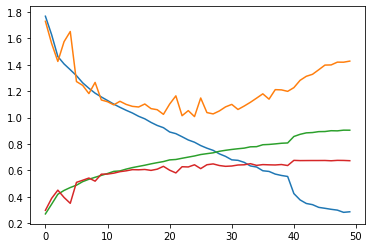

In [55]:
plt.plot(hist), best_acc

In [ ]:
MAX_LOGSTD=10
model_path = 'exploss/sVGG_reconfirm_model.pt'
alpha = 1

# optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
for epoch in range(epochs):  # loop over the dataset multiple times

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0
    processed = 0.0

    # TRAIN
    model.train()
    pbar = tqdm(train_loader, position=0)
    for i, data in enumerate(pbar):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs, features = model(inputs)
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()
        
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += (loss.item() * inputs.size(0))
        running_acc += acc.item()
        processed += len(inputs)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={i} Accuracy={acc.item() / inputs.size(0)}')

    print('- Avg.loss: %.4f | Avg.acc: %.4f' % (running_loss / len(train_loader.dataset), running_acc / len(train_loader.dataset)))
    avgloss = running_loss / len(train_loader.dataset)
    avgacc = running_acc / len(train_loader.dataset)

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs, features = model(inputs)
        
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        running_valloss += (loss.item() * inputs.size(0))
        running_valacc += acc.item()

    print('- Avg. val_loss: %.4f | Avg. val_acc: %.4f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

    avgvalloss = running_valloss / len(val_loader.dataset)
    avgvalacc = running_valacc / len(val_loader.dataset)
    
    scheduler.step(avgvalacc)

    hist.append([avgloss, avgvalloss, avgacc, avgvalacc])
    
    if best_acc < avgvalacc:
        best_acc = avgvalacc
        torch.save(model, model_path)
        print('* Update optimal model')

print('Finished Training')

  0%|          | 0/449 [00:00<?, ?it/s]

Epoch:  1


Loss=1.5092052221298218 Batch_id=448 Accuracy=0.3783783783783784: 100%|██████████| 449/449 [00:24<00:00, 18.39it/s]

- Avg.loss: 1.7557 | Avg.acc: 0.2776



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.7802 | Avg. val_acc: 0.2510
* Update optimal model
Epoch:  2


Loss=1.4560662508010864 Batch_id=448 Accuracy=0.4864864864864865: 100%|██████████| 449/449 [00:24<00:00, 18.32it/s]

- Avg.loss: 1.5479 | Avg.acc: 0.3891


- Avg. val_loss: 1.7395 | Avg. val_acc: 0.3516


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  3


Loss=1.3366326093673706 Batch_id=448 Accuracy=0.5405405405405406: 100%|██████████| 449/449 [00:24<00:00, 18.29it/s]

- Avg.loss: 1.4362 | Avg.acc: 0.4386


- Avg. val_loss: 1.3756 | Avg. val_acc: 0.4698


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  4


Loss=1.2695608139038086 Batch_id=448 Accuracy=0.4594594594594595: 100%|██████████| 449/449 [00:24<00:00, 18.23it/s]

- Avg.loss: 1.3802 | Avg.acc: 0.4656



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.3819 | Avg. val_acc: 0.4689
Epoch:  5


Loss=1.1450906991958618 Batch_id=448 Accuracy=0.5135135135135135: 100%|██████████| 449/449 [00:24<00:00, 18.29it/s]

- Avg.loss: 1.3313 | Avg.acc: 0.4859


- Avg. val_loss: 1.2990 | Avg. val_acc: 0.4887


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  6


Loss=1.244624376296997 Batch_id=448 Accuracy=0.5135135135135135: 100%|██████████| 449/449 [00:24<00:00, 18.24it/s]

- Avg.loss: 1.2723 | Avg.acc: 0.5131


- Avg. val_loss: 1.2177 | Avg. val_acc: 0.5311


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  7


Loss=1.2999883890151978 Batch_id=448 Accuracy=0.5945945945945946: 100%|██████████| 449/449 [00:24<00:00, 18.23it/s]

- Avg.loss: 1.2274 | Avg.acc: 0.5310



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.2599 | Avg. val_acc: 0.5124
Epoch:  8


Loss=0.9905573725700378 Batch_id=448 Accuracy=0.5675675675675675: 100%|██████████| 449/449 [00:24<00:00, 18.24it/s]

- Avg.loss: 1.1992 | Avg.acc: 0.5451



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.2402 | Avg. val_acc: 0.5255
Epoch:  9


Loss=1.4925580024719238 Batch_id=448 Accuracy=0.43243243243243246: 100%|██████████| 449/449 [00:24<00:00, 18.27it/s]

- Avg.loss: 1.1660 | Avg.acc: 0.5566


- Avg. val_loss: 1.1392 | Avg. val_acc: 0.5670


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  10


Loss=1.0395255088806152 Batch_id=448 Accuracy=0.6486486486486487: 100%|██████████| 449/449 [00:24<00:00, 18.25it/s]

- Avg.loss: 1.1499 | Avg.acc: 0.5664



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.1720 | Avg. val_acc: 0.5511
Epoch:  11


Loss=1.2532908916473389 Batch_id=448 Accuracy=0.5945945945945946: 100%|██████████| 449/449 [00:24<00:00, 18.24it/s]

- Avg.loss: 1.1180 | Avg.acc: 0.5793


- Avg. val_loss: 1.1139 | Avg. val_acc: 0.5762


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  12


Loss=1.1819144487380981 Batch_id=448 Accuracy=0.5135135135135135: 100%|██████████| 449/449 [00:24<00:00, 18.23it/s]

- Avg.loss: 1.0975 | Avg.acc: 0.5923



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.1601 | Avg. val_acc: 0.5695
Epoch:  13


Loss=1.2910733222961426 Batch_id=356 Accuracy=0.484375:  80%|███████▉  | 357/449 [00:19<00:04, 18.64it/s]

In [7]:
class sVGG_exp(nn.Module):
    def __init__(self, features, in_features_classifier, n_classes):
        super(sVGG_exp, self).__init__()
        self.features = features
        self.features[0] = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.exploss = ExpLoss(512)
#         self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.classifier = nn.Sequential(nn.Flatten(),
                                        nn.Linear(in_features_classifier, in_features_classifier),
                                        nn.ReLU(inplace=True),
                                        nn.Dropout(0.5, inplace=False),
                                        nn.Linear(in_features_classifier, in_features_classifier // 2),
                                        nn.ReLU(inplace=True),
                                        nn.Dropout(0.5, inplace=False),
                                        nn.Linear(in_features_classifier // 2, n_classes))
        
    def forward(self, x, labels, return_att=True):
        x = self.features(x)
        att, sim_loss = self.exploss(x, labels)

#         att = self.avgpool(x)
        x = self.classifier(att)
        
        if return_att:
            return x, sim_loss, att
        return x, sim_loss
        

## Exploss: apply mask to only concern data with same labels

Hypothesis: from the representation of exploss, it can be considered that some sample with different labels are closed to the considered one. The reason reflects on the attention map. Particularly, since we consider all samples in the batch of data, some samples with different labels have higher score then the ones with same labels.

To reduce this phenomenom, we tend to apply a mask and only concern samples with the sample labels

> Results:
- Val test: val_loss: 0.3313 | Avg. val_acc: 0.9089
- Test set: test_loss: 0.2685 | Avg. test_acc: 0.9156

In [6]:
class ExpLoss(nn.Module):
    def __init__(self, depth):
        super(ExpLoss, self).__init__()
        
        self.depth = depth
        
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()
        
        self.fc1 = nn.Linear(depth, depth)
        self.fc2 = nn.Linear(depth, depth)
        
#         self.main_fc = nn.Linear(depth, depth)
        
        self.sim_act = nn.Sigmoid()
        self.att_act = nn.Sigmoid()
        
        self.out_fc = nn.Sequential(nn.Linear(depth, depth),
                                    nn.BatchNorm1d(depth),
                                    nn.ReLU())
        
    def forward(self, x, labels):
        batch_size = x.size(0)
        x = self.avgpool(x)
        x = self.flatten(x)
        
        x1 = self.fc1(x)
        x2 = self.fc2(x)
        
        # cal sims (batchsize, depth)
        sims = torch.mm(x1, x2.permute(1,0))
        sims = sims / batch_size
        mask = self.filter_mask(labels)
        att = sims * (1 - mask.to(sims.device)) # only consider sample of same labels
#         att = self.att_act(sims)
#         print('att after sigmoid: ', att.min(), att.max(), att.mean(), att.var())
        
#         print('att pure: ', sims.min(), sims.max(), sims.mean(), sims.var())
#         att = torch.tanh(sims)
#         print('att after tanh: ', att.min(), att.max(), att.mean(), att.var())
#         att = self.relu(att)
#         print('att after relu: ', att.min(), att.max(), att.mean(), att.var())
# #         print('min: %.4f, max: %.4f, var: %.4f' % (att.min(), att.max(), att.std()))
        
#         x = self.main_fc(x)
        x = torch.mm(att, x)
#         print('x before out_fc: ', x.min(), x.max(), x.mean(), x.var())
        x = self.out_fc(x)
#         print('x after out_fc: ', x.min(), x.max(), x.mean(), x.var())
        
#         print('att: ', att.min(), att.max(), att.mean(), att.var())
        
        
#         # cal sims loss
        mask = self.filter_mask(labels)
#         sims = sims * mask.to(sims.device)


#         # prevent negative value
#         sims = self.sim_act(sims)
        
#         sims = sims.sum()
#         sims = sims / self.depth
        
        return x, 0

    def filter_mask(self, labels):
        """
        zero
        """
        classes = torch.unique(labels)
        mask = torch.ones((len(labels), len(labels)))
        
        indices = [(labels == k).nonzero().flatten() for k in classes]
        lindices = [torch.combinations(k, r=2, with_replacement=True) for k in indices]
        rindices = [torch.combinations(k.flip(0), r=2, with_replacement=True) for k in indices]
        indices = [torch.cat([lindices[i], rindices[i]]) for i in range(len(lindices))]

        for k in indices:
            mask[k[:,0], k[:,1]] = 0.
            
        return mask

In [7]:
sample_model = vgg16_bn(pretrained=False)
model = sVGG_exp(features=sample_model.features[:34], in_features_classifier=512, n_classes=7)

In [8]:
lr = 0.001
epochs = 50
device = torch.device('cuda')

model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=5, verbose=True)

best_acc = 0.0
hist = []

In [10]:
MAX_LOGSTD=10
model_path = 'exploss_more/sVGG_opt_exploss_originalimgsize_noaugmentation_model.pt'
alpha = 1

# optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
for epoch in range(epochs):  # loop over the dataset multiple times

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0
    processed = 0.0

    # TRAIN
    model.train()
    pbar = tqdm(train_loader, position=0)
    for i, data in enumerate(pbar):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs, sim_loss, features = model(inputs, labels)
        loss = criterion(outputs, labels) + sim_loss
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()
        
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += (loss.item() * inputs.size(0))
        running_acc += acc.item()
        processed += len(inputs)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={i} Accuracy={acc.item() / inputs.size(0)}')

    print('- Avg.loss: %.4f | Avg.acc: %.4f' % (running_loss / len(train_loader.dataset), running_acc / len(train_loader.dataset)))
    avgloss = running_loss / len(train_loader.dataset)
    avgacc = running_acc / len(train_loader.dataset)

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs, sim_loss, features = model(inputs, labels)
        
        loss = criterion(outputs, labels) + sim_loss
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        running_valloss += (loss.item() * inputs.size(0))
        running_valacc += acc.item()

    print('- Avg. val_loss: %.4f | Avg. val_acc: %.4f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

    avgvalloss = running_valloss / len(val_loader.dataset)
    avgvalacc = running_valacc / len(val_loader.dataset)
    
    scheduler.step(avgvalacc)

    hist.append([avgloss, avgvalloss, avgacc, avgvalacc])
    
    if best_acc < avgvalacc:
        best_acc = avgvalacc
        torch.save(model, model_path)
        print('* Update optimal model')

print('Finished Training')


  0%|          | 0/449 [00:00<?, ?it/s]

Epoch:  1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:75: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
Loss=1.1489179134368896 Batch_id=448 Accuracy=0.5135135135135135: 100%|██████████| 449/449 [00:20<00:00, 22.01it/s]

- Avg.loss: 1.5336 | Avg.acc: 0.3802



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.2057 | Avg. val_acc: 0.5015
* Update optimal model
Epoch:  2


Loss=0.7437437176704407 Batch_id=448 Accuracy=0.6756756756756757: 100%|██████████| 449/449 [00:20<00:00, 21.95it/s]

- Avg.loss: 1.0344 | Avg.acc: 0.5661


- Avg. val_loss: 1.2984 | Avg. val_acc: 0.5052


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  3


Loss=0.9348493218421936 Batch_id=448 Accuracy=0.7837837837837838: 100%|██████████| 449/449 [00:20<00:00, 21.90it/s]

- Avg.loss: 0.7858 | Avg.acc: 0.6875


- Avg. val_loss: 1.2546 | Avg. val_acc: 0.6344


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  4


Loss=1.0566060543060303 Batch_id=448 Accuracy=0.6756756756756757: 100%|██████████| 449/449 [00:20<00:00, 21.91it/s]

- Avg.loss: 0.6614 | Avg.acc: 0.7515


- Avg. val_loss: 1.3151 | Avg. val_acc: 0.6634


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  5


Loss=0.20182663202285767 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:20<00:00, 21.89it/s]

- Avg.loss: 0.5296 | Avg.acc: 0.7959



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.7862 | Avg. val_acc: 0.5924
Epoch:  6


Loss=0.520209550857544 Batch_id=448 Accuracy=0.8378378378378378: 100%|██████████| 449/449 [00:20<00:00, 21.90it/s]

- Avg.loss: 0.5033 | Avg.acc: 0.8122


- Avg. val_loss: 1.0317 | Avg. val_acc: 0.6896


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  7


Loss=0.44181689620018005 Batch_id=448 Accuracy=0.8648648648648649: 100%|██████████| 449/449 [00:20<00:00, 21.83it/s]

- Avg.loss: 0.4435 | Avg.acc: 0.8365


- Avg. val_loss: 1.1152 | Avg. val_acc: 0.7275


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  8


Loss=0.624872088432312 Batch_id=448 Accuracy=0.5675675675675675: 100%|██████████| 449/449 [00:20<00:00, 21.72it/s]

- Avg.loss: 0.4596 | Avg.acc: 0.8374


- Avg. val_loss: 0.6723 | Avg. val_acc: 0.7738


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  9


Loss=0.7629865407943726 Batch_id=448 Accuracy=0.6216216216216216: 100%|██████████| 449/449 [00:20<00:00, 21.85it/s]

- Avg.loss: 0.4445 | Avg.acc: 0.8365



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.8702 | Avg. val_acc: 0.7423
Epoch:  10


Loss=0.1679278314113617 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:20<00:00, 21.82it/s]

- Avg.loss: 0.4225 | Avg.acc: 0.8496



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 40.6486 | Avg. val_acc: 0.2694
Epoch:  11


Loss=0.5762057900428772 Batch_id=448 Accuracy=0.8378378378378378: 100%|██████████| 449/449 [00:20<00:00, 21.77it/s]

- Avg.loss: 0.4526 | Avg.acc: 0.8403



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.1041 | Avg. val_acc: 0.6286
Epoch:  12


Loss=3.9201908111572266 Batch_id=448 Accuracy=0.40540540540540543: 100%|██████████| 449/449 [00:20<00:00, 21.87it/s]

- Avg.loss: 0.3652 | Avg.acc: 0.8713



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.7662 | Avg. val_acc: 0.7347
Epoch:  13


Loss=0.500225305557251 Batch_id=448 Accuracy=0.7027027027027027: 100%|██████████| 449/449 [00:20<00:00, 21.94it/s]

- Avg.loss: 0.3608 | Avg.acc: 0.8728



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.8124 | Avg. val_acc: 0.7523
Epoch:  14


Loss=0.1795823574066162 Batch_id=448 Accuracy=0.9459459459459459: 100%|██████████| 449/449 [00:20<00:00, 21.79it/s]

- Avg.loss: 0.3413 | Avg.acc: 0.8859



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.3459 | Avg. val_acc: 0.6609
Epoch    14: reducing learning rate of group 0 to 1.0000e-04.
Epoch:  15


Loss=0.08297997713088989 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:20<00:00, 21.84it/s]     

- Avg.loss: 0.2459 | Avg.acc: 0.9173


- Avg. val_loss: 0.5042 | Avg. val_acc: 0.8610


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  16


Loss=0.32574161887168884 Batch_id=448 Accuracy=0.7837837837837838: 100%|██████████| 449/449 [00:20<00:00, 21.83it/s]

- Avg.loss: 0.2037 | Avg.acc: 0.9303



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.6070 | Avg. val_acc: 0.8417
Epoch:  17


Loss=0.3744775652885437 Batch_id=448 Accuracy=0.8648648648648649: 100%|██████████| 449/449 [00:20<00:00, 21.85it/s]

- Avg.loss: 0.1957 | Avg.acc: 0.9339


- Avg. val_loss: 0.4787 | Avg. val_acc: 0.8646


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  18


Loss=0.0295692328363657 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:20<00:00, 21.84it/s]       

- Avg.loss: 0.1727 | Avg.acc: 0.9422



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.4962 | Avg. val_acc: 0.8612
Epoch:  19


Loss=0.31110072135925293 Batch_id=448 Accuracy=0.918918918918919: 100%|██████████| 449/449 [00:20<00:00, 21.82it/s]

- Avg.loss: 0.1731 | Avg.acc: 0.9426


- Avg. val_loss: 0.3742 | Avg. val_acc: 0.8805


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  20


Loss=0.16568610072135925 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:20<00:00, 21.75it/s]

- Avg.loss: 0.1621 | Avg.acc: 0.9466



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.6365 | Avg. val_acc: 0.8211
Epoch:  21


Loss=0.3356655240058899 Batch_id=448 Accuracy=0.8108108108108109: 100%|██████████| 449/449 [00:20<00:00, 21.93it/s]

- Avg.loss: 0.1562 | Avg.acc: 0.9498



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.5150 | Avg. val_acc: 0.8387
Epoch:  22


Loss=0.009163838811218739 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:20<00:00, 21.85it/s]     

- Avg.loss: 0.1364 | Avg.acc: 0.9576



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.4676 | Avg. val_acc: 0.8632
Epoch:  23


Loss=0.34348490834236145 Batch_id=448 Accuracy=0.8918918918918919: 100%|██████████| 449/449 [00:20<00:00, 21.81it/s]

- Avg.loss: 0.1401 | Avg.acc: 0.9552


- Avg. val_loss: 0.3109 | Avg. val_acc: 0.9030


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  24


Loss=1.401585340499878 Batch_id=448 Accuracy=0.5405405405405406: 100%|██████████| 449/449 [00:20<00:00, 21.75it/s]

- Avg.loss: 0.1434 | Avg.acc: 0.9544



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.5371 | Avg. val_acc: 0.8515
Epoch:  25


Loss=0.6663922667503357 Batch_id=448 Accuracy=0.8648648648648649: 100%|██████████| 449/449 [00:20<00:00, 21.88it/s]

- Avg.loss: 0.1182 | Avg.acc: 0.9584



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.4012 | Avg. val_acc: 0.8752
Epoch:  26


Loss=0.023907631635665894 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:20<00:00, 21.80it/s]     

- Avg.loss: 0.1260 | Avg.acc: 0.9614



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.3701 | Avg. val_acc: 0.8897
Epoch:  27


Loss=0.3074564039707184 Batch_id=448 Accuracy=0.8918918918918919: 100%|██████████| 449/449 [00:20<00:00, 21.82it/s]

- Avg.loss: 0.1178 | Avg.acc: 0.9629



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.3463 | Avg. val_acc: 0.8950
Epoch:  28


Loss=0.19577844440937042 Batch_id=448 Accuracy=0.9459459459459459: 100%|██████████| 449/449 [00:20<00:00, 21.80it/s]

- Avg.loss: 0.1153 | Avg.acc: 0.9604



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.4270 | Avg. val_acc: 0.8897
Epoch:  29


Loss=0.019026899710297585 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:20<00:00, 21.87it/s]     

- Avg.loss: 0.0819 | Avg.acc: 0.9733



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.3948 | Avg. val_acc: 0.8913
Epoch    29: reducing learning rate of group 0 to 1.0000e-05.
Epoch:  30


Loss=0.3067258894443512 Batch_id=448 Accuracy=0.8108108108108109: 100%|██████████| 449/449 [00:20<00:00, 21.85it/s]

- Avg.loss: 0.1020 | Avg.acc: 0.9684



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.3377 | Avg. val_acc: 0.8977
Epoch:  31


Loss=0.05303628742694855 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:20<00:00, 21.85it/s]

- Avg.loss: 0.0888 | Avg.acc: 0.9732



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.3376 | Avg. val_acc: 0.8994
Epoch:  32


Loss=1.1358290910720825 Batch_id=448 Accuracy=0.6756756756756757: 100%|██████████| 449/449 [00:20<00:00, 21.69it/s]

- Avg.loss: 0.0822 | Avg.acc: 0.9732



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.5084 | Avg. val_acc: 0.8607
Epoch:  33


Loss=0.020790917798876762 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:20<00:00, 21.80it/s]     

- Avg.loss: 0.0918 | Avg.acc: 0.9666



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.3754 | Avg. val_acc: 0.8936
Epoch:  34


Loss=0.657907247543335 Batch_id=448 Accuracy=0.7027027027027027: 100%|██████████| 449/449 [00:20<00:00, 21.76it/s]

- Avg.loss: 0.1030 | Avg.acc: 0.9662



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.3561 | Avg. val_acc: 0.8880
Epoch:  35


Loss=0.9251867532730103 Batch_id=448 Accuracy=0.8378378378378378: 100%|██████████| 449/449 [00:20<00:00, 21.75it/s]

- Avg.loss: 0.0773 | Avg.acc: 0.9723



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.3552 | Avg. val_acc: 0.8877
Epoch    35: reducing learning rate of group 0 to 1.0000e-06.
Epoch:  36


Loss=0.1644403040409088 Batch_id=448 Accuracy=0.8918918918918919: 100%|██████████| 449/449 [00:20<00:00, 21.89it/s]

- Avg.loss: 0.0834 | Avg.acc: 0.9715



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.3449 | Avg. val_acc: 0.9019
Epoch:  37


Loss=0.01692992076277733 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:20<00:00, 21.80it/s]      

- Avg.loss: 0.0858 | Avg.acc: 0.9735


- Avg. val_loss: 0.3055 | Avg. val_acc: 0.9055


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  38


Loss=0.8339499235153198 Batch_id=448 Accuracy=0.6756756756756757: 100%|██████████| 449/449 [00:20<00:00, 21.83it/s]

- Avg.loss: 0.0864 | Avg.acc: 0.9706



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.3925 | Avg. val_acc: 0.8874
Epoch:  39


Loss=0.3722289204597473 Batch_id=448 Accuracy=0.8378378378378378: 100%|██████████| 449/449 [00:20<00:00, 21.83it/s]

- Avg.loss: 0.0669 | Avg.acc: 0.9775



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.4572 | Avg. val_acc: 0.8718
Epoch:  40


Loss=0.2277878373861313 Batch_id=448 Accuracy=0.8648648648648649: 100%|██████████| 449/449 [00:20<00:00, 21.83it/s]

- Avg.loss: 0.0739 | Avg.acc: 0.9757



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.3117 | Avg. val_acc: 0.8924
Epoch:  41


Loss=0.17864151298999786 Batch_id=448 Accuracy=0.918918918918919: 100%|██████████| 449/449 [00:20<00:00, 21.84it/s]

- Avg.loss: 0.0748 | Avg.acc: 0.9750



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.3705 | Avg. val_acc: 0.8888
Epoch:  42


Loss=0.22981280088424683 Batch_id=448 Accuracy=0.8918918918918919: 100%|██████████| 449/449 [00:20<00:00, 21.85it/s]

- Avg.loss: 0.0764 | Avg.acc: 0.9736



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.4497 | Avg. val_acc: 0.8707
Epoch:  43


Loss=0.6786816716194153 Batch_id=448 Accuracy=0.918918918918919: 100%|██████████| 449/449 [00:20<00:00, 21.84it/s]

- Avg.loss: 0.0639 | Avg.acc: 0.9785



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.3124 | Avg. val_acc: 0.8933
Epoch    43: reducing learning rate of group 0 to 1.0000e-07.
Epoch:  44


Loss=0.45503610372543335 Batch_id=448 Accuracy=0.8648648648648649: 100%|██████████| 449/449 [00:20<00:00, 21.86it/s]

- Avg.loss: 0.0751 | Avg.acc: 0.9745



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.3212 | Avg. val_acc: 0.8961
Epoch:  45


Loss=0.036165233701467514 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:20<00:00, 21.84it/s]     

- Avg.loss: 0.0769 | Avg.acc: 0.9740



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.3963 | Avg. val_acc: 0.8788
Epoch:  46


Loss=0.0023188511840999126 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:20<00:00, 21.83it/s]    

- Avg.loss: 0.0789 | Avg.acc: 0.9742



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.3082 | Avg. val_acc: 0.9036
Epoch:  47


Loss=0.19109581410884857 Batch_id=448 Accuracy=0.9459459459459459: 100%|██████████| 449/449 [00:20<00:00, 21.89it/s]

- Avg.loss: 0.0712 | Avg.acc: 0.9753



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.3075 | Avg. val_acc: 0.9036
Epoch:  48


Loss=0.05206471309065819 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:20<00:00, 21.82it/s]      

- Avg.loss: 0.0819 | Avg.acc: 0.9722


- Avg. val_loss: 0.3116 | Avg. val_acc: 0.9092


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  49


Loss=0.02757912687957287 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:20<00:00, 21.85it/s]      

- Avg.loss: 0.0811 | Avg.acc: 0.9744



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.3706 | Avg. val_acc: 0.8897
Epoch:  50


Loss=0.0040730820037424564 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:20<00:00, 21.88it/s]    

- Avg.loss: 0.0901 | Avg.acc: 0.9720


- Avg. val_loss: 0.3518 | Avg. val_acc: 0.8916
Finished Training


In [11]:
pickle.dump(hist, open('exploss_more/sVGG_opt_exploss_originalimgsize_noaugmentation_hist.hdf5', 'wb'))

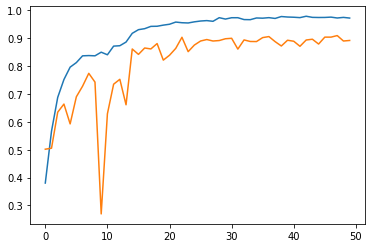

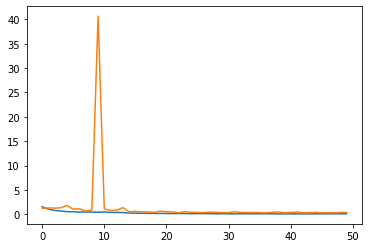

In [18]:
plt.plot([k[-2] for k in hist])
plt.plot([k[-1] for k in hist])
plt.show()
plt.plot([k[0] for k in hist])
plt.plot([k[1] for k in hist])

In [19]:
model = torch.load('exploss_more/sVGG_opt_exploss_originalimgsize_noaugmentation_model.pt')

running_valloss = 0.0
running_valacc = 0.0
exp_features = []
exp_labels = []
for i,data in enumerate(test_loader):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs,_, features = model(inputs, labels)
    
    with torch.no_grad():
        exp_features.append(features.detach().cpu())
        exp_labels.append(labels.detach().cpu())

    loss = criterion(outputs, labels)
    acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

    running_valloss += (loss.item() * inputs.size(0))
    running_valacc += acc.item()

print('- Avg. val_loss: %.4f | Avg. val_acc: %.4f' % (running_valloss / len(test_loader.dataset), running_valacc / len(test_loader.dataset)))


- Avg. val_loss: 0.3059 | Avg. val_acc: 0.9072


In [20]:
exp_features = torch.cat(exp_features, axis=0)
exp_labels = torch.cat(exp_labels)

exp_features.size()

torch.Size([3589, 512])

(<Figure size 1080x720 with 1 Axes>, array([[-14.403368 , -34.50583  ],
        [-29.667225 ,  26.180704 ],
        [ 19.319317 ,  62.2013   ],
        ...,
        [ -0.654068 ,  -5.4536724],
        [ 76.05806  ,   1.4516386],
        [-65.49677  ,   2.7520075]], dtype=float32))

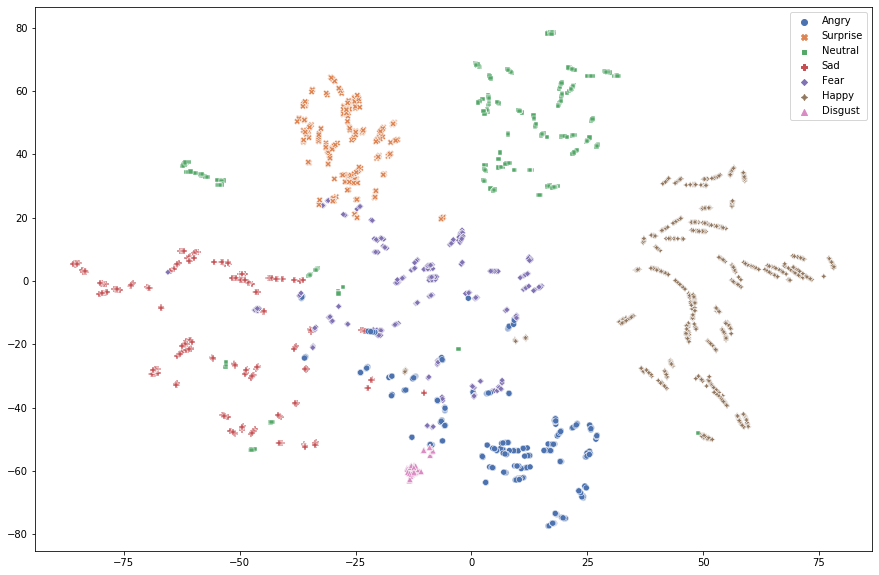

In [23]:
visualize_embedding(exp_features.numpy(), exp_labels.numpy(), label_dict=label_dict, save_path='exploss_more/sVGG_opt_exploss_originalimgsize_noaugmentation_tsne.png')

## Add residual

Hypothesis: the unstable of the the architecture may effect by vastly reconstruct each sample from the attention map without considering the original features. As a result, we add residual connection to observe whether model is more stable or not.

> Result
    Observing the training plot shows that our hypothesis is confirmed. The training plot is more stable. Especially the loss which is less fluctuate than the proposed model without residual connection

In [4]:
class ExpLoss(nn.Module):
    def __init__(self, depth, residual=True):
        super(ExpLoss, self).__init__()
        
        self.depth = depth
        self.residual = residual
        
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()
        
        self.fc1 = nn.Linear(depth, depth)
        self.fc2 = nn.Linear(depth, depth)
        
#         self.main_fc = nn.Linear(depth, depth)
        
        self.sim_act = nn.Sigmoid()
        self.att_act = nn.Sigmoid()
        
        self.out_fc = nn.Sequential(nn.Linear(depth, depth),
                                    nn.BatchNorm1d(depth),
                                    nn.ReLU())
        
    def forward(self, x, labels):
        batch_size = x.size(0)
        
        x = self.avgpool(x)
        x = self.flatten(x)
        
        if self.residual:
            x_res = x
        
        x1 = self.fc1(x)
        x2 = self.fc2(x)
        
        # cal sims (batchsize, depth)
        sims = torch.mm(x1, x2.permute(1,0))
        sims = sims / batch_size
        mask = self.filter_mask(labels)
        att = sims * (1 - mask.to(sims.device)) # only consider sample of same labels
#         att = self.att_act(sims)
#         print('att after sigmoid: ', att.min(), att.max(), att.mean(), att.var())
        
#         print('att pure: ', sims.min(), sims.max(), sims.mean(), sims.var())
#         att = torch.tanh(sims)
#         print('att after tanh: ', att.min(), att.max(), att.mean(), att.var())
#         att = self.relu(att)
#         print('att after relu: ', att.min(), att.max(), att.mean(), att.var())
# #         print('min: %.4f, max: %.4f, var: %.4f' % (att.min(), att.max(), att.std()))
        
#         x = self.main_fc(x)
        x = torch.mm(att, x)
#         print('x before out_fc: ', x.min(), x.max(), x.mean(), x.var())
        x = self.out_fc(x)
    
        if self.residual:
            x = x + x_res
    
#         print('x after out_fc: ', x.min(), x.max(), x.mean(), x.var())
        
#         print('att: ', att.min(), att.max(), att.mean(), att.var())
        
        
#         # cal sims loss
#         mask = self.filter_mask(labels)
#         sims = sims * mask.to(sims.device)


#         # prevent negative value
#         sims = self.sim_act(sims)
        
#         sims = sims.sum()
#         sims = sims / self.depth
        
        return x, 0

    def filter_mask(self, labels):
        """
        zero
        """
        classes = torch.unique(labels)
        mask = torch.ones((len(labels), len(labels)))
        
        indices = [(labels == k).nonzero().flatten() for k in classes]
        lindices = [torch.combinations(k, r=2, with_replacement=True) for k in indices]
        rindices = [torch.combinations(k.flip(0), r=2, with_replacement=True) for k in indices]
        indices = [torch.cat([lindices[i], rindices[i]]) for i in range(len(lindices))]

        for k in indices:
            mask[k[:,0], k[:,1]] = 0.
            
        return mask

In [5]:
sample_model = vgg16_bn(pretrained=False)
model = sVGG_exp(features=sample_model.features[:34], in_features_classifier=512, n_classes=7)

NameError: name 'vgg16_bn' is not defined

In [10]:
lr = 0.001
epochs = 50
device = torch.device('cuda')

model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=5, verbose=True)

best_acc = 0.0
hist = []

In [12]:
MAX_LOGSTD=10
model_path = 'exploss_more/sVGG_opt_residualexploss_originalimgsize_noaugmentation_model.pt'
alpha = 1

# optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
for epoch in range(epochs):  # loop over the dataset multiple times

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0
    processed = 0.0

    # TRAIN
    model.train()
    pbar = tqdm(train_loader, position=0)
    for i, data in enumerate(pbar):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs, sim_loss, features = model(inputs, labels)
        loss = criterion(outputs, labels) + sim_loss
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()
        
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += (loss.item() * inputs.size(0))
        running_acc += acc.item()
        processed += len(inputs)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={i} Accuracy={acc.item() / inputs.size(0)}')

    print('- Avg.loss: %.4f | Avg.acc: %.4f' % (running_loss / len(train_loader.dataset), running_acc / len(train_loader.dataset)))
    avgloss = running_loss / len(train_loader.dataset)
    avgacc = running_acc / len(train_loader.dataset)

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs, sim_loss, features = model(inputs, labels)
        
        loss = criterion(outputs, labels) + sim_loss
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        running_valloss += (loss.item() * inputs.size(0))
        running_valacc += acc.item()

    print('- Avg. val_loss: %.4f | Avg. val_acc: %.4f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

    avgvalloss = running_valloss / len(val_loader.dataset)
    avgvalacc = running_valacc / len(val_loader.dataset)
    
    scheduler.step(avgvalacc)

    hist.append([avgloss, avgvalloss, avgacc, avgvalacc])
    
    if best_acc < avgvalacc:
        best_acc = avgvalacc
        torch.save(model, model_path)
        print('* Update optimal model')

print('Finished Training')


  0%|          | 0/449 [00:00<?, ?it/s]

Epoch:  1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
Loss=2.422267198562622 Batch_id=448 Accuracy=0.05405405405405406: 100%|██████████| 449/449 [00:19<00:00, 23.43it/s]

- Avg.loss: 1.5281 | Avg.acc: 0.3857



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.5744 | Avg. val_acc: 0.3692
* Update optimal model
Epoch:  2


Loss=1.1031711101531982 Batch_id=448 Accuracy=0.5405405405405406: 100%|██████████| 449/449 [00:19<00:00, 23.48it/s]

- Avg.loss: 1.1720 | Avg.acc: 0.5092



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 3.0493 | Avg. val_acc: 0.2700
Epoch:  3


Loss=0.4810248613357544 Batch_id=448 Accuracy=0.8108108108108109: 100%|██████████| 449/449 [00:19<00:00, 23.40it/s]

- Avg.loss: 0.8764 | Avg.acc: 0.6101


- Avg. val_loss: 1.1428 | Avg. val_acc: 0.5444


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  4


Loss=0.866540253162384 Batch_id=448 Accuracy=0.5945945945945946: 100%|██████████| 449/449 [00:19<00:00, 23.38it/s]

- Avg.loss: 0.8303 | Avg.acc: 0.6262


- Avg. val_loss: 0.8973 | Avg. val_acc: 0.5812


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  5


Loss=1.1520580053329468 Batch_id=448 Accuracy=0.5405405405405406: 100%|██████████| 449/449 [00:19<00:00, 23.26it/s]

- Avg.loss: 0.7774 | Avg.acc: 0.6439



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.2339 | Avg. val_acc: 0.5227
Epoch:  6


Loss=1.151224970817566 Batch_id=448 Accuracy=0.5675675675675675: 100%|██████████| 449/449 [00:19<00:00, 23.33it/s]

- Avg.loss: 0.7117 | Avg.acc: 0.6963



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.8894 | Avg. val_acc: 0.5391
Epoch:  7


Loss=0.5061628222465515 Batch_id=448 Accuracy=0.7297297297297297: 100%|██████████| 449/449 [00:19<00:00, 23.36it/s]

- Avg.loss: 0.6476 | Avg.acc: 0.7537


- Avg. val_loss: 1.0863 | Avg. val_acc: 0.6495


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  8


Loss=0.7298742532730103 Batch_id=448 Accuracy=0.7027027027027027: 100%|██████████| 449/449 [00:19<00:00, 23.32it/s]

- Avg.loss: 0.5184 | Avg.acc: 0.8030



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.1998 | Avg. val_acc: 0.5804
Epoch:  9


Loss=0.8177423477172852 Batch_id=448 Accuracy=0.6216216216216216: 100%|██████████| 449/449 [00:19<00:00, 23.31it/s]

- Avg.loss: 0.5056 | Avg.acc: 0.8056


- Avg. val_loss: 1.1503 | Avg. val_acc: 0.6665


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  10


Loss=0.30738937854766846 Batch_id=448 Accuracy=0.918918918918919: 100%|██████████| 449/449 [00:19<00:00, 23.25it/s]

- Avg.loss: 0.4756 | Avg.acc: 0.8197


- Avg. val_loss: 0.6832 | Avg. val_acc: 0.7492


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  11


Loss=0.5445253252983093 Batch_id=448 Accuracy=0.7567567567567568: 100%|██████████| 449/449 [00:19<00:00, 23.25it/s]

- Avg.loss: 0.4129 | Avg.acc: 0.8482


- Avg. val_loss: 0.5444 | Avg. val_acc: 0.7818


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  12


Loss=0.46336328983306885 Batch_id=448 Accuracy=0.8108108108108109: 100%|██████████| 449/449 [00:19<00:00, 23.20it/s]

- Avg.loss: 0.4089 | Avg.acc: 0.8516



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.0448 | Avg. val_acc: 0.6765
Epoch:  13


Loss=2.508296251296997 Batch_id=448 Accuracy=0.43243243243243246: 100%|██████████| 449/449 [00:19<00:00, 23.23it/s]

- Avg.loss: 0.3890 | Avg.acc: 0.8625



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.1473 | Avg. val_acc: 0.7166
Epoch:  14


Loss=0.1689281016588211 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:19<00:00, 23.23it/s]

- Avg.loss: 0.3471 | Avg.acc: 0.8821



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.6207 | Avg. val_acc: 0.4221
Epoch:  15


Loss=1.096496820449829 Batch_id=448 Accuracy=0.6486486486486487: 100%|██████████| 449/449 [00:19<00:00, 23.30it/s]

- Avg.loss: 0.3529 | Avg.acc: 0.8801


- Avg. val_loss: 0.5646 | Avg. val_acc: 0.8172


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  16


Loss=0.12655960023403168 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:19<00:00, 23.15it/s]

- Avg.loss: 0.2558 | Avg.acc: 0.9148



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.8912 | Avg. val_acc: 0.7531
Epoch:  17


Loss=0.13722826540470123 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:19<00:00, 23.20it/s]

- Avg.loss: 0.2917 | Avg.acc: 0.9058



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.8669 | Avg. val_acc: 0.7478
Epoch:  18


Loss=0.9632329940795898 Batch_id=448 Accuracy=0.7297297297297297: 100%|██████████| 449/449 [00:19<00:00, 23.27it/s]

- Avg.loss: 0.2285 | Avg.acc: 0.9265



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.3238 | Avg. val_acc: 0.6935
Epoch:  19


Loss=0.3032684326171875 Batch_id=448 Accuracy=0.918918918918919: 100%|██████████| 449/449 [00:19<00:00, 23.25it/s]

- Avg.loss: 0.2101 | Avg.acc: 0.9363


- Avg. val_loss: 0.6627 | Avg. val_acc: 0.8267


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  20


Loss=0.13581669330596924 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:19<00:00, 23.22it/s]

- Avg.loss: 0.2397 | Avg.acc: 0.9261



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.7163 | Avg. val_acc: 0.7328
Epoch:  21


Loss=0.0913119912147522 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:19<00:00, 23.23it/s]       

- Avg.loss: 0.2163 | Avg.acc: 0.9325



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.5314 | Avg. val_acc: 0.6024
Epoch:  22


Loss=0.704975426197052 Batch_id=448 Accuracy=0.8918918918918919: 100%|██████████| 449/449 [00:19<00:00, 23.30it/s]

- Avg.loss: 0.2059 | Avg.acc: 0.9374


- Avg. val_loss: 0.4653 | Avg. val_acc: 0.8526


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  23


Loss=0.14604619145393372 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:19<00:00, 23.22it/s]

- Avg.loss: 0.1579 | Avg.acc: 0.9519



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.1096 | Avg. val_acc: 0.7425
Epoch:  24


Loss=1.846161127090454 Batch_id=448 Accuracy=0.7567567567567568: 100%|██████████| 449/449 [00:19<00:00, 23.25it/s]

- Avg.loss: 0.1811 | Avg.acc: 0.9473


- Avg. val_loss: 0.4899 | Avg. val_acc: 0.8755


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  25


Loss=0.3824840486049652 Batch_id=448 Accuracy=0.8648648648648649: 100%|██████████| 449/449 [00:19<00:00, 23.32it/s]

- Avg.loss: 0.1826 | Avg.acc: 0.9437



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.6598 | Avg. val_acc: 0.7960
Epoch:  26


Loss=0.019792404025793076 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:19<00:00, 23.31it/s]     

- Avg.loss: 0.1643 | Avg.acc: 0.9473



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.4659 | Avg. val_acc: 0.8649
Epoch:  27


Loss=1.6602789163589478 Batch_id=448 Accuracy=0.7027027027027027: 100%|██████████| 449/449 [00:19<00:00, 23.25it/s]

- Avg.loss: 0.1846 | Avg.acc: 0.9481



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.9139 | Avg. val_acc: 0.7963
Epoch:  28


Loss=0.302777498960495 Batch_id=448 Accuracy=0.9459459459459459: 100%|██████████| 449/449 [00:19<00:00, 23.22it/s]


- Avg.loss: 0.1612 | Avg.acc: 0.9524


  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.4770 | Avg. val_acc: 0.6913
Epoch:  29


Loss=0.044276490807533264 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:19<00:00, 23.26it/s]     

- Avg.loss: 0.1788 | Avg.acc: 0.9466


- Avg. val_loss: 0.2965 | Avg. val_acc: 0.9092


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  30


Loss=2.031543493270874 Batch_id=448 Accuracy=0.5405405405405406: 100%|██████████| 449/449 [00:19<00:00, 23.32it/s]

- Avg.loss: 0.1501 | Avg.acc: 0.9534



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.5318 | Avg. val_acc: 0.8272
Epoch:  31


Loss=0.40388375520706177 Batch_id=448 Accuracy=0.8108108108108109: 100%|██████████| 449/449 [00:19<00:00, 23.31it/s]

- Avg.loss: 0.1617 | Avg.acc: 0.9507



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.4349 | Avg. val_acc: 0.8718
Epoch:  32


Loss=0.038028255105018616 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:19<00:00, 23.31it/s]     

- Avg.loss: 0.1350 | Avg.acc: 0.9554



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.4976 | Avg. val_acc: 0.8624
Epoch:  33


Loss=0.030756289139389992 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:19<00:00, 23.33it/s]     

- Avg.loss: 0.1464 | Avg.acc: 0.9538



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.7040 | Avg. val_acc: 0.7807
Epoch:  34


Loss=0.04402269050478935 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:19<00:00, 23.34it/s]

- Avg.loss: 0.1280 | Avg.acc: 0.9612



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.6273 | Avg. val_acc: 0.8484
Epoch:  35


Loss=0.8762879371643066 Batch_id=448 Accuracy=0.7297297297297297: 100%|██████████| 449/449 [00:19<00:00, 23.32it/s]

- Avg.loss: 0.1250 | Avg.acc: 0.9621



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.6126 | Avg. val_acc: 0.7997
Epoch    35: reducing learning rate of group 0 to 1.0000e-04.
Epoch:  36


Loss=0.038668278604745865 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:19<00:00, 23.26it/s]     

- Avg.loss: 0.0821 | Avg.acc: 0.9736


- Avg. val_loss: 0.3581 | Avg. val_acc: 0.9150


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  37


Loss=0.06466415524482727 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:19<00:00, 23.36it/s]

- Avg.loss: 0.0584 | Avg.acc: 0.9828



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.3960 | Avg. val_acc: 0.9083
Epoch:  42


Loss=0.005355306901037693 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:19<00:00, 23.31it/s]     

- Avg.loss: 0.0539 | Avg.acc: 0.9824



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.4102 | Avg. val_acc: 0.9067
Epoch:  43


Loss=0.003310701111331582 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:19<00:00, 23.32it/s]     

- Avg.loss: 0.0549 | Avg.acc: 0.9820


- Avg. val_loss: 0.3251 | Avg. val_acc: 0.9220


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  44


Loss=0.028943246230483055 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:19<00:00, 23.30it/s]     

- Avg.loss: 0.0517 | Avg.acc: 0.9839



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.6051 | Avg. val_acc: 0.8468
Epoch:  45


Loss=0.024795658886432648 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:19<00:00, 23.29it/s]

- Avg.loss: 0.0448 | Avg.acc: 0.9857



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.2985 | Avg. val_acc: 0.9069
Epoch:  46


Loss=0.0019346466287970543 Batch_id=49 Accuracy=1.0:  11%|█         | 49/449 [00:02<00:17, 23.16it/s]   IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [13]:
pickle.dump(hist, open('exploss_more/sVGG_opt_residualexploss_originalimgsize_noaugmentation_hist.hdf5', 'wb'))

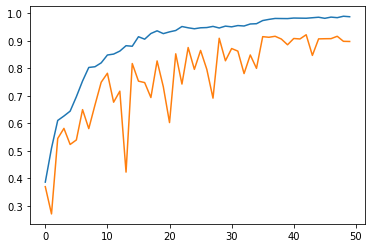

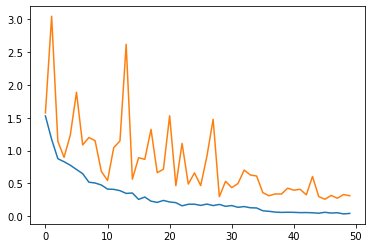

0.9219838395096127

In [16]:
plt.plot([k[-2] for k in hist])
plt.plot([k[-1] for k in hist])
plt.show()
plt.plot([k[0] for k in hist])
plt.plot([k[1] for k in hist])
plt.show()
best_acc

In [17]:
model = torch.load('exploss_more/sVGG_opt_residualexploss_originalimgsize_noaugmentation_model.pt')

running_valloss = 0.0
running_valacc = 0.0
exp_features = []
exp_labels = []
for i,data in enumerate(test_loader):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs,_, features = model(inputs, labels)
    
    with torch.no_grad():
        exp_features.append(features.detach().cpu())
        exp_labels.append(labels.detach().cpu())

    loss = criterion(outputs, labels)
    acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

    running_valloss += (loss.item() * inputs.size(0))
    running_valacc += acc.item()

print('- Avg. val_loss: %.4f | Avg. val_acc: %.4f' % (running_valloss / len(test_loader.dataset), running_valacc / len(test_loader.dataset)))


- Avg. val_loss: 0.2122 | Avg. val_acc: 0.9323


In [18]:
exp_features = torch.cat(exp_features, axis=0)
exp_labels = torch.cat(exp_labels)

exp_features.size()

torch.Size([3589, 512])

(<Figure size 1080x720 with 1 Axes>, array([[ -4.850128 , -17.706215 ],
        [ 39.12424  , -34.831497 ],
        [ -2.0447228,  62.466843 ],
        ...,
        [ 38.080666 ,  37.731728 ],
        [-41.088387 ,  -5.8245764],
        [ 47.870895 ,  39.210823 ]], dtype=float32))

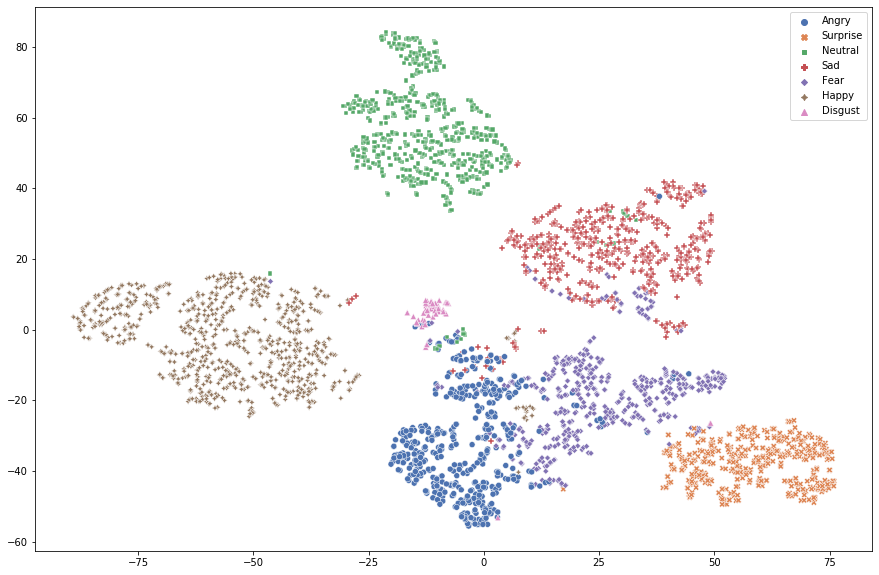

In [21]:
visualize_embedding(exp_features.numpy(), exp_labels.numpy(), label_dict=label_dict, save_path='exploss_more/sVGG_opt_residualexploss_originalimgsize_noaugmentation_tsne.png')


## Increase the batch size to 256

> Increase the batch size also increases the performance of the model

In [1]:
MAX_LOGSTD=10
model_path = 'exploss_more/sVGG_opt_residualexploss_b256_originalimgsize_noaugmentation_model.pt'
alpha = 1

# optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
for epoch in range(epochs):  # loop over the dataset multiple times

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0
    processed = 0.0

    # TRAIN
    model.train()
    pbar = tqdm(train_loader, position=0)
    for i, data in enumerate(pbar):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs, sim_loss, features = model(inputs, labels)
        loss = criterion(outputs, labels) + sim_loss
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()
        
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += (loss.item() * inputs.size(0))
        running_acc += acc.item()
        processed += len(inputs)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={i} Accuracy={acc.item() / inputs.size(0)}')

    print('- Avg.loss: %.4f | Avg.acc: %.4f' % (running_loss / len(train_loader.dataset), running_acc / len(train_loader.dataset)))
    avgloss = running_loss / len(train_loader.dataset)
    avgacc = running_acc / len(train_loader.dataset)

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs, sim_loss, features = model(inputs, labels)
        
        loss = criterion(outputs, labels) + sim_loss
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        running_valloss += (loss.item() * inputs.size(0))
        running_valacc += acc.item()

    print('- Avg. val_loss: %.4f | Avg. val_acc: %.4f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

    avgvalloss = running_valloss / len(val_loader.dataset)
    avgvalacc = running_valacc / len(val_loader.dataset)
    
    scheduler.step(avgvalacc)

    hist.append([avgloss, avgvalloss, avgacc, avgvalacc])
    
    if best_acc < avgvalacc:
        best_acc = avgvalacc
        torch.save(model, model_path)
        print('* Update optimal model')

print('Finished Training')


NameError: name 'epochs' is not defined

In [26]:
pickle.dump(hist, open('exploss_more/sVGG_opt_residualexploss_b256_originalimgsize_noaugmentation_hist.hdf5', 'wb'))


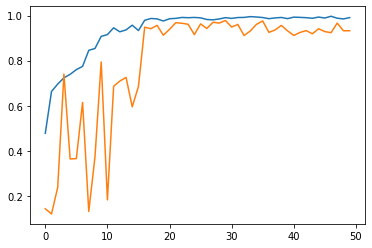

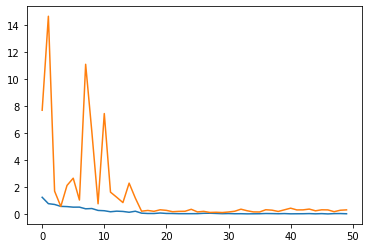

0.9779882975759264

In [28]:
plt.plot([k[-2] for k in hist])
plt.plot([k[-1] for k in hist])
plt.show()
plt.plot([k[0] for k in hist])
plt.plot([k[1] for k in hist])
plt.show()
best_acc

In [29]:
model = torch.load('exploss_more/sVGG_opt_residualexploss_b256_originalimgsize_noaugmentation_model.pt')

running_valloss = 0.0
running_valacc = 0.0
exp_features = []
exp_labels = []
for i,data in enumerate(test_loader):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs,_, features = model(inputs, labels)
    
    with torch.no_grad():
        exp_features.append(features.detach().cpu())
        exp_labels.append(labels.detach().cpu())

    loss = criterion(outputs, labels)
    acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

    running_valloss += (loss.item() * inputs.size(0))
    running_valacc += acc.item()

print('- Avg. val_loss: %.4f | Avg. val_acc: %.4f' % (running_valloss / len(test_loader.dataset), running_valacc / len(test_loader.dataset)))


- Avg. val_loss: 0.0847 | Avg. val_acc: 0.9805


In [30]:
exp_features = torch.cat(exp_features, axis=0)
exp_labels = torch.cat(exp_labels)

exp_features.size()

torch.Size([3589, 512])

(<Figure size 1080x720 with 1 Axes>, array([[  2.1121368,   7.4132457],
        [-59.89857  , -25.255476 ],
        [ 17.095623 ,  33.494175 ],
        ...,
        [-11.0362625,  47.765873 ],
        [-53.839764 ,  41.498753 ],
        [-46.631226 ,  41.37578  ]], dtype=float32))

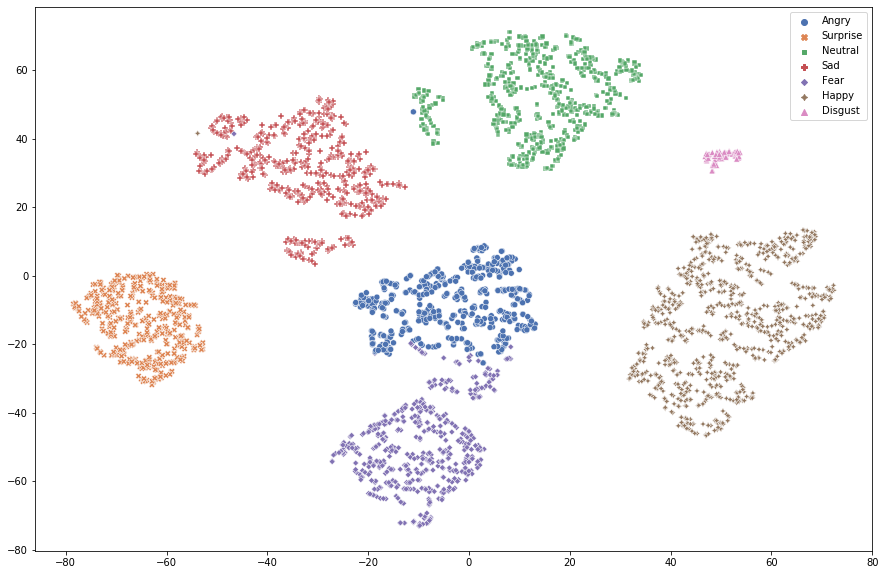

In [31]:
visualize_embedding(exp_features.numpy(), exp_labels.numpy(), label_dict=label_dict, save_path='exploss_more/sVGG_opt_residualexploss_b256_originalimgsize_noaugmentation_tsne.png')


## Add mechanism to intermediate

In [55]:
class ExpLoss(nn.Module):
    def __init__(self, depth, residual=True):
        super(ExpLoss, self).__init__()
        
        self.depth = depth
        self.residual = residual
        
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()
        
        self.fc1 = nn.Linear(depth, depth)
        self.fc2 = nn.Linear(depth, depth)
        
#         self.main_fc = nn.Linear(depth, depth)
        
        self.sim_act = nn.Sigmoid()
        self.att_act = nn.Sigmoid()
        
#         self.out_fc = nn.Sequential(nn.Linear(depth, depth),
#                                     nn.BatchNorm1d(depth),
#                                     nn.ReLU())

        self.out_fc = nn.Sequential(nn.Conv2d(depth, depth, kernel_size=1, padding=0, stride=1),
                                    nn.BatchNorm2d(depth),
                                    nn.ReLU())

        
    def forward(self, x, labels):
        batch_size, d, h, w = x.size()
        
        if self.residual:
            x_res = x
        
        x = self.avgpool(x)
        x = self.flatten(x)
        
        x1 = self.fc1(x)
        x2 = self.fc2(x)
        
        # cal sims (batchsize, depth)
        sims = torch.mm(x1, x2.permute(1,0))
        sims = sims / batch_size
        mask = self.filter_mask(labels)
        att = sims * (1 - mask.to(sims.device)) # only consider sample of same labels
        
        x = torch.mm(att, x_res.reshape(batch_size, d*h*w))
        x = x.reshape(batch_size, d, h, w)
        x = self.out_fc(x)
    
        if self.residual:
            x = x + x_res
        
        return x, 0

    def filter_mask(self, labels):
        """
        zero
        """
        classes = torch.unique(labels)
        mask = torch.ones((len(labels), len(labels)))
        
        indices = [(labels == k).nonzero().flatten() for k in classes]
        lindices = [torch.combinations(k, r=2, with_replacement=True) for k in indices]
        rindices = [torch.combinations(k.flip(0), r=2, with_replacement=True) for k in indices]
        indices = [torch.cat([lindices[i], rindices[i]]) for i in range(len(lindices))]

        for k in indices:
            mask[k[:,0], k[:,1]] = 0.
            
        return mask

### 1 last conv

In [72]:
class sVGG_exp(nn.Module):
    def __init__(self, features, in_features_classifier, n_classes):
        super(sVGG_exp, self).__init__()
        self.features_0 = features[:7]
        self.features_1 = features[7:14]
        self.features_2 = features[14:24]
        self.features_3 = features[24:34]
        
        self.features_0[0] = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        
        self.exploss_3 = ExpLoss(512)
        
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.classifier = nn.Sequential(nn.Flatten(),
                                        nn.Linear(in_features_classifier, in_features_classifier),
                                        nn.ReLU(inplace=True),
                                        nn.Dropout(0.5, inplace=False),
                                        nn.Linear(in_features_classifier, in_features_classifier // 2),
                                        nn.ReLU(inplace=True),
                                        nn.Dropout(0.5, inplace=False),
                                        nn.Linear(in_features_classifier // 2, n_classes))
        
    def forward(self, x, labels, return_att=True):
        x = self.features_0(x)
        
        x = self.features_1(x)
        
        x = self.features_2(x)
        
        x = self.features_3(x)
        x, _ = self.exploss_3(x, labels)
        
        att = self.avgpool(x)
        x = self.classifier(att)
        
        if return_att:
            return x, 0, att
        return x, 0
        

In [57]:
sample_model = vgg16_bn(pretrained=False)
model = sVGG_exp(features=sample_model.features[:34], in_features_classifier=512, n_classes=7)

In [58]:
lr = 0.001
epochs = 50
device = torch.device('cuda')

model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=5, verbose=True)

best_acc = 0.0
hist = []

In [48]:
MAX_LOGSTD=10
model_path = 'exploss_more/sVGG_opt_residualexploss_lastconv_originalimgsize_noaugmentation_model.pt'
alpha = 1

# optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
for epoch in range(epochs):  # loop over the dataset multiple times

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0
    processed = 0.0

    # TRAIN
    model.train()
    pbar = tqdm(train_loader, position=0)
    for i, data in enumerate(pbar):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs, sim_loss, features = model(inputs, labels)
        loss = criterion(outputs, labels) + sim_loss
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()
        
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += (loss.item() * inputs.size(0))
        running_acc += acc.item()
        processed += len(inputs)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={i} Accuracy={acc.item() / inputs.size(0)}')

    print('- Avg.loss: %.4f | Avg.acc: %.4f' % (running_loss / len(train_loader.dataset), running_acc / len(train_loader.dataset)))
    avgloss = running_loss / len(train_loader.dataset)
    avgacc = running_acc / len(train_loader.dataset)

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs, sim_loss, features = model(inputs, labels)
        
        loss = criterion(outputs, labels) + sim_loss
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        running_valloss += (loss.item() * inputs.size(0))
        running_valacc += acc.item()

    print('- Avg. val_loss: %.4f | Avg. val_acc: %.4f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

    avgvalloss = running_valloss / len(val_loader.dataset)
    avgvalacc = running_valacc / len(val_loader.dataset)
    
    scheduler.step(avgvalacc)

    hist.append([avgloss, avgvalloss, avgacc, avgvalacc])
    
    if best_acc < avgvalacc:
        best_acc = avgvalacc
        torch.save(model, model_path)
        print('* Update optimal model')

print('Finished Training')


  0%|          | 0/449 [00:00<?, ?it/s]

Epoch:  1


Loss=1.0811713933944702 Batch_id=448 Accuracy=0.5675675675675675: 100%|██████████| 449/449 [00:19<00:00, 23.43it/s]

- Avg.loss: 1.4295 | Avg.acc: 0.4207



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.8169 | Avg. val_acc: 0.3514
* Update optimal model
Epoch:  2


Loss=0.9161311984062195 Batch_id=448 Accuracy=0.6216216216216216: 100%|██████████| 449/449 [00:19<00:00, 23.45it/s]

- Avg.loss: 1.0922 | Avg.acc: 0.5412


- Avg. val_loss: 1.7637 | Avg. val_acc: 0.4269


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  3


Loss=0.8588405251502991 Batch_id=448 Accuracy=0.5405405405405406: 100%|██████████| 449/449 [00:19<00:00, 23.26it/s]

- Avg.loss: 0.9038 | Avg.acc: 0.5983



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 5.1468 | Avg. val_acc: 0.1769
Epoch:  4


Loss=0.7028995156288147 Batch_id=448 Accuracy=0.7297297297297297: 100%|██████████| 449/449 [00:19<00:00, 23.35it/s]

- Avg.loss: 0.8139 | Avg.acc: 0.6502


- Avg. val_loss: 0.7914 | Avg. val_acc: 0.6626


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  5


Loss=0.953996479511261 Batch_id=448 Accuracy=0.5945945945945946: 100%|██████████| 449/449 [00:19<00:00, 23.31it/s]

- Avg.loss: 0.7394 | Avg.acc: 0.7034



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 3.1241 | Avg. val_acc: 0.3190
Epoch:  6


Loss=1.2886396646499634 Batch_id=448 Accuracy=0.43243243243243246: 100%|██████████| 449/449 [00:19<00:00, 23.29it/s]

- Avg.loss: 0.6131 | Avg.acc: 0.7621


- Avg. val_loss: 0.8150 | Avg. val_acc: 0.6882


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  7


Loss=0.7568364143371582 Batch_id=448 Accuracy=0.7027027027027027: 100%|██████████| 449/449 [00:19<00:00, 23.24it/s]


- Avg.loss: 0.5673 | Avg.acc: 0.7849
- Avg. val_loss: 0.7981 | Avg. val_acc: 0.7439


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  8


Loss=0.6162737607955933 Batch_id=448 Accuracy=0.7837837837837838: 100%|██████████| 449/449 [00:19<00:00, 23.36it/s]

- Avg.loss: 0.5558 | Avg.acc: 0.7922



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.0655 | Avg. val_acc: 0.6782
Epoch:  9


Loss=0.17234283685684204 Batch_id=448 Accuracy=0.9459459459459459: 100%|██████████| 449/449 [00:19<00:00, 23.31it/s]

- Avg.loss: 0.4922 | Avg.acc: 0.8062



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.1339 | Avg. val_acc: 0.6760
Epoch:  10


Loss=1.5620120763778687 Batch_id=448 Accuracy=0.5135135135135135: 100%|██████████| 449/449 [00:19<00:00, 23.28it/s]

- Avg.loss: 0.5033 | Avg.acc: 0.8054


- Avg. val_loss: 0.7893 | Avg. val_acc: 0.7793


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  11


Loss=1.01422119140625 Batch_id=448 Accuracy=0.7297297297297297: 100%|██████████| 449/449 [00:19<00:00, 23.23it/s]

- Avg.loss: 0.4634 | Avg.acc: 0.8206



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.6817 | Avg. val_acc: 0.7172
Epoch:  12


Loss=0.3603087365627289 Batch_id=448 Accuracy=0.8918918918918919: 100%|██████████| 449/449 [00:19<00:00, 23.19it/s]

- Avg.loss: 0.4153 | Avg.acc: 0.8444



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.2752 | Avg. val_acc: 0.5809
Epoch:  13


Loss=0.47926950454711914 Batch_id=448 Accuracy=0.7567567567567568: 100%|██████████| 449/449 [00:19<00:00, 23.17it/s]

- Avg.loss: 0.3816 | Avg.acc: 0.8516



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.5438 | Avg. val_acc: 0.6344
Epoch:  14


Loss=1.626198172569275 Batch_id=448 Accuracy=0.6216216216216216: 100%|██████████| 449/449 [00:19<00:00, 23.25it/s]

- Avg.loss: 0.4055 | Avg.acc: 0.8500



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.0594 | Avg. val_acc: 0.4976
Epoch:  15


Loss=0.18492399156093597 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:19<00:00, 23.23it/s]      

- Avg.loss: 0.3803 | Avg.acc: 0.8578



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.7218 | Avg. val_acc: 0.7788
Epoch:  16


Loss=0.12231655418872833 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:19<00:00, 23.17it/s]

- Avg.loss: 0.3656 | Avg.acc: 0.8730



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.1600 | Avg. val_acc: 0.7122
Epoch    16: reducing learning rate of group 0 to 1.0000e-04.
Epoch:  17


Loss=0.07764779031276703 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:19<00:00, 23.25it/s]      

- Avg.loss: 0.2713 | Avg.acc: 0.9049


- Avg. val_loss: 0.4849 | Avg. val_acc: 0.8576


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  18


Loss=0.3240448534488678 Batch_id=448 Accuracy=0.8918918918918919: 100%|██████████| 449/449 [00:19<00:00, 23.21it/s]

- Avg.loss: 0.2183 | Avg.acc: 0.9253



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.5998 | Avg. val_acc: 0.8426
Epoch:  19


Loss=0.09938375651836395 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:19<00:00, 23.28it/s]      

- Avg.loss: 0.2070 | Avg.acc: 0.9312



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.5281 | Avg. val_acc: 0.8515
Epoch:  20


Loss=0.8560904264450073 Batch_id=448 Accuracy=0.5945945945945946: 100%|██████████| 449/449 [00:19<00:00, 23.20it/s]

- Avg.loss: 0.1639 | Avg.acc: 0.9440


- Avg. val_loss: 0.3989 | Avg. val_acc: 0.8807


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  21


Loss=0.14839167892932892 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:19<00:00, 23.24it/s]

- Avg.loss: 0.1727 | Avg.acc: 0.9410


- Avg. val_loss: 0.4423 | Avg. val_acc: 0.8833


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  22


Loss=1.5897661447525024 Batch_id=448 Accuracy=0.6486486486486487: 100%|██████████| 449/449 [00:19<00:00, 23.14it/s]

- Avg.loss: 0.1551 | Avg.acc: 0.9522



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.4170 | Avg. val_acc: 0.8807
Epoch:  23


Loss=0.04254532977938652 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:19<00:00, 23.19it/s]

- Avg.loss: 0.1332 | Avg.acc: 0.9578


- Avg. val_loss: 0.3819 | Avg. val_acc: 0.8994


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  24


Loss=0.26514849066734314 Batch_id=448 Accuracy=0.918918918918919: 100%|██████████| 449/449 [00:19<00:00, 23.12it/s]

- Avg.loss: 0.1223 | Avg.acc: 0.9593



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.4603 | Avg. val_acc: 0.8872
Epoch:  25


Loss=0.8910914063453674 Batch_id=448 Accuracy=0.7297297297297297: 100%|██████████| 449/449 [00:19<00:00, 23.27it/s]

- Avg.loss: 0.1300 | Avg.acc: 0.9594



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.3889 | Avg. val_acc: 0.8911
Epoch:  26


Loss=0.01768019050359726 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:19<00:00, 23.18it/s]      

- Avg.loss: 0.1259 | Avg.acc: 0.9610



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.3763 | Avg. val_acc: 0.8916
Epoch:  27


Loss=0.8314583897590637 Batch_id=448 Accuracy=0.7567567567567568: 100%|██████████| 449/449 [00:19<00:00, 23.19it/s]

- Avg.loss: 0.1185 | Avg.acc: 0.9646



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.3975 | Avg. val_acc: 0.8880
Epoch:  28


Loss=0.42123982310295105 Batch_id=448 Accuracy=0.8648648648648649: 100%|██████████| 449/449 [00:19<00:00, 23.13it/s]

- Avg.loss: 0.0924 | Avg.acc: 0.9710



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.5489 | Avg. val_acc: 0.8688
Epoch:  29


Loss=0.15841491520404816 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:19<00:00, 23.25it/s]

- Avg.loss: 0.1189 | Avg.acc: 0.9634



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.4625 | Avg. val_acc: 0.8704
Epoch    29: reducing learning rate of group 0 to 1.0000e-05.
Epoch:  30


Loss=0.16861547529697418 Batch_id=448 Accuracy=0.9459459459459459: 100%|██████████| 449/449 [00:19<00:00, 23.24it/s]

- Avg.loss: 0.0907 | Avg.acc: 0.9701


- Avg. val_loss: 0.3462 | Avg. val_acc: 0.9008


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  31


Loss=0.19083262979984283 Batch_id=448 Accuracy=0.918918918918919: 100%|██████████| 449/449 [00:19<00:00, 23.22it/s]

- Avg.loss: 0.0910 | Avg.acc: 0.9716



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.4425 | Avg. val_acc: 0.8983
Epoch:  32


Loss=0.5910001993179321 Batch_id=448 Accuracy=0.6486486486486487: 100%|██████████| 449/449 [00:19<00:00, 23.29it/s]

- Avg.loss: 0.0999 | Avg.acc: 0.9670



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.3691 | Avg. val_acc: 0.8936
Epoch:  33


Loss=0.17120055854320526 Batch_id=448 Accuracy=0.918918918918919: 100%|██████████| 449/449 [00:19<00:00, 23.21it/s]

- Avg.loss: 0.0925 | Avg.acc: 0.9718



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.4026 | Avg. val_acc: 0.8994
Epoch:  34


Loss=0.006728136446326971 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:19<00:00, 23.20it/s]     

- Avg.loss: 0.0858 | Avg.acc: 0.9726



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.3994 | Avg. val_acc: 0.8913
Epoch:  35


Loss=0.07142500579357147 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:19<00:00, 23.20it/s]

- Avg.loss: 0.0763 | Avg.acc: 0.9756


- Avg. val_loss: 0.3295 | Avg. val_acc: 0.9078


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  36


Loss=0.00637059984728694 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:19<00:00, 23.16it/s]      

- Avg.loss: 0.0791 | Avg.acc: 0.9728



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.4554 | Avg. val_acc: 0.8911
Epoch:  37


Loss=0.02837856486439705 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:19<00:00, 23.33it/s]      

- Avg.loss: 0.0872 | Avg.acc: 0.9724



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.4226 | Avg. val_acc: 0.8930
Epoch:  38


Loss=0.07906589657068253 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:19<00:00, 23.29it/s]

- Avg.loss: 0.0830 | Avg.acc: 0.9740



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.4445 | Avg. val_acc: 0.8874
Epoch:  39


Loss=0.007355442736297846 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:19<00:00, 23.15it/s]     

- Avg.loss: 0.0891 | Avg.acc: 0.9736



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.3898 | Avg. val_acc: 0.8991
Epoch:  40


Loss=0.43983107805252075 Batch_id=448 Accuracy=0.8918918918918919: 100%|██████████| 449/449 [00:19<00:00, 23.18it/s]

- Avg.loss: 0.0822 | Avg.acc: 0.9726


- Avg. val_loss: 0.3438 | Avg. val_acc: 0.9092


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  41


Loss=0.28092160820961 Batch_id=448 Accuracy=0.8108108108108109: 100%|██████████| 449/449 [00:19<00:00, 23.17it/s]

- Avg.loss: 0.0891 | Avg.acc: 0.9706



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.4230 | Avg. val_acc: 0.8972
Epoch:  42


Loss=0.38600054383277893 Batch_id=448 Accuracy=0.8108108108108109: 100%|██████████| 449/449 [00:19<00:00, 23.14it/s]

- Avg.loss: 0.0890 | Avg.acc: 0.9736


- Avg. val_loss: 0.3371 | Avg. val_acc: 0.9170


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  43


Loss=1.130007028579712 Batch_id=448 Accuracy=0.7837837837837838: 100%|██████████| 449/449 [00:19<00:00, 23.17it/s]

- Avg.loss: 0.0779 | Avg.acc: 0.9763



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.3612 | Avg. val_acc: 0.9003
Epoch:  44


Loss=0.01521979458630085 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:19<00:00, 23.24it/s]      

- Avg.loss: 0.0740 | Avg.acc: 0.9759


- Avg. val_loss: 0.2971 | Avg. val_acc: 0.9242


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  45


Loss=0.23254257440567017 Batch_id=448 Accuracy=0.8918918918918919: 100%|██████████| 449/449 [00:19<00:00, 23.20it/s]

- Avg.loss: 0.0731 | Avg.acc: 0.9761



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.3542 | Avg. val_acc: 0.9139
Epoch:  46


Loss=0.027587642893195152 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:19<00:00, 23.14it/s]     

- Avg.loss: 0.0698 | Avg.acc: 0.9776



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.3974 | Avg. val_acc: 0.8963
Epoch:  47


Loss=0.48519620299339294 Batch_id=448 Accuracy=0.8648648648648649: 100%|██████████| 449/449 [00:19<00:00, 23.27it/s]

- Avg.loss: 0.0786 | Avg.acc: 0.9736



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.4825 | Avg. val_acc: 0.8710
Epoch:  48


Loss=0.1454469859600067 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:19<00:00, 23.09it/s]

- Avg.loss: 0.0708 | Avg.acc: 0.9780



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.3733 | Avg. val_acc: 0.9003
Epoch:  49


Loss=0.2873079776763916 Batch_id=448 Accuracy=0.8648648648648649: 100%|██████████| 449/449 [00:19<00:00, 23.34it/s]

- Avg.loss: 0.0761 | Avg.acc: 0.9756



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.4736 | Avg. val_acc: 0.8880
Epoch:  50


Loss=0.06004016473889351 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:19<00:00, 23.27it/s]      

- Avg.loss: 0.0726 | Avg.acc: 0.9772


- Avg. val_loss: 0.3864 | Avg. val_acc: 0.8936
Epoch    50: reducing learning rate of group 0 to 1.0000e-06.
Finished Training


In [49]:
pickle.dump(hist, open('exploss_more/sVGG_opt_residualexploss_lastconv_originalimgsize_noaugmentation_hist.hdf5', 'wb'))


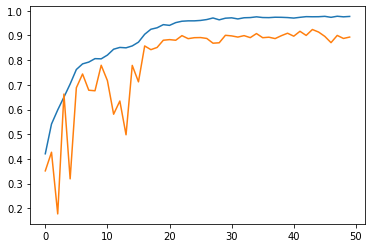

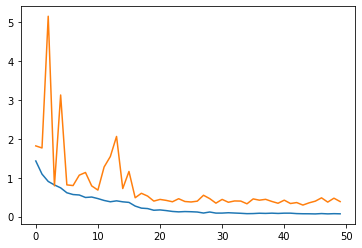

0.9242128726664809

In [50]:
plt.plot([k[-2] for k in hist])
plt.plot([k[-1] for k in hist])
plt.show()
plt.plot([k[0] for k in hist])
plt.plot([k[1] for k in hist])
plt.show()
best_acc

In [52]:
model = torch.load('exploss_more/sVGG_opt_residualexploss_lastconv_originalimgsize_noaugmentation_model.pt')

running_valloss = 0.0
running_valacc = 0.0
exp_features = []
exp_labels = []
for i,data in enumerate(test_loader):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs,_, features = model(inputs, labels)
    
    with torch.no_grad():
        exp_features.append(features.detach().cpu())
        exp_labels.append(labels.detach().cpu())

    loss = criterion(outputs, labels)
    acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

    running_valloss += (loss.item() * inputs.size(0))
    running_valacc += acc.item()

print('- Avg. val_loss: %.4f | Avg. val_acc: %.4f' % (running_valloss / len(test_loader.dataset), running_valacc / len(test_loader.dataset)))


- Avg. val_loss: 0.2669 | Avg. val_acc: 0.9259


In [53]:
exp_features = torch.cat(exp_features, axis=0).flatten(1)
exp_labels = torch.cat(exp_labels)

exp_features.size()

torch.Size([3589, 512])

(<Figure size 1080x720 with 1 Axes>, array([[ 24.09821 , -24.45374 ],
        [-15.260703, -28.080564],
        [  8.828332,  58.38623 ],
        ...,
        [ 20.829895, -20.527777],
        [-58.691803,  -0.499385],
        [ 68.28454 ,  15.345748]], dtype=float32))

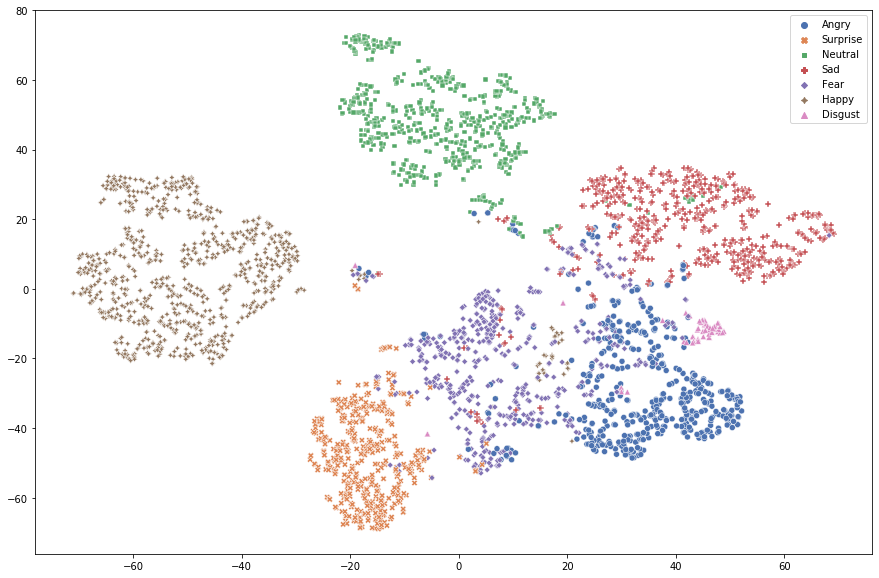

In [54]:
visualize_embedding(exp_features.numpy(), exp_labels.numpy(), label_dict=label_dict, save_path='exploss_more/sVGG_opt_residualexploss_lastconv_originalimgsize_noaugmentation_tsne.png')


### Exploss with sigmoid activation

In [ ]:
class ExpLoss(nn.Module):
    def __init__(self, depth, residual=True):
        super(ExpLoss, self).__init__()
        
        self.depth = depth
        self.residual = residual
        
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()
        
        self.fc1 = nn.Linear(depth, depth)
        self.fc2 = nn.Linear(depth, depth)
        
#         self.main_fc = nn.Linear(depth, depth)
        
        self.sim_act = nn.Sigmoid()
        self.att_act = nn.Sigmoid()
        
#         self.out_fc = nn.Sequential(nn.Linear(depth, depth),
#                                     nn.BatchNorm1d(depth),
#                                     nn.ReLU())

        self.out_fc = nn.Sequential(nn.Conv2d(depth, depth, kernel_size=1, padding=0, stride=1),
                                    nn.BatchNorm2d(depth),
                                    nn.ReLU())

        
    def forward(self, x, labels):
        batch_size, d, h, w = x.size()
        
        if self.residual:
            x_res = x
        
        x = self.avgpool(x)
        x = self.flatten(x)
        
        x1 = self.fc1(x)
        x2 = self.fc2(x)
        
        # cal sims (batchsize, depth)
        sims = torch.mm(x1, x2.permute(1,0))
        sims = sims / batch_size
        sims = self.sim_act(sims)
        mask = self.filter_mask(labels)
        att = sims * (1 - mask.to(sims.device)) # only consider sample of same labels
        
        x = torch.mm(att, x_res.reshape(batch_size, d*h*w))
        x = x.reshape(batch_size, d, h, w)
        x = self.out_fc(x)
    
        if self.residual:
            x = x + x_res
        
        return x, 0

    def filter_mask(self, labels):
        """
        zero
        """
        classes = torch.unique(labels)
        mask = torch.ones((len(labels), len(labels)))
        
        indices = [(labels == k).nonzero().flatten() for k in classes]
        lindices = [torch.combinations(k, r=2, with_replacement=True) for k in indices]
        rindices = [torch.combinations(k.flip(0), r=2, with_replacement=True) for k in indices]
        indices = [torch.cat([lindices[i], rindices[i]]) for i in range(len(lindices))]

        for k in indices:
            mask[k[:,0], k[:,1]] = 0.
            
        return mask

In [59]:
MAX_LOGSTD=10
model_path = 'exploss_more/sVGG_opt_residualexploss_sigmoid_lastconv_originalimgsize_noaugmentation_model.pt'
alpha = 1

# optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
for epoch in range(epochs):  # loop over the dataset multiple times

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0
    processed = 0.0

    # TRAIN
    model.train()
    pbar = tqdm(train_loader, position=0)
    for i, data in enumerate(pbar):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs, sim_loss, features = model(inputs, labels)
        loss = criterion(outputs, labels) + sim_loss
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()
        
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += (loss.item() * inputs.size(0))
        running_acc += acc.item()
        processed += len(inputs)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={i} Accuracy={acc.item() / inputs.size(0)}')

    print('- Avg.loss: %.4f | Avg.acc: %.4f' % (running_loss / len(train_loader.dataset), running_acc / len(train_loader.dataset)))
    avgloss = running_loss / len(train_loader.dataset)
    avgacc = running_acc / len(train_loader.dataset)

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs, sim_loss, features = model(inputs, labels)
        
        loss = criterion(outputs, labels) + sim_loss
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        running_valloss += (loss.item() * inputs.size(0))
        running_valacc += acc.item()

    print('- Avg. val_loss: %.4f | Avg. val_acc: %.4f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

    avgvalloss = running_valloss / len(val_loader.dataset)
    avgvalacc = running_valacc / len(val_loader.dataset)
    
    scheduler.step(avgvalacc)

    hist.append([avgloss, avgvalloss, avgacc, avgvalacc])
    
    if best_acc < avgvalacc:
        best_acc = avgvalacc
        torch.save(model, model_path)
        print('* Update optimal model')

print('Finished Training')


  0%|          | 0/449 [00:00<?, ?it/s]

Epoch:  1


Loss=1.4633753299713135 Batch_id=448 Accuracy=0.3783783783783784: 100%|██████████| 449/449 [00:19<00:00, 23.39it/s]

- Avg.loss: 1.4287 | Avg.acc: 0.4274



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.7228 | Avg. val_acc: 0.3441
* Update optimal model
Epoch:  2


Loss=0.867392897605896 Batch_id=448 Accuracy=0.4864864864864865: 100%|██████████| 449/449 [00:19<00:00, 23.43it/s]

- Avg.loss: 1.0880 | Avg.acc: 0.5260


- Avg. val_loss: 0.9922 | Avg. val_acc: 0.5430


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  3


Loss=0.6610774397850037 Batch_id=448 Accuracy=0.5945945945945946: 100%|██████████| 449/449 [00:19<00:00, 23.29it/s]

- Avg.loss: 0.8916 | Avg.acc: 0.6005


- Avg. val_loss: 0.9146 | Avg. val_acc: 0.5971


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  4


Loss=1.6512502431869507 Batch_id=448 Accuracy=0.43243243243243246: 100%|██████████| 449/449 [00:19<00:00, 23.35it/s]

- Avg.loss: 0.8272 | Avg.acc: 0.6379


- Avg. val_loss: 0.7605 | Avg. val_acc: 0.6651


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  5


Loss=0.7792798280715942 Batch_id=448 Accuracy=0.7027027027027027: 100%|██████████| 449/449 [00:19<00:00, 23.21it/s]

- Avg.loss: 0.7819 | Avg.acc: 0.6633



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.0874 | Avg. val_acc: 0.5798
Epoch:  6


Loss=0.3436925411224365 Batch_id=448 Accuracy=0.8108108108108109: 100%|██████████| 449/449 [00:19<00:00, 23.37it/s]

- Avg.loss: 0.6624 | Avg.acc: 0.7360



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.1405 | Avg. val_acc: 0.6018
Epoch:  7


Loss=0.595018208026886 Batch_id=448 Accuracy=0.7297297297297297: 100%|██████████| 449/449 [00:19<00:00, 23.26it/s]

- Avg.loss: 0.5662 | Avg.acc: 0.7722



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.0350 | Avg. val_acc: 0.6459
Epoch:  8


Loss=0.8186341524124146 Batch_id=448 Accuracy=0.7027027027027027: 100%|██████████| 449/449 [00:19<00:00, 23.34it/s]

- Avg.loss: 0.5512 | Avg.acc: 0.7826


- Avg. val_loss: 0.9572 | Avg. val_acc: 0.6932


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  9


Loss=1.1823652982711792 Batch_id=448 Accuracy=0.6756756756756757: 100%|██████████| 449/449 [00:19<00:00, 23.26it/s]

- Avg.loss: 0.4991 | Avg.acc: 0.8000


- Avg. val_loss: 0.8067 | Avg. val_acc: 0.7256


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  10


Loss=0.46441149711608887 Batch_id=448 Accuracy=0.8378378378378378: 100%|██████████| 449/449 [00:19<00:00, 23.26it/s]

- Avg.loss: 0.4813 | Avg.acc: 0.8146


- Avg. val_loss: 0.7424 | Avg. val_acc: 0.7328


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  11


Loss=0.24039103090763092 Batch_id=448 Accuracy=0.8918918918918919: 100%|██████████| 449/449 [00:19<00:00, 23.21it/s]

- Avg.loss: 0.4371 | Avg.acc: 0.8366



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.2602 | Avg. val_acc: 0.5709
Epoch:  12


Loss=0.3700081706047058 Batch_id=448 Accuracy=0.8648648648648649: 100%|██████████| 449/449 [00:19<00:00, 23.21it/s]

- Avg.loss: 0.4309 | Avg.acc: 0.8388


- Avg. val_loss: 0.6070 | Avg. val_acc: 0.7849


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  13


Loss=0.39180803298950195 Batch_id=448 Accuracy=0.8378378378378378: 100%|██████████| 449/449 [00:19<00:00, 23.16it/s]

- Avg.loss: 0.4096 | Avg.acc: 0.8494



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.7713 | Avg. val_acc: 0.7069
Epoch:  14


Loss=0.535624086856842 Batch_id=448 Accuracy=0.7297297297297297: 100%|██████████| 449/449 [00:19<00:00, 23.14it/s]

- Avg.loss: 0.3951 | Avg.acc: 0.8599



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 3.4138 | Avg. val_acc: 0.5305
Epoch:  15


Loss=0.395662784576416 Batch_id=448 Accuracy=0.9459459459459459: 100%|██████████| 449/449 [00:19<00:00, 23.23it/s]

- Avg.loss: 0.3383 | Avg.acc: 0.8818


- Avg. val_loss: 0.5250 | Avg. val_acc: 0.8242


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  16


Loss=0.361270934343338 Batch_id=448 Accuracy=0.8108108108108109: 100%|██████████| 449/449 [00:19<00:00, 23.17it/s]

- Avg.loss: 0.3562 | Avg.acc: 0.8873



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.6948 | Avg. val_acc: 0.7763
Epoch:  17


Loss=0.15407204627990723 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:19<00:00, 23.29it/s]

- Avg.loss: 0.2952 | Avg.acc: 0.9001



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.9581 | Avg. val_acc: 0.6985
Epoch:  18


Loss=0.4346148371696472 Batch_id=448 Accuracy=0.8648648648648649: 100%|██████████| 449/449 [00:19<00:00, 23.32it/s]

- Avg.loss: 0.2686 | Avg.acc: 0.9129



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 4.7721 | Avg. val_acc: 0.3561
Epoch:  19


Loss=1.3041006326675415 Batch_id=448 Accuracy=0.7837837837837838: 100%|██████████| 449/449 [00:19<00:00, 23.20it/s]

- Avg.loss: 0.2264 | Avg.acc: 0.9251



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 3.6152 | Avg. val_acc: 0.6211
Epoch:  20


Loss=0.2169126272201538 Batch_id=448 Accuracy=0.9459459459459459: 100%|██████████| 449/449 [00:19<00:00, 23.27it/s]

- Avg.loss: 0.2172 | Avg.acc: 0.9275



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.7620 | Avg. val_acc: 0.8011
Epoch:  21


Loss=1.0596957206726074 Batch_id=448 Accuracy=0.7297297297297297: 100%|██████████| 449/449 [00:19<00:00, 23.33it/s]

- Avg.loss: 0.2189 | Avg.acc: 0.9326



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.8511 | Avg. val_acc: 0.7133
Epoch    21: reducing learning rate of group 0 to 1.0000e-04.
Epoch:  22


Loss=0.16466501355171204 Batch_id=448 Accuracy=0.8918918918918919: 100%|██████████| 449/449 [00:19<00:00, 23.25it/s]

- Avg.loss: 0.1678 | Avg.acc: 0.9467


- Avg. val_loss: 0.3306 | Avg. val_acc: 0.9016


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  23


Loss=0.0626714676618576 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:19<00:00, 23.18it/s]       

- Avg.loss: 0.1196 | Avg.acc: 0.9576



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.3648 | Avg. val_acc: 0.9003
Epoch:  24


Loss=0.001311033614911139 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:19<00:00, 23.21it/s]     

- Avg.loss: 0.1112 | Avg.acc: 0.9643



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.3285 | Avg. val_acc: 0.8938
Epoch:  25


Loss=0.03746630623936653 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:19<00:00, 23.18it/s]      

- Avg.loss: 0.0984 | Avg.acc: 0.9699



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.4632 | Avg. val_acc: 0.8746
Epoch:  26


Loss=0.1026960164308548 Batch_id=448 Accuracy=0.9459459459459459: 100%|██████████| 449/449 [00:19<00:00, 23.17it/s]

- Avg.loss: 0.0968 | Avg.acc: 0.9699



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.4595 | Avg. val_acc: 0.8891
Epoch:  27


Loss=0.10038420557975769 Batch_id=448 Accuracy=0.9459459459459459: 100%|██████████| 449/449 [00:19<00:00, 23.16it/s]

- Avg.loss: 0.0858 | Avg.acc: 0.9725



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.5313 | Avg. val_acc: 0.8624
Epoch:  28


Loss=0.35378873348236084 Batch_id=448 Accuracy=0.8378378378378378: 100%|██████████| 449/449 [00:19<00:00, 23.20it/s]

- Avg.loss: 0.0826 | Avg.acc: 0.9757



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.3627 | Avg. val_acc: 0.8927
Epoch    28: reducing learning rate of group 0 to 1.0000e-05.
Epoch:  29


Loss=0.005654220003634691 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:19<00:00, 23.25it/s]     

- Avg.loss: 0.0776 | Avg.acc: 0.9737



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.4374 | Avg. val_acc: 0.8716
Epoch:  30


Loss=0.004253468941897154 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:19<00:00, 23.07it/s]     

- Avg.loss: 0.0682 | Avg.acc: 0.9773


- Avg. val_loss: 0.3162 | Avg. val_acc: 0.9064


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  31


Loss=0.031716037541627884 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:19<00:00, 23.14it/s]     

- Avg.loss: 0.0695 | Avg.acc: 0.9783



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.4224 | Avg. val_acc: 0.8916
Epoch:  32


Loss=0.22957271337509155 Batch_id=448 Accuracy=0.9459459459459459: 100%|██████████| 449/449 [00:19<00:00, 23.31it/s]

- Avg.loss: 0.0839 | Avg.acc: 0.9740



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.5065 | Avg. val_acc: 0.8877
Epoch:  33


Loss=0.003299573203548789 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:19<00:00, 23.24it/s]     

- Avg.loss: 0.0747 | Avg.acc: 0.9739



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.4767 | Avg. val_acc: 0.8916
Epoch:  34


Loss=0.30361366271972656 Batch_id=448 Accuracy=0.8648648648648649: 100%|██████████| 449/449 [00:19<00:00, 23.31it/s]

- Avg.loss: 0.0810 | Avg.acc: 0.9751



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.4951 | Avg. val_acc: 0.8905
Epoch:  35


Loss=0.27681609988212585 Batch_id=448 Accuracy=0.8918918918918919: 100%|██████████| 449/449 [00:19<00:00, 23.22it/s]

- Avg.loss: 0.0795 | Avg.acc: 0.9744



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.4461 | Avg. val_acc: 0.8846
Epoch:  36


Loss=0.003687887918204069 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:19<00:00, 23.28it/s]     

- Avg.loss: 0.0953 | Avg.acc: 0.9699



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.4703 | Avg. val_acc: 0.8668
Epoch    36: reducing learning rate of group 0 to 1.0000e-06.
Epoch:  37


Loss=0.49005326628685 Batch_id=448 Accuracy=0.7027027027027027: 100%|██████████| 449/449 [00:19<00:00, 23.24it/s]

- Avg.loss: 0.0718 | Avg.acc: 0.9757



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.4087 | Avg. val_acc: 0.8952
Epoch:  38


Loss=0.0084388954564929 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:19<00:00, 23.14it/s]       

- Avg.loss: 0.0731 | Avg.acc: 0.9754



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.3501 | Avg. val_acc: 0.8911
Epoch:  39


Loss=0.015073233284056187 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:19<00:00, 23.21it/s]     

- Avg.loss: 0.0776 | Avg.acc: 0.9763



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.4307 | Avg. val_acc: 0.8936
Epoch:  40


Loss=0.04340481013059616 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:19<00:00, 23.21it/s]      

- Avg.loss: 0.0812 | Avg.acc: 0.9751



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.4862 | Avg. val_acc: 0.8799
Epoch:  41


Loss=1.621264934539795 Batch_id=448 Accuracy=0.6756756756756757: 100%|██████████| 449/449 [00:19<00:00, 23.26it/s]

- Avg.loss: 0.0686 | Avg.acc: 0.9788



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.5082 | Avg. val_acc: 0.8860
Epoch:  42


Loss=0.30140799283981323 Batch_id=448 Accuracy=0.918918918918919: 100%|██████████| 449/449 [00:19<00:00, 23.24it/s]

- Avg.loss: 0.0820 | Avg.acc: 0.9744



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.4481 | Avg. val_acc: 0.8874
Epoch    42: reducing learning rate of group 0 to 1.0000e-07.
Epoch:  43


Loss=1.045461654663086 Batch_id=448 Accuracy=0.7837837837837838: 100%|██████████| 449/449 [00:19<00:00, 23.21it/s]

- Avg.loss: 0.0874 | Avg.acc: 0.9741



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.4081 | Avg. val_acc: 0.8930
Epoch:  44


Loss=0.0038573984056711197 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:19<00:00, 23.21it/s]    

- Avg.loss: 0.0832 | Avg.acc: 0.9723



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.4879 | Avg. val_acc: 0.8966
Epoch:  45


Loss=0.48419344425201416 Batch_id=448 Accuracy=0.8918918918918919: 100%|██████████| 449/449 [00:19<00:00, 23.22it/s]

- Avg.loss: 0.0809 | Avg.acc: 0.9749



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.4859 | Avg. val_acc: 0.8911
Epoch:  46


Loss=0.10120490938425064 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:19<00:00, 23.13it/s]

- Avg.loss: 0.0903 | Avg.acc: 0.9726



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.3175 | Avg. val_acc: 0.9028
Epoch:  47


Loss=0.24128535389900208 Batch_id=448 Accuracy=0.918918918918919: 100%|██████████| 449/449 [00:19<00:00, 23.32it/s]

- Avg.loss: 0.0735 | Avg.acc: 0.9754



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.5461 | Avg. val_acc: 0.8830
Epoch:  48


Loss=0.026208849623799324 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:19<00:00, 23.31it/s]     

- Avg.loss: 0.0802 | Avg.acc: 0.9749



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.4054 | Avg. val_acc: 0.9025
Epoch    48: reducing learning rate of group 0 to 1.0000e-08.
Epoch:  49


Loss=0.23118668794631958 Batch_id=448 Accuracy=0.918918918918919: 100%|██████████| 449/449 [00:19<00:00, 23.28it/s]

- Avg.loss: 0.0628 | Avg.acc: 0.9787



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.4393 | Avg. val_acc: 0.8905
Epoch:  50


Loss=0.33270514011383057 Batch_id=448 Accuracy=0.8918918918918919: 100%|██████████| 449/449 [00:19<00:00, 23.25it/s]

- Avg.loss: 0.0674 | Avg.acc: 0.9783


- Avg. val_loss: 0.3493 | Avg. val_acc: 0.9072
* Update optimal model
Finished Training


In [60]:
pickle.dump(hist, open('exploss_more/sVGG_opt_residualexploss_sigmoid_lastconv_originalimgsize_noaugmentation_hist.hdf5', 'wb'))


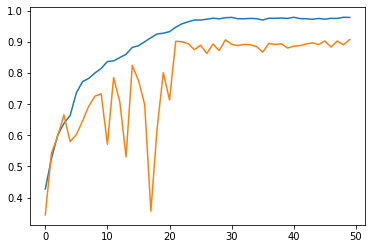

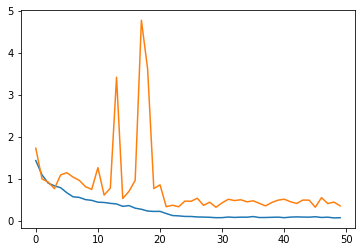

0.9072164948453608

In [61]:
plt.plot([k[-2] for k in hist])
plt.plot([k[-1] for k in hist])
plt.show()
plt.plot([k[0] for k in hist])
plt.plot([k[1] for k in hist])
plt.show()
best_acc

In [62]:
model = torch.load('exploss_more/sVGG_opt_residualexploss_sigmoid_lastconv_originalimgsize_noaugmentation_model.pt')

running_valloss = 0.0
running_valacc = 0.0
exp_features = []
exp_labels = []
for i,data in enumerate(test_loader):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs,_, features = model(inputs, labels)
    
    with torch.no_grad():
        exp_features.append(features.detach().cpu())
        exp_labels.append(labels.detach().cpu())

    loss = criterion(outputs, labels)
    acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

    running_valloss += (loss.item() * inputs.size(0))
    running_valacc += acc.item()

print('- Avg. val_loss: %.4f | Avg. val_acc: %.4f' % (running_valloss / len(test_loader.dataset), running_valacc / len(test_loader.dataset)))


- Avg. val_loss: 0.2977 | Avg. val_acc: 0.9217


In [63]:
exp_features = torch.cat(exp_features, axis=0).flatten(1)
exp_labels = torch.cat(exp_labels)

exp_features.size()

torch.Size([3589, 512])

(<Figure size 1080x720 with 1 Axes>, array([[ 13.59957  , -17.870892 ],
        [-15.611757 , -41.696335 ],
        [-62.744415 ,   8.329299 ],
        ...,
        [ 18.461996 ,   5.616259 ],
        [ 15.461216 ,   2.430758 ],
        [ 13.280065 ,   4.7112823]], dtype=float32))

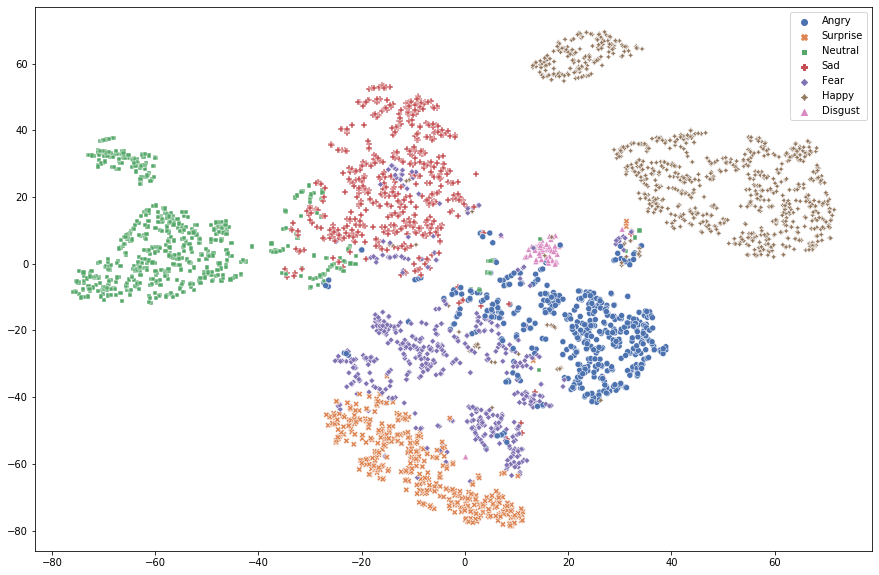

In [64]:
visualize_embedding(exp_features.numpy(), exp_labels.numpy(), label_dict=label_dict, save_path='exploss_more/sVGG_opt_residualexploss_sigmoid_lastconv_originalimgsize_noaugmentation_tsne.png')


### Exploss with L2 norm all

In [103]:
class ExpLoss(nn.Module):
    def __init__(self, depth, residual=True):
        super(ExpLoss, self).__init__()
        
        self.depth = depth
        self.residual = residual
        
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()
        
        self.fc1 = nn.Linear(depth, depth)
        self.fc2 = nn.Linear(depth, depth)
        
#         self.main_fc = nn.Linear(depth, depth)
        
        self.sim_act = nn.Sigmoid()
        self.att_act = nn.Sigmoid()
        
#         self.out_fc = nn.Sequential(nn.Linear(depth, depth),
#                                     nn.BatchNorm1d(depth),
#                                     nn.ReLU())

        self.out_fc = nn.Sequential(nn.Conv2d(depth, depth, kernel_size=1, padding=0, stride=1),
                                    nn.BatchNorm2d(depth),
                                    nn.ReLU())

        
    def forward(self, x, labels):
        batch_size, d, h, w = x.size()
        
        if self.residual:
            x_res = x
        
        x = self.avgpool(x)
        x = self.flatten(x)
        
        x1 = self.fc1(x)
        x2 = self.fc2(x)
        
        # cal sims (batchsize, depth)
        sims = torch.mm(x1, x2.permute(1,0))
        sims = sims / batch_size
        mask = self.filter_mask(labels)
        att = sims * (1 - mask.to(sims.device)) # only consider sample of same labels
        att = att / att.norm(2)
        x = torch.mm(att, x_res.reshape(batch_size, d*h*w))
        x = x.reshape(batch_size, d, h, w)
        x = self.out_fc(x)
    
        if self.residual:
            x = x + x_res
        
        return x, 0

    def filter_mask(self, labels):
        """
        zero
        """
        classes = torch.unique(labels)
        mask = torch.ones((len(labels), len(labels)))
        
        indices = [(labels == k).nonzero().flatten() for k in classes]
        lindices = [torch.combinations(k, r=2, with_replacement=True) for k in indices]
        rindices = [torch.combinations(k.flip(0), r=2, with_replacement=True) for k in indices]
        indices = [torch.cat([lindices[i], rindices[i]]) for i in range(len(lindices))]

        for k in indices:
            mask[k[:,0], k[:,1]] = 0.
            
        return mask

In [104]:
sample_model = vgg16_bn(pretrained=False)
model = sVGG_exp(features=sample_model.features[:34], in_features_classifier=512, n_classes=7)

In [105]:
lr = 0.001
epochs = 50
device = torch.device('cuda')

model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=5, verbose=True)

best_acc = 0.0
hist = []

In [76]:
MAX_LOGSTD=10
model_path = 'exploss_more/sVGG_opt_residualexploss_l2norm_lastconv_originalimgsize_noaugmentation_model.pt'
alpha = 1

# optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
for epoch in range(epochs):  # loop over the dataset multiple times

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0
    processed = 0.0

    # TRAIN
    model.train()
    pbar = tqdm(train_loader, position=0)
    for i, data in enumerate(pbar):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs, sim_loss, features = model(inputs, labels)
        loss = criterion(outputs, labels) + sim_loss
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()
        
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += (loss.item() * inputs.size(0))
        running_acc += acc.item()
        processed += len(inputs)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={i} Accuracy={acc.item() / inputs.size(0)}')

    print('- Avg.loss: %.4f | Avg.acc: %.4f' % (running_loss / len(train_loader.dataset), running_acc / len(train_loader.dataset)))
    avgloss = running_loss / len(train_loader.dataset)
    avgacc = running_acc / len(train_loader.dataset)

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs, sim_loss, features = model(inputs, labels)
        
        loss = criterion(outputs, labels) + sim_loss
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        running_valloss += (loss.item() * inputs.size(0))
        running_valacc += acc.item()

    print('- Avg. val_loss: %.4f | Avg. val_acc: %.4f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

    avgvalloss = running_valloss / len(val_loader.dataset)
    avgvalacc = running_valacc / len(val_loader.dataset)
    
    scheduler.step(avgvalacc)

    hist.append([avgloss, avgvalloss, avgacc, avgvalacc])
    
    if best_acc < avgvalacc:
        best_acc = avgvalacc
        torch.save(model, model_path)
        print('* Update optimal model')

print('Finished Training')


  0%|          | 0/449 [00:00<?, ?it/s]

Epoch:  1


Loss=1.0017894506454468 Batch_id=448 Accuracy=0.6216216216216216: 100%|██████████| 449/449 [00:19<00:00, 22.99it/s]

- Avg.loss: 1.4170 | Avg.acc: 0.4319



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 8.9024 | Avg. val_acc: 0.1215
* Update optimal model
Epoch:  2


Loss=1.2037110328674316 Batch_id=448 Accuracy=0.4864864864864865: 100%|██████████| 449/449 [00:19<00:00, 23.22it/s]

- Avg.loss: 1.0231 | Avg.acc: 0.5584


- Avg. val_loss: 2.4986 | Avg. val_acc: 0.3472
* Update optimal model
Epoch:  3


Loss=0.9370473027229309 Batch_id=448 Accuracy=0.5675675675675675: 100%|██████████| 449/449 [00:19<00:00, 23.17it/s]

- Avg.loss: 0.9130 | Avg.acc: 0.5947



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 3.1796 | Avg. val_acc: 0.3307
Epoch:  4


Loss=0.5773879289627075 Batch_id=448 Accuracy=0.6216216216216216: 100%|██████████| 449/449 [00:19<00:00, 23.10it/s]

- Avg.loss: 0.8458 | Avg.acc: 0.6123


- Avg. val_loss: 1.1490 | Avg. val_acc: 0.5428


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  5


Loss=0.7028909921646118 Batch_id=448 Accuracy=0.7027027027027027: 100%|██████████| 449/449 [00:19<00:00, 23.09it/s]

- Avg.loss: 0.8232 | Avg.acc: 0.6193



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.1054 | Avg. val_acc: 0.5163
Epoch:  6


Loss=1.3613173961639404 Batch_id=448 Accuracy=0.32432432432432434: 100%|██████████| 449/449 [00:19<00:00, 23.15it/s]

- Avg.loss: 0.7884 | Avg.acc: 0.6295


- Avg. val_loss: 0.9655 | Avg. val_acc: 0.5896


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  7


Loss=1.9572556018829346 Batch_id=448 Accuracy=0.35135135135135137: 100%|██████████| 449/449 [00:19<00:00, 23.09it/s]

- Avg.loss: 0.7544 | Avg.acc: 0.6421



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.1631 | Avg. val_acc: 0.5046
Epoch:  8


Loss=0.5362383723258972 Batch_id=448 Accuracy=0.6486486486486487: 100%|██████████| 449/449 [00:19<00:00, 23.13it/s]

- Avg.loss: 0.6925 | Avg.acc: 0.6628


- Avg. val_loss: 0.7641 | Avg. val_acc: 0.6509


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  9


Loss=0.8761492371559143 Batch_id=448 Accuracy=0.3783783783783784: 100%|██████████| 449/449 [00:19<00:00, 23.06it/s]

- Avg.loss: 0.7030 | Avg.acc: 0.6655



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.9893 | Avg. val_acc: 0.5952
Epoch:  10


Loss=0.6649808883666992 Batch_id=448 Accuracy=0.7297297297297297: 100%|██████████| 449/449 [00:19<00:00, 23.03it/s]

- Avg.loss: 0.6617 | Avg.acc: 0.6833


- Avg. val_loss: 0.6897 | Avg. val_acc: 0.6514


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  11


Loss=0.8172256350517273 Batch_id=448 Accuracy=0.6486486486486487: 100%|██████████| 449/449 [00:19<00:00, 22.92it/s]

- Avg.loss: 0.6429 | Avg.acc: 0.6989


- Avg. val_loss: 0.7510 | Avg. val_acc: 0.6707


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  12


Loss=0.3530518412590027 Batch_id=448 Accuracy=0.8918918918918919: 100%|██████████| 449/449 [00:19<00:00, 22.95it/s]

- Avg.loss: 0.5899 | Avg.acc: 0.7480



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.0306 | Avg. val_acc: 0.6553
Epoch:  13


Loss=1.2090011835098267 Batch_id=448 Accuracy=0.7027027027027027: 100%|██████████| 449/449 [00:19<00:00, 23.05it/s]

- Avg.loss: 0.4952 | Avg.acc: 0.8187


- Avg. val_loss: 1.0966 | Avg. val_acc: 0.7275


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  14


Loss=0.7216424942016602 Batch_id=448 Accuracy=0.6756756756756757: 100%|██████████| 449/449 [00:19<00:00, 22.99it/s]

- Avg.loss: 0.4789 | Avg.acc: 0.8223



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.8569 | Avg. val_acc: 0.5603
Epoch:  15


Loss=0.3911287188529968 Batch_id=448 Accuracy=0.8648648648648649: 100%|██████████| 449/449 [00:19<00:00, 23.01it/s]

- Avg.loss: 0.4206 | Avg.acc: 0.8466


- Avg. val_loss: 0.6443 | Avg. val_acc: 0.8052


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  16


Loss=0.28639790415763855 Batch_id=448 Accuracy=0.8378378378378378: 100%|██████████| 449/449 [00:19<00:00, 22.93it/s]

- Avg.loss: 0.3588 | Avg.acc: 0.8692



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.8518 | Avg. val_acc: 0.7289
Epoch:  17


Loss=0.06888870894908905 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:19<00:00, 23.06it/s]     

- Avg.loss: 0.3397 | Avg.acc: 0.8760



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.5848 | Avg. val_acc: 0.6865
Epoch:  18


Loss=0.9436089992523193 Batch_id=448 Accuracy=0.5945945945945946: 100%|██████████| 449/449 [00:19<00:00, 23.01it/s]

- Avg.loss: 0.3326 | Avg.acc: 0.8880



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.7188 | Avg. val_acc: 0.7657
Epoch:  19


Loss=0.4706272482872009 Batch_id=448 Accuracy=0.7567567567567568: 100%|██████████| 449/449 [00:19<00:00, 23.03it/s]

- Avg.loss: 0.2880 | Avg.acc: 0.8999


- Avg. val_loss: 0.6009 | Avg. val_acc: 0.8359


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  20


Loss=2.3353500366210938 Batch_id=448 Accuracy=0.6486486486486487: 100%|██████████| 449/449 [00:19<00:00, 23.03it/s]

- Avg.loss: 0.3345 | Avg.acc: 0.8848


- Avg. val_loss: 0.4349 | Avg. val_acc: 0.8732


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  21


Loss=0.39687785506248474 Batch_id=448 Accuracy=0.7837837837837838: 100%|██████████| 449/449 [00:19<00:00, 23.02it/s]

- Avg.loss: 0.2653 | Avg.acc: 0.9115



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.6302 | Avg. val_acc: 0.8069
Epoch:  22


Loss=0.07327227294445038 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:19<00:00, 23.04it/s]

- Avg.loss: 0.2711 | Avg.acc: 0.9087



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.6983 | Avg. val_acc: 0.8061
Epoch:  23


Loss=1.9751032590866089 Batch_id=448 Accuracy=0.4594594594594595: 100%|██████████| 449/449 [00:19<00:00, 23.09it/s]

- Avg.loss: 0.2412 | Avg.acc: 0.9181



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.4671 | Avg. val_acc: 0.8381
Epoch:  24


Loss=0.19825094938278198 Batch_id=448 Accuracy=0.8918918918918919: 100%|██████████| 449/449 [00:19<00:00, 23.02it/s]

- Avg.loss: 0.2318 | Avg.acc: 0.9193



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.7967 | Avg. val_acc: 0.7885
Epoch:  25


Loss=0.5762662887573242 Batch_id=448 Accuracy=0.918918918918919: 100%|██████████| 449/449 [00:19<00:00, 23.01it/s]

- Avg.loss: 0.2442 | Avg.acc: 0.9165



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.0468 | Avg. val_acc: 0.7328
Epoch:  26


Loss=0.2070578783750534 Batch_id=448 Accuracy=0.9459459459459459: 100%|██████████| 449/449 [00:19<00:00, 23.12it/s]

- Avg.loss: 0.2122 | Avg.acc: 0.9305



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.6182 | Avg. val_acc: 0.8192
Epoch    26: reducing learning rate of group 0 to 1.0000e-04.
Epoch:  27


Loss=0.00600203312933445 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:19<00:00, 23.02it/s]      

- Avg.loss: 0.1521 | Avg.acc: 0.9508


- Avg. val_loss: 0.4058 | Avg. val_acc: 0.8966


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  28


Loss=2.128113269805908 Batch_id=448 Accuracy=0.5135135135135135: 100%|██████████| 449/449 [00:19<00:00, 23.02it/s]

- Avg.loss: 0.1025 | Avg.acc: 0.9689


- Avg. val_loss: 0.3904 | Avg. val_acc: 0.9016


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  29


Loss=0.016925308853387833 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:19<00:00, 23.06it/s]     

- Avg.loss: 0.0923 | Avg.acc: 0.9702


- Avg. val_loss: 0.3449 | Avg. val_acc: 0.9133


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  30


Loss=1.246401309967041 Batch_id=448 Accuracy=0.8108108108108109: 100%|██████████| 449/449 [00:19<00:00, 23.05it/s]

- Avg.loss: 0.0986 | Avg.acc: 0.9683



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.3410 | Avg. val_acc: 0.9044
Epoch:  31


Loss=0.14505138993263245 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:19<00:00, 23.00it/s]

- Avg.loss: 0.0762 | Avg.acc: 0.9770


- Avg. val_loss: 0.3462 | Avg. val_acc: 0.9142


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  32


Loss=0.16862747073173523 Batch_id=448 Accuracy=0.9459459459459459: 100%|██████████| 449/449 [00:19<00:00, 23.05it/s]

- Avg.loss: 0.0786 | Avg.acc: 0.9757



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.3675 | Avg. val_acc: 0.8997
Epoch:  33


Loss=0.1538211852312088 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:19<00:00, 23.03it/s]

- Avg.loss: 0.0712 | Avg.acc: 0.9774



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.3897 | Avg. val_acc: 0.8961
Epoch:  34


Loss=0.019785260781645775 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:19<00:00, 23.08it/s]     

- Avg.loss: 0.0755 | Avg.acc: 0.9777



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.3718 | Avg. val_acc: 0.9042
Epoch:  35


Loss=0.048347748816013336 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:19<00:00, 23.03it/s]

- Avg.loss: 0.0972 | Avg.acc: 0.9711



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.3421 | Avg. val_acc: 0.9044
Epoch:  36


Loss=0.2962740957736969 Batch_id=448 Accuracy=0.918918918918919: 100%|██████████| 449/449 [00:19<00:00, 23.09it/s]

- Avg.loss: 0.0708 | Avg.acc: 0.9776



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.3388 | Avg. val_acc: 0.9086
Epoch:  37


Loss=0.03841158747673035 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:19<00:00, 23.14it/s]

- Avg.loss: 0.0825 | Avg.acc: 0.9721



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.4132 | Avg. val_acc: 0.8830
Epoch    37: reducing learning rate of group 0 to 1.0000e-05.
Epoch:  38


Loss=0.011883482336997986 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:19<00:00, 23.02it/s]     


- Avg.loss: 0.0799 | Avg.acc: 0.9740


  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.3389 | Avg. val_acc: 0.9033
Epoch:  39


Loss=0.5471633076667786 Batch_id=448 Accuracy=0.8648648648648649: 100%|██████████| 449/449 [00:19<00:00, 22.95it/s]

- Avg.loss: 0.0580 | Avg.acc: 0.9797



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.3485 | Avg. val_acc: 0.9125
Epoch:  40


Loss=1.1097519397735596 Batch_id=448 Accuracy=0.7567567567567568: 100%|██████████| 449/449 [00:19<00:00, 23.07it/s]

- Avg.loss: 0.0729 | Avg.acc: 0.9769


- Avg. val_loss: 0.3245 | Avg. val_acc: 0.9164


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  41


Loss=0.023052530363202095 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:19<00:00, 23.02it/s]     

- Avg.loss: 0.0802 | Avg.acc: 0.9764



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.3216 | Avg. val_acc: 0.9117
Epoch:  42


Loss=0.04677746444940567 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:19<00:00, 23.03it/s]      

- Avg.loss: 0.0695 | Avg.acc: 0.9783



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.3287 | Avg. val_acc: 0.9128
Epoch:  43


Loss=0.22661547362804413 Batch_id=448 Accuracy=0.918918918918919: 100%|██████████| 449/449 [00:19<00:00, 23.00it/s]

- Avg.loss: 0.0560 | Avg.acc: 0.9816



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.3232 | Avg. val_acc: 0.9150
Epoch:  44


Loss=0.02197987586259842 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:19<00:00, 23.07it/s]      

- Avg.loss: 0.0495 | Avg.acc: 0.9854



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.3885 | Avg. val_acc: 0.9120
Epoch:  45


Loss=1.1102205514907837 Batch_id=448 Accuracy=0.8378378378378378: 100%|██████████| 449/449 [00:19<00:00, 23.01it/s]

- Avg.loss: 0.0686 | Avg.acc: 0.9804



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.3344 | Avg. val_acc: 0.9114
Epoch:  46


Loss=0.10260947793722153 Batch_id=448 Accuracy=0.918918918918919: 100%|██████████| 449/449 [00:19<00:00, 23.04it/s]

- Avg.loss: 0.0576 | Avg.acc: 0.9820


- Avg. val_loss: 0.3304 | Avg. val_acc: 0.9192


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  47


Loss=0.07177840918302536 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:19<00:00, 23.00it/s]      

- Avg.loss: 0.0633 | Avg.acc: 0.9811



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.3251 | Avg. val_acc: 0.9181
Epoch:  48


Loss=0.04961731284856796 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:19<00:00, 23.00it/s]      

- Avg.loss: 0.0632 | Avg.acc: 0.9794



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.3257 | Avg. val_acc: 0.9075
Epoch:  49


Loss=0.07013104856014252 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:19<00:00, 23.03it/s]

- Avg.loss: 0.0651 | Avg.acc: 0.9790



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.3243 | Avg. val_acc: 0.9111
Epoch:  50


Loss=0.04149702936410904 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:19<00:00, 23.04it/s]

- Avg.loss: 0.0532 | Avg.acc: 0.9827


- Avg. val_loss: 0.3394 | Avg. val_acc: 0.9192
Finished Training


In [77]:
pickle.dump(hist, open('exploss_more/sVGG_opt_residualexploss_l2norm_lastconv_originalimgsize_noaugmentation_hist.hdf5', 'wb'))


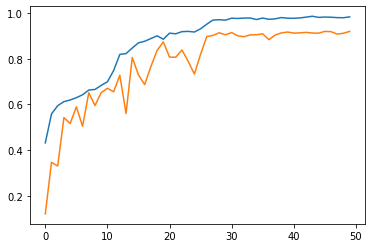

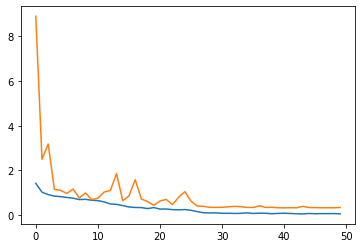

0.9191975480635275

In [78]:
plt.plot([k[-2] for k in hist])
plt.plot([k[-1] for k in hist])
plt.show()
plt.plot([k[0] for k in hist])
plt.plot([k[1] for k in hist])
plt.show()
best_acc

In [79]:
model = torch.load('exploss_more/sVGG_opt_residualexploss_l2norm_lastconv_originalimgsize_noaugmentation_model.pt')

running_valloss = 0.0
running_valacc = 0.0
exp_features = []
exp_labels = []
for i,data in enumerate(test_loader):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs,_, features = model(inputs, labels)
    
    with torch.no_grad():
        exp_features.append(features.detach().cpu())
        exp_labels.append(labels.detach().cpu())

    loss = criterion(outputs, labels)
    acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

    running_valloss += (loss.item() * inputs.size(0))
    running_valacc += acc.item()

print('- Avg. val_loss: %.4f | Avg. val_acc: %.4f' % (running_valloss / len(test_loader.dataset), running_valacc / len(test_loader.dataset)))


- Avg. val_loss: 0.2895 | Avg. val_acc: 0.9175


In [80]:
exp_features = torch.cat(exp_features, axis=0).flatten(1)
exp_labels = torch.cat(exp_labels)

exp_features.size()

torch.Size([3589, 512])

(<Figure size 1080x720 with 1 Axes>, array([[-44.60488   ,  22.737167  ],
        [-29.799582  , -27.88311   ],
        [ 18.276098  ,  74.86746   ],
        ...,
        [  1.180433  ,  -3.7248442 ],
        [  9.584437  , -45.145844  ],
        [ 61.16844   ,  -0.89501834]], dtype=float32))

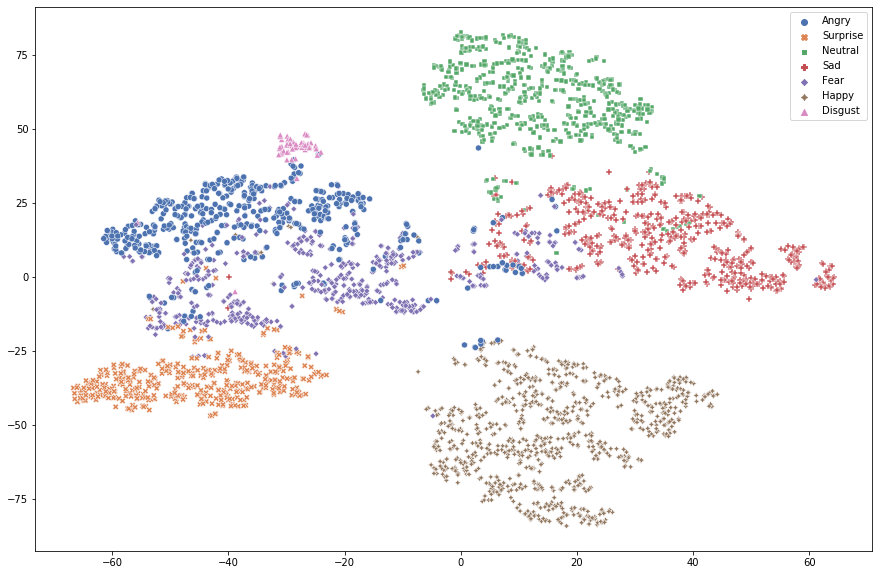

In [81]:
visualize_embedding(exp_features.numpy(), exp_labels.numpy(), label_dict=label_dict, save_path='exploss_more/sVGG_opt_residualexploss_l2norm_lastconv_originalimgsize_noaugmentation_tsne.png')


### L2 norm after masking

In [106]:
MAX_LOGSTD=10
model_path = 'exploss_more/sVGG_opt_residualexploss_l2normaftermask_lastconv_originalimgsize_noaugmentation_model.pt'
alpha = 1

# optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
for epoch in range(epochs):  # loop over the dataset multiple times

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0
    processed = 0.0

    # TRAIN
    model.train()
    pbar = tqdm(train_loader, position=0)
    for i, data in enumerate(pbar):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs, sim_loss, features = model(inputs, labels)
        loss = criterion(outputs, labels) + sim_loss
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()
        
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += (loss.item() * inputs.size(0))
        running_acc += acc.item()
        processed += len(inputs)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={i} Accuracy={acc.item() / inputs.size(0)}')

    print('- Avg.loss: %.4f | Avg.acc: %.4f' % (running_loss / len(train_loader.dataset), running_acc / len(train_loader.dataset)))
    avgloss = running_loss / len(train_loader.dataset)
    avgacc = running_acc / len(train_loader.dataset)

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs, sim_loss, features = model(inputs, labels)
        
        loss = criterion(outputs, labels) + sim_loss
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        running_valloss += (loss.item() * inputs.size(0))
        running_valacc += acc.item()

    print('- Avg. val_loss: %.4f | Avg. val_acc: %.4f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

    avgvalloss = running_valloss / len(val_loader.dataset)
    avgvalacc = running_valacc / len(val_loader.dataset)
    
    scheduler.step(avgvalacc)

    hist.append([avgloss, avgvalloss, avgacc, avgvalacc])
    
    if best_acc < avgvalacc:
        best_acc = avgvalacc
        torch.save(model, model_path)
        print('* Update optimal model')

print('Finished Training')


  0%|          | 0/449 [00:00<?, ?it/s]

Epoch:  1


Loss=0.9498785734176636 Batch_id=448 Accuracy=0.5675675675675675: 100%|██████████| 449/449 [00:19<00:00, 23.29it/s]

- Avg.loss: 1.3068 | Avg.acc: 0.4467



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.1695 | Avg. val_acc: 0.5135
* Update optimal model
Epoch:  2


Loss=1.912955641746521 Batch_id=448 Accuracy=0.3783783783783784: 100%|██████████| 449/449 [00:19<00:00, 23.17it/s]

- Avg.loss: 1.0113 | Avg.acc: 0.5691


- Avg. val_loss: 1.1779 | Avg. val_acc: 0.5779


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  3


Loss=0.5500694513320923 Batch_id=448 Accuracy=0.7837837837837838: 100%|██████████| 449/449 [00:19<00:00, 23.05it/s]

- Avg.loss: 0.8940 | Avg.acc: 0.6336


- Avg. val_loss: 0.8572 | Avg. val_acc: 0.6447


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  4


Loss=0.8449122309684753 Batch_id=448 Accuracy=0.6486486486486487: 100%|██████████| 449/449 [00:19<00:00, 23.08it/s]

- Avg.loss: 0.7954 | Avg.acc: 0.6774


- Avg. val_loss: 0.8614 | Avg. val_acc: 0.6843


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  5


Loss=0.844609260559082 Batch_id=448 Accuracy=0.5675675675675675: 100%|██████████| 449/449 [00:19<00:00, 23.08it/s]

- Avg.loss: 0.7561 | Avg.acc: 0.7142



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.6566 | Avg. val_acc: 0.4653
Epoch:  6


Loss=0.2627762258052826 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:19<00:00, 23.04it/s]

- Avg.loss: 0.6852 | Avg.acc: 0.7461


- Avg. val_loss: 0.9493 | Avg. val_acc: 0.6913


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  7


Loss=0.5796737670898438 Batch_id=448 Accuracy=0.7567567567567568: 100%|██████████| 449/449 [00:19<00:00, 22.99it/s]

- Avg.loss: 0.5921 | Avg.acc: 0.7788


- Avg. val_loss: 0.9118 | Avg. val_acc: 0.6916


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  8


Loss=0.7387098073959351 Batch_id=448 Accuracy=0.7567567567567568: 100%|██████████| 449/449 [00:19<00:00, 22.97it/s]

- Avg.loss: 0.5713 | Avg.acc: 0.7871


- Avg. val_loss: 0.8325 | Avg. val_acc: 0.7189


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  9


Loss=0.5074273943901062 Batch_id=448 Accuracy=0.7027027027027027: 100%|██████████| 449/449 [00:19<00:00, 22.97it/s]

- Avg.loss: 0.5363 | Avg.acc: 0.8024


- Avg. val_loss: 0.6524 | Avg. val_acc: 0.7682


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  10


Loss=1.2424644231796265 Batch_id=448 Accuracy=0.5405405405405406: 100%|██████████| 449/449 [00:19<00:00, 23.04it/s]

- Avg.loss: 0.5187 | Avg.acc: 0.8127



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.1931 | Avg. val_acc: 0.5901
Epoch:  11


Loss=0.8191569447517395 Batch_id=448 Accuracy=0.6756756756756757: 100%|██████████| 449/449 [00:19<00:00, 22.97it/s]

- Avg.loss: 0.4918 | Avg.acc: 0.8124



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.7952 | Avg. val_acc: 0.7013
Epoch:  12


Loss=0.34707483649253845 Batch_id=448 Accuracy=0.8918918918918919: 100%|██████████| 449/449 [00:19<00:00, 23.07it/s]

- Avg.loss: 0.4494 | Avg.acc: 0.8348



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.7138 | Avg. val_acc: 0.7579
Epoch:  13


Loss=0.3544362485408783 Batch_id=448 Accuracy=0.8648648648648649: 100%|██████████| 449/449 [00:19<00:00, 23.10it/s]

- Avg.loss: 0.4143 | Avg.acc: 0.8438



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.4253 | Avg. val_acc: 0.5932
Epoch:  14


Loss=0.3336438238620758 Batch_id=448 Accuracy=0.8918918918918919: 100%|██████████| 449/449 [00:19<00:00, 22.97it/s]

- Avg.loss: 0.4032 | Avg.acc: 0.8562



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.7749 | Avg. val_acc: 0.7373
Epoch:  15


Loss=1.0394926071166992 Batch_id=448 Accuracy=0.5675675675675675: 100%|██████████| 449/449 [00:19<00:00, 22.98it/s]

- Avg.loss: 0.3871 | Avg.acc: 0.8572


- Avg. val_loss: 0.5316 | Avg. val_acc: 0.8005


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  16


Loss=0.7591665387153625 Batch_id=448 Accuracy=0.9459459459459459: 100%|██████████| 449/449 [00:19<00:00, 23.04it/s]

- Avg.loss: 0.3459 | Avg.acc: 0.8729



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.8068 | Avg. val_acc: 0.7707
Epoch:  17


Loss=0.40240660309791565 Batch_id=448 Accuracy=0.8648648648648649: 100%|██████████| 449/449 [00:19<00:00, 22.98it/s]

- Avg.loss: 0.3368 | Avg.acc: 0.8774



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.8328 | Avg. val_acc: 0.7710
Epoch:  18


Loss=1.3042176961898804 Batch_id=448 Accuracy=0.6756756756756757: 100%|██████████| 449/449 [00:19<00:00, 22.98it/s]

- Avg.loss: 0.3168 | Avg.acc: 0.8928



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.8855 | Avg. val_acc: 0.7183
Epoch:  19


Loss=0.14993777871131897 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:19<00:00, 22.95it/s]      

- Avg.loss: 0.2886 | Avg.acc: 0.8979


- Avg. val_loss: 0.6558 | Avg. val_acc: 0.8055


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  20


Loss=0.4576019048690796 Batch_id=448 Accuracy=0.8918918918918919: 100%|██████████| 449/449 [00:19<00:00, 22.90it/s]

- Avg.loss: 0.2630 | Avg.acc: 0.9118



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.2191 | Avg. val_acc: 0.7225
Epoch:  21


Loss=0.0461517870426178 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:19<00:00, 23.01it/s]       

- Avg.loss: 0.2816 | Avg.acc: 0.9070


- Avg. val_loss: 0.6487 | Avg. val_acc: 0.8256


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  22


Loss=0.6735211610794067 Batch_id=448 Accuracy=0.7027027027027027: 100%|██████████| 449/449 [00:19<00:00, 22.85it/s]

- Avg.loss: 0.2801 | Avg.acc: 0.9091


- Avg. val_loss: 0.5985 | Avg. val_acc: 0.8412


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  23


Loss=0.8123308420181274 Batch_id=448 Accuracy=0.6216216216216216: 100%|██████████| 449/449 [00:19<00:00, 22.98it/s]

- Avg.loss: 0.2491 | Avg.acc: 0.9197


- Avg. val_loss: 0.4479 | Avg. val_acc: 0.8462


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  24


Loss=0.5475828647613525 Batch_id=448 Accuracy=0.8378378378378378: 100%|██████████| 449/449 [00:19<00:00, 23.01it/s]

- Avg.loss: 0.2220 | Avg.acc: 0.9286



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.6372 | Avg. val_acc: 0.7768
Epoch:  25


Loss=0.02190273255109787 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:19<00:00, 23.02it/s]      

- Avg.loss: 0.1959 | Avg.acc: 0.9376



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.6553 | Avg. val_acc: 0.8270
Epoch:  26


Loss=0.22285518050193787 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:19<00:00, 23.01it/s]

- Avg.loss: 0.2010 | Avg.acc: 0.9355



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.5259 | Avg. val_acc: 0.6743
Epoch:  27


Loss=0.04816732928156853 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:19<00:00, 23.01it/s]      

- Avg.loss: 0.1974 | Avg.acc: 0.9344


- Avg. val_loss: 0.4137 | Avg. val_acc: 0.8738


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  28


Loss=0.21848374605178833 Batch_id=448 Accuracy=0.8648648648648649: 100%|██████████| 449/449 [00:19<00:00, 22.98it/s]

- Avg.loss: 0.1693 | Avg.acc: 0.9464



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.3909 | Avg. val_acc: 0.8671
Epoch:  29


Loss=0.07471726089715958 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:19<00:00, 23.00it/s]      

- Avg.loss: 0.1717 | Avg.acc: 0.9475



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.8961 | Avg. val_acc: 0.7885
Epoch:  30


Loss=0.33348196744918823 Batch_id=448 Accuracy=0.8648648648648649: 100%|██████████| 449/449 [00:19<00:00, 23.07it/s]

- Avg.loss: 0.1885 | Avg.acc: 0.9420


- Avg. val_loss: 0.3646 | Avg. val_acc: 0.8877


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  31


Loss=0.02511029876768589 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:19<00:00, 22.88it/s]      

- Avg.loss: 0.1563 | Avg.acc: 0.9497



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.3845 | Avg. val_acc: 0.8621
Epoch:  32


Loss=0.08087654411792755 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:19<00:00, 22.95it/s]

- Avg.loss: 0.1515 | Avg.acc: 0.9523



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.8866 | Avg. val_acc: 0.7751
Epoch:  33


Loss=0.2944127321243286 Batch_id=448 Accuracy=0.8108108108108109: 100%|██████████| 449/449 [00:19<00:00, 22.99it/s]

- Avg.loss: 0.1503 | Avg.acc: 0.9516



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.4344 | Avg. val_acc: 0.8635
Epoch:  34


Loss=0.47773757576942444 Batch_id=448 Accuracy=0.9459459459459459: 100%|██████████| 449/449 [00:19<00:00, 22.96it/s]

- Avg.loss: 0.1599 | Avg.acc: 0.9491



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.6107 | Avg. val_acc: 0.8200
Epoch:  35


Loss=0.0161142535507679 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:19<00:00, 22.94it/s]       

- Avg.loss: 0.1403 | Avg.acc: 0.9575



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.1562 | Avg. val_acc: 0.7654
Epoch:  36


Loss=0.07195767015218735 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:19<00:00, 23.02it/s]

- Avg.loss: 0.1536 | Avg.acc: 0.9507



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.9673 | Avg. val_acc: 0.7584
Epoch    36: reducing learning rate of group 0 to 1.0000e-04.
Epoch:  37


Loss=0.08614961802959442 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:19<00:00, 23.03it/s]      

- Avg.loss: 0.1065 | Avg.acc: 0.9695


- Avg. val_loss: 0.3316 | Avg. val_acc: 0.9053


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  38


Loss=0.11476407200098038 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:19<00:00, 23.07it/s]

- Avg.loss: 0.0631 | Avg.acc: 0.9796



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.3995 | Avg. val_acc: 0.8852
Epoch:  39


Loss=0.012706179171800613 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:19<00:00, 23.03it/s]     

- Avg.loss: 0.0775 | Avg.acc: 0.9770



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.4597 | Avg. val_acc: 0.8699
Epoch:  40


Loss=0.2786204218864441 Batch_id=448 Accuracy=0.918918918918919: 100%|██████████| 449/449 [00:19<00:00, 23.00it/s]

- Avg.loss: 0.0671 | Avg.acc: 0.9788



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.3187 | Avg. val_acc: 0.8927
Epoch:  41


Loss=0.07154954969882965 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:19<00:00, 22.99it/s]

- Avg.loss: 0.0711 | Avg.acc: 0.9772


- Avg. val_loss: 0.3474 | Avg. val_acc: 0.9139


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  42


Loss=0.06287963688373566 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:19<00:00, 23.06it/s]      

- Avg.loss: 0.0539 | Avg.acc: 0.9827



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.3626 | Avg. val_acc: 0.8919
Epoch:  45


Loss=0.00876073818653822 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:19<00:00, 23.05it/s]      

- Avg.loss: 0.0546 | Avg.acc: 0.9819



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.3636 | Avg. val_acc: 0.8833
Epoch:  46


Loss=0.016024166718125343 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:19<00:00, 23.11it/s]     

- Avg.loss: 0.0547 | Avg.acc: 0.9827



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.3694 | Avg. val_acc: 0.8855
Epoch:  47


Loss=0.3614320158958435 Batch_id=448 Accuracy=0.8378378378378378: 100%|██████████| 449/449 [00:19<00:00, 23.03it/s]

- Avg.loss: 0.0618 | Avg.acc: 0.9826



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.3342 | Avg. val_acc: 0.9016
Epoch    47: reducing learning rate of group 0 to 1.0000e-05.
Epoch:  48


Loss=0.2353811264038086 Batch_id=448 Accuracy=0.8648648648648649: 100%|██████████| 449/449 [00:19<00:00, 23.02it/s]

- Avg.loss: 0.0433 | Avg.acc: 0.9846



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.3882 | Avg. val_acc: 0.8858
Epoch:  49


Loss=0.005479718558490276 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:19<00:00, 22.96it/s]     

- Avg.loss: 0.0429 | Avg.acc: 0.9851



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.3584 | Avg. val_acc: 0.8897
Epoch:  50


Loss=0.010583820752799511 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:19<00:00, 23.02it/s]     

- Avg.loss: 0.0509 | Avg.acc: 0.9859


- Avg. val_loss: 0.3260 | Avg. val_acc: 0.9003
Finished Training


In [107]:
pickle.dump(hist, open('exploss_more/sVGG_opt_residualexploss_l2normaftermask_lastconv_originalimgsize_noaugmentation_hist.hdf5', 'wb'))


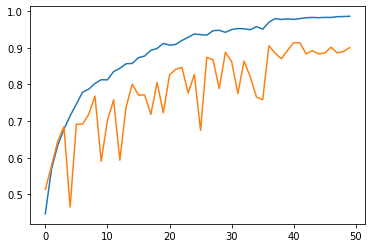

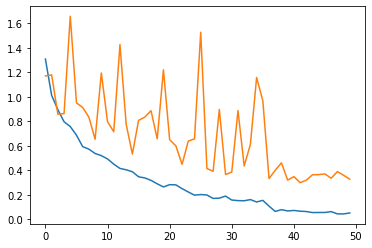

0.9139035943159655

In [108]:
plt.plot([k[-2] for k in hist])
plt.plot([k[-1] for k in hist])
plt.show()
plt.plot([k[0] for k in hist])
plt.plot([k[1] for k in hist])
plt.show()
best_acc

In [109]:
model = torch.load('exploss_more/sVGG_opt_residualexploss_l2normaftermask_lastconv_originalimgsize_noaugmentation_model.pt')

running_valloss = 0.0
running_valacc = 0.0
exp_features = []
exp_labels = []
for i,data in enumerate(test_loader):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs,_, features = model(inputs, labels)
    
    with torch.no_grad():
        exp_features.append(features.detach().cpu())
        exp_labels.append(labels.detach().cpu())

    loss = criterion(outputs, labels)
    acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

    running_valloss += (loss.item() * inputs.size(0))
    running_valacc += acc.item()

print('- Avg. val_loss: %.4f | Avg. val_acc: %.4f' % (running_valloss / len(test_loader.dataset), running_valacc / len(test_loader.dataset)))


- Avg. val_loss: 0.2502 | Avg. val_acc: 0.9211


In [110]:
exp_features = torch.cat(exp_features, axis=0).flatten(1)
exp_labels = torch.cat(exp_labels)

exp_features.size()

torch.Size([3589, 512])

(<Figure size 1080x720 with 1 Axes>, array([[-19.732382 , -59.616272 ],
        [-47.18903  ,   2.6989715],
        [ 48.86128  , -14.176762 ],
        ...,
        [  9.483231 , -15.041646 ],
        [ 20.310717 ,  72.50896  ],
        [  5.2319655, -45.348026 ]], dtype=float32))

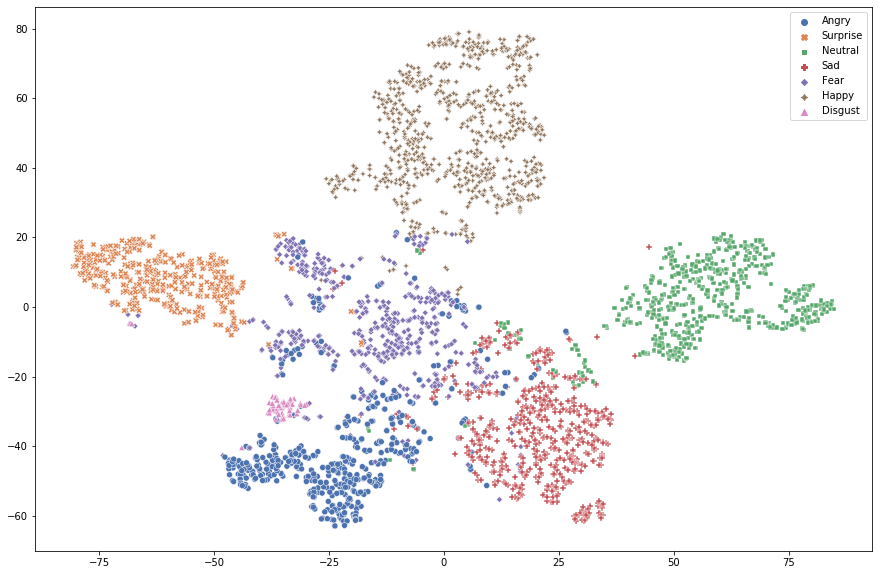

In [111]:
visualize_embedding(exp_features.numpy(), exp_labels.numpy(), label_dict=label_dict, save_path='exploss_more/sVGG_opt_residualexploss_l2normaftermask_lastconv_originalimgsize_noaugmentation_tsne.png')


### Exploss with L2 norm row

In [94]:
class ExpLoss(nn.Module):
    def __init__(self, depth, residual=True):
        super(ExpLoss, self).__init__()
        
        self.depth = depth
        self.residual = residual
        
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()
        
        self.fc1 = nn.Linear(depth, depth)
        self.fc2 = nn.Linear(depth, depth)
        
#         self.main_fc = nn.Linear(depth, depth)
        
        self.sim_act = nn.Sigmoid()
        self.att_act = nn.Sigmoid()
        
#         self.out_fc = nn.Sequential(nn.Linear(depth, depth),
#                                     nn.BatchNorm1d(depth),
#                                     nn.ReLU())

        self.out_fc = nn.Sequential(nn.Conv2d(depth, depth, kernel_size=1, padding=0, stride=1),
                                    nn.BatchNorm2d(depth),
                                    nn.ReLU())

        
    def forward(self, x, labels):
        batch_size, d, h, w = x.size()
        
        if self.residual:
            x_res = x
        
        x = self.avgpool(x)
        x = self.flatten(x)
        
        x1 = self.fc1(x)
        x2 = self.fc2(x)
        
        # cal sims (batchsize, depth)
        sims = torch.mm(x1, x2.permute(1,0))
        sims = sims / batch_size
        sims = sims / sims.norm(2, dim=1)
        mask = self.filter_mask(labels)
        att = sims * (1 - mask.to(sims.device)) # only consider sample of same labels
        
        x = torch.mm(att, x_res.reshape(batch_size, d*h*w))
        x = x.reshape(batch_size, d, h, w)
        x = self.out_fc(x)
    
        if self.residual:
            x = x + x_res
        
        return x, 0

    def filter_mask(self, labels):
        """
        zero
        """
        classes = torch.unique(labels)
        mask = torch.ones((len(labels), len(labels)))
        
        indices = [(labels == k).nonzero().flatten() for k in classes]
        lindices = [torch.combinations(k, r=2, with_replacement=True) for k in indices]
        rindices = [torch.combinations(k.flip(0), r=2, with_replacement=True) for k in indices]
        indices = [torch.cat([lindices[i], rindices[i]]) for i in range(len(lindices))]

        for k in indices:
            mask[k[:,0], k[:,1]] = 0.
            
        return mask

In [95]:
sample_model = vgg16_bn(pretrained=False)
model = sVGG_exp(features=sample_model.features[:34], in_features_classifier=512, n_classes=7)

In [96]:
lr = 0.001
epochs = 50
device = torch.device('cuda')

model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=5, verbose=True)

best_acc = 0.0
hist = []

In [97]:
MAX_LOGSTD=10
model_path = 'exploss_more/sVGG_opt_residualexploss_l2normrow_lastconv_originalimgsize_noaugmentation_model.pt'
alpha = 1

# optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
for epoch in range(epochs):  # loop over the dataset multiple times

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0
    processed = 0.0

    # TRAIN
    model.train()
    pbar = tqdm(train_loader, position=0)
    for i, data in enumerate(pbar):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs, sim_loss, features = model(inputs, labels)
        loss = criterion(outputs, labels) + sim_loss
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()
        
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += (loss.item() * inputs.size(0))
        running_acc += acc.item()
        processed += len(inputs)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={i} Accuracy={acc.item() / inputs.size(0)}')

    print('- Avg.loss: %.4f | Avg.acc: %.4f' % (running_loss / len(train_loader.dataset), running_acc / len(train_loader.dataset)))
    avgloss = running_loss / len(train_loader.dataset)
    avgacc = running_acc / len(train_loader.dataset)

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs, sim_loss, features = model(inputs, labels)
        
        loss = criterion(outputs, labels) + sim_loss
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        running_valloss += (loss.item() * inputs.size(0))
        running_valacc += acc.item()

    print('- Avg. val_loss: %.4f | Avg. val_acc: %.4f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

    avgvalloss = running_valloss / len(val_loader.dataset)
    avgvalacc = running_valacc / len(val_loader.dataset)
    
    scheduler.step(avgvalacc)

    hist.append([avgloss, avgvalloss, avgacc, avgvalacc])
    
    if best_acc < avgvalacc:
        best_acc = avgvalacc
        torch.save(model, model_path)
        print('* Update optimal model')

print('Finished Training')


  0%|          | 0/449 [00:00<?, ?it/s]

Epoch:  1


Loss=1.0917812585830688 Batch_id=448 Accuracy=0.4594594594594595: 100%|██████████| 449/449 [00:19<00:00, 23.19it/s]

- Avg.loss: 1.5011 | Avg.acc: 0.3929



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.1932 | Avg. val_acc: 0.3756
* Update optimal model
Epoch:  2


Loss=0.9132841229438782 Batch_id=448 Accuracy=0.6756756756756757: 100%|██████████| 449/449 [00:19<00:00, 23.21it/s]

- Avg.loss: 1.2610 | Avg.acc: 0.4891


- Avg. val_loss: 2.0069 | Avg. val_acc: 0.3865


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  3


Loss=0.8480284214019775 Batch_id=448 Accuracy=0.7027027027027027: 100%|██████████| 449/449 [00:19<00:00, 23.08it/s]

- Avg.loss: 0.9119 | Avg.acc: 0.6152


- Avg. val_loss: 1.4255 | Avg. val_acc: 0.5433


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  4


Loss=0.6001853942871094 Batch_id=448 Accuracy=0.7297297297297297: 100%|██████████| 449/449 [00:19<00:00, 23.02it/s]

- Avg.loss: 0.7891 | Avg.acc: 0.6900


- Avg. val_loss: 1.0907 | Avg. val_acc: 0.6043


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  5


Loss=1.5308576822280884 Batch_id=448 Accuracy=0.4594594594594595: 100%|██████████| 449/449 [00:19<00:00, 23.12it/s]

- Avg.loss: 0.6400 | Avg.acc: 0.7545



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.8385 | Avg. val_acc: 0.5391
Epoch:  6


Loss=0.3950499892234802 Batch_id=448 Accuracy=0.9459459459459459: 100%|██████████| 449/449 [00:19<00:00, 23.07it/s]

- Avg.loss: 0.5704 | Avg.acc: 0.7802



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.4614 | Avg. val_acc: 0.5322
Epoch:  7


Loss=1.3801701068878174 Batch_id=448 Accuracy=0.5135135135135135: 100%|██████████| 449/449 [00:19<00:00, 23.06it/s]

- Avg.loss: 0.5227 | Avg.acc: 0.7971



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.5329 | Avg. val_acc: 0.5556
Epoch:  8


Loss=0.67005854845047 Batch_id=448 Accuracy=0.7837837837837838: 100%|██████████| 449/449 [00:19<00:00, 23.03it/s]

- Avg.loss: 0.5382 | Avg.acc: 0.8003


- Avg. val_loss: 0.6532 | Avg. val_acc: 0.7428
* Update optimal model
Epoch:  9


Loss=1.8234987258911133 Batch_id=448 Accuracy=0.5945945945945946: 100%|██████████| 449/449 [00:19<00:00, 22.89it/s]

- Avg.loss: 0.4812 | Avg.acc: 0.8196



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.0268 | Avg. val_acc: 0.7186
Epoch:  10


Loss=0.8896892666816711 Batch_id=448 Accuracy=0.6756756756756757: 100%|██████████| 449/449 [00:19<00:00, 22.96it/s]

- Avg.loss: 0.4283 | Avg.acc: 0.8423



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.0570 | Avg. val_acc: 0.7169
Epoch:  11


Loss=0.1569545567035675 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:19<00:00, 22.97it/s]      

- Avg.loss: 0.4695 | Avg.acc: 0.8232



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.6649 | Avg. val_acc: 0.7361
Epoch:  12


Loss=0.23301367461681366 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:19<00:00, 23.04it/s]     

- Avg.loss: 0.3965 | Avg.acc: 0.8543



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.1118 | Avg. val_acc: 0.7133
Epoch:  13


Loss=0.6589425206184387 Batch_id=448 Accuracy=0.7027027027027027: 100%|██████████| 449/449 [00:19<00:00, 23.03it/s]

- Avg.loss: 0.3894 | Avg.acc: 0.8627



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.2095 | Avg. val_acc: 0.6679
Epoch:  14


Loss=0.3543239235877991 Batch_id=448 Accuracy=0.9459459459459459: 100%|██████████| 449/449 [00:19<00:00, 23.01it/s]

- Avg.loss: 0.3549 | Avg.acc: 0.8773



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.8170 | Avg. val_acc: 0.7200
Epoch    14: reducing learning rate of group 0 to 1.0000e-04.
Epoch:  15


Loss=0.3559359610080719 Batch_id=448 Accuracy=0.918918918918919: 100%|██████████| 449/449 [00:19<00:00, 22.94it/s]

- Avg.loss: 0.2261 | Avg.acc: 0.9254


- Avg. val_loss: 0.6263 | Avg. val_acc: 0.8309


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  16


Loss=0.027066901326179504 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:19<00:00, 22.93it/s]     

- Avg.loss: 0.1940 | Avg.acc: 0.9353



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.6271 | Avg. val_acc: 0.8504
* Update optimal model
Epoch:  17


Loss=1.025383710861206 Batch_id=448 Accuracy=0.7837837837837838: 100%|██████████| 449/449 [00:19<00:00, 22.89it/s]

- Avg.loss: 0.1825 | Avg.acc: 0.9434


- Avg. val_loss: 0.4471 | Avg. val_acc: 0.8657
* Update optimal model
Epoch:  18


Loss=0.19133394956588745 Batch_id=448 Accuracy=0.918918918918919: 100%|██████████| 449/449 [00:19<00:00, 22.92it/s]


- Avg.loss: 0.1817 | Avg.acc: 0.9432


  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.4663 | Avg. val_acc: 0.8593
Epoch:  19


Loss=0.7058267593383789 Batch_id=448 Accuracy=0.6756756756756757: 100%|██████████| 449/449 [00:19<00:00, 22.97it/s]

- Avg.loss: 0.1618 | Avg.acc: 0.9492



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.4309 | Avg. val_acc: 0.8950
* Update optimal model
Epoch:  20


Loss=0.8466196060180664 Batch_id=448 Accuracy=0.7297297297297297: 100%|██████████| 449/449 [00:19<00:00, 22.94it/s]

- Avg.loss: 0.1491 | Avg.acc: 0.9537



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.4710 | Avg. val_acc: 0.8696
Epoch:  21


Loss=0.9950934648513794 Batch_id=448 Accuracy=0.6756756756756757: 100%|██████████| 449/449 [00:19<00:00, 22.95it/s]

- Avg.loss: 0.1356 | Avg.acc: 0.9566



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.5420 | Avg. val_acc: 0.8646
Epoch:  22


Loss=0.21604084968566895 Batch_id=448 Accuracy=0.918918918918919: 100%|██████████| 449/449 [00:19<00:00, 22.91it/s]

- Avg.loss: 0.1226 | Avg.acc: 0.9638



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.4516 | Avg. val_acc: 0.8938
Epoch:  23


Loss=0.13602688908576965 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:19<00:00, 22.95it/s]


- Avg.loss: 0.1356 | Avg.acc: 0.9578


  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.4791 | Avg. val_acc: 0.8716
Epoch:  24


Loss=0.0889572948217392 Batch_id=448 Accuracy=0.9459459459459459: 100%|██████████| 449/449 [00:19<00:00, 22.97it/s]

- Avg.loss: 0.1205 | Avg.acc: 0.9621



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.3881 | Avg. val_acc: 0.8924
Epoch:  25


Loss=0.016584333032369614 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:19<00:00, 22.99it/s]     

- Avg.loss: 0.1173 | Avg.acc: 0.9640



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.4417 | Avg. val_acc: 0.8771
Epoch    25: reducing learning rate of group 0 to 1.0000e-05.
Epoch:  26


Loss=0.010395782999694347 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:19<00:00, 22.98it/s]     

- Avg.loss: 0.1160 | Avg.acc: 0.9641



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.4109 | Avg. val_acc: 0.8819
Epoch:  27


Loss=0.01960393600165844 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:19<00:00, 22.96it/s]      

- Avg.loss: 0.1126 | Avg.acc: 0.9630



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.3714 | Avg. val_acc: 0.8888
Epoch:  28


Loss=1.019557237625122 Batch_id=448 Accuracy=0.8648648648648649: 100%|██████████| 449/449 [00:19<00:00, 22.98it/s]

- Avg.loss: 0.0980 | Avg.acc: 0.9681



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.4057 | Avg. val_acc: 0.8891
Epoch    31: reducing learning rate of group 0 to 1.0000e-06.
Epoch:  32


Loss=0.5427885055541992 Batch_id=448 Accuracy=0.8378378378378378: 100%|██████████| 449/449 [00:19<00:00, 22.98it/s]

- Avg.loss: 0.1041 | Avg.acc: 0.9671



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.3977 | Avg. val_acc: 0.8891
Epoch:  33


Loss=0.34033727645874023 Batch_id=448 Accuracy=0.8918918918918919: 100%|██████████| 449/449 [00:19<00:00, 23.01it/s]

- Avg.loss: 0.0922 | Avg.acc: 0.9707



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.4272 | Avg. val_acc: 0.8835
Epoch:  34


Loss=0.31350424885749817 Batch_id=448 Accuracy=0.8918918918918919: 100%|██████████| 449/449 [00:19<00:00, 23.02it/s]

- Avg.loss: 0.1086 | Avg.acc: 0.9648



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.4240 | Avg. val_acc: 0.8785
Epoch:  35


Loss=0.01753748580813408 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:19<00:00, 22.94it/s]      

- Avg.loss: 0.1051 | Avg.acc: 0.9651



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.3770 | Avg. val_acc: 0.8805
Epoch:  36


Loss=0.01787596382200718 Batch_id=427 Accuracy=1.0:  95%|█████████▌| 427/449 [00:18<00:00, 23.83it/s]      IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Loss=0.038789719343185425 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:19<00:00, 23.06it/s]

- Avg.loss: 0.1021 | Avg.acc: 0.9684


- Avg. val_loss: 0.3527 | Avg. val_acc: 0.8986
* Update optimal model
Finished Training


In [98]:
pickle.dump(hist, open('exploss_more/sVGG_opt_residualexploss_l2normrow_lastconv_originalimgsize_noaugmentation_hist.hdf5', 'wb'))


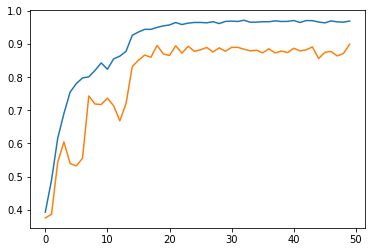

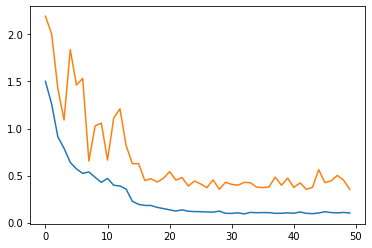

0.8985789913624965

In [99]:
plt.plot([k[-2] for k in hist])
plt.plot([k[-1] for k in hist])
plt.show()
plt.plot([k[0] for k in hist])
plt.plot([k[1] for k in hist])
plt.show()
best_acc

In [100]:
model = torch.load('exploss_more/sVGG_opt_residualexploss_l2normrow_lastconv_originalimgsize_noaugmentation_model.pt')

running_valloss = 0.0
running_valacc = 0.0
exp_features = []
exp_labels = []
for i,data in enumerate(test_loader):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs,_, features = model(inputs, labels)
    
    with torch.no_grad():
        exp_features.append(features.detach().cpu())
        exp_labels.append(labels.detach().cpu())

    loss = criterion(outputs, labels)
    acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

    running_valloss += (loss.item() * inputs.size(0))
    running_valacc += acc.item()

print('- Avg. val_loss: %.4f | Avg. val_acc: %.4f' % (running_valloss / len(test_loader.dataset), running_valacc / len(test_loader.dataset)))


- Avg. val_loss: 0.3070 | Avg. val_acc: 0.9142


In [101]:
exp_features = torch.cat(exp_features, axis=0).flatten(1)
exp_labels = torch.cat(exp_labels)

exp_features.size()

torch.Size([3589, 512])

(<Figure size 1080x720 with 1 Axes>, array([[ -2.3392644,  -1.9539845],
        [-50.474655 ,  14.493396 ],
        [ 32.147686 , -51.91559  ],
        ...,
        [-11.213221 ,  19.426577 ],
        [ 17.729824 ,  24.209366 ],
        [-41.800667 , -32.634712 ]], dtype=float32))

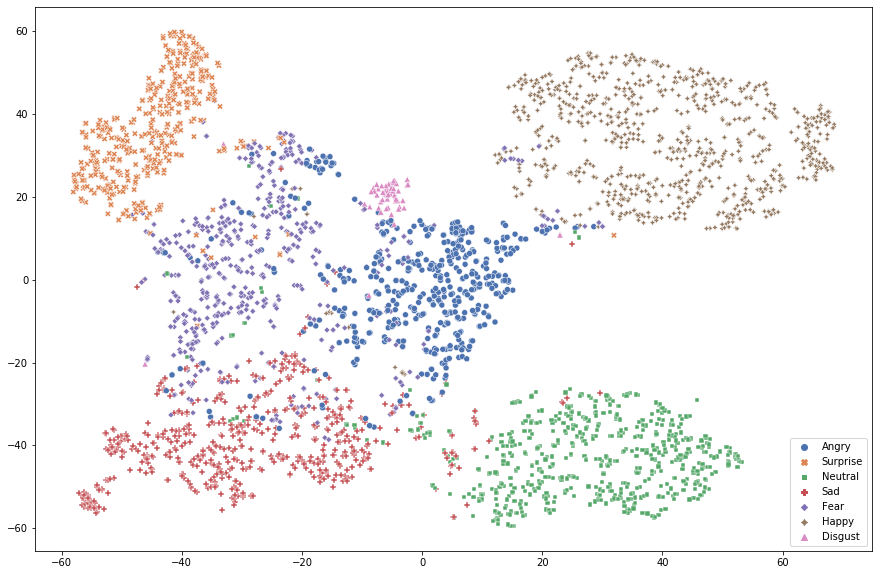

In [102]:
visualize_embedding(exp_features.numpy(), exp_labels.numpy(), label_dict=label_dict, save_path='exploss_more/sVGG_opt_residualexploss_l2normrow_lastconv_originalimgsize_noaugmentation_tsne.png')


### 2 last convs

In [32]:
class sVGG_exp(nn.Module):
    def __init__(self, features, in_features_classifier, n_classes):
        super(sVGG_exp, self).__init__()
        self.features_0 = features[:7]
        self.features_1 = features[7:14]
        self.features_2 = features[14:24]
        self.features_3 = features[24:34]
        
        self.features_0[0] = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        
        self.exploss_2 = ExpLoss(256)
        self.exploss_3 = ExpLoss(512)
        
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.classifier = nn.Sequential(nn.Flatten(),
                                        nn.Linear(in_features_classifier, in_features_classifier),
                                        nn.ReLU(inplace=True),
                                        nn.Dropout(0.5, inplace=False),
                                        nn.Linear(in_features_classifier, in_features_classifier // 2),
                                        nn.ReLU(inplace=True),
                                        nn.Dropout(0.5, inplace=False),
                                        nn.Linear(in_features_classifier // 2, n_classes))
        
    def forward(self, x, labels, return_att=True):
        x = self.features_0(x)
        
        x = self.features_1(x)
        
        x = self.features_2(x)
        x, _ = self.exploss_2(x, labels)
        
        x = self.features_3(x)
        x, _ = self.exploss_3(x, labels)
        
        att = self.avgpool(x)
        x = self.classifier(att)
        
        if return_att:
            return x, 0, att
        return x, 0
        

In [35]:
MAX_LOGSTD=10
model_path = 'exploss_more/sVGG_opt_residualexploss_intermediate_originalimgsize_noaugmentation_model.pt'
alpha = 1

# optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
for epoch in range(epochs):  # loop over the dataset multiple times

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0
    processed = 0.0

    # TRAIN
    model.train()
    pbar = tqdm(train_loader, position=0)
    for i, data in enumerate(pbar):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs, sim_loss, features = model(inputs, labels)
        loss = criterion(outputs, labels) + sim_loss
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()
        
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += (loss.item() * inputs.size(0))
        running_acc += acc.item()
        processed += len(inputs)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={i} Accuracy={acc.item() / inputs.size(0)}')

    print('- Avg.loss: %.4f | Avg.acc: %.4f' % (running_loss / len(train_loader.dataset), running_acc / len(train_loader.dataset)))
    avgloss = running_loss / len(train_loader.dataset)
    avgacc = running_acc / len(train_loader.dataset)

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs, sim_loss, features = model(inputs, labels)
        
        loss = criterion(outputs, labels) + sim_loss
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        running_valloss += (loss.item() * inputs.size(0))
        running_valacc += acc.item()

    print('- Avg. val_loss: %.4f | Avg. val_acc: %.4f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

    avgvalloss = running_valloss / len(val_loader.dataset)
    avgvalacc = running_valacc / len(val_loader.dataset)
    
    scheduler.step(avgvalacc)

    hist.append([avgloss, avgvalloss, avgacc, avgvalacc])
    
    if best_acc < avgvalacc:
        best_acc = avgvalacc
        torch.save(model, model_path)
        print('* Update optimal model')

print('Finished Training')


  0%|          | 0/449 [00:00<?, ?it/s]

Epoch:  1


Loss=1.1584357023239136 Batch_id=448 Accuracy=0.5135135135135135: 100%|██████████| 449/449 [00:21<00:00, 21.29it/s]

- Avg.loss: 1.3765 | Avg.acc: 0.4438



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.2334 | Avg. val_acc: 0.5099
* Update optimal model
Epoch:  2


Loss=0.9972562193870544 Batch_id=448 Accuracy=0.4594594594594595: 100%|██████████| 449/449 [00:21<00:00, 21.29it/s]

- Avg.loss: 1.0384 | Avg.acc: 0.5628



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.4237 | Avg. val_acc: 0.4185
Epoch:  3


Loss=0.601891040802002 Batch_id=448 Accuracy=0.7837837837837838: 100%|██████████| 449/449 [00:21<00:00, 21.21it/s]

- Avg.loss: 0.9074 | Avg.acc: 0.6107


- Avg. val_loss: 1.2848 | Avg. val_acc: 0.5436


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  4


Loss=0.9150855541229248 Batch_id=448 Accuracy=0.43243243243243246: 100%|██████████| 449/449 [00:21<00:00, 21.22it/s]

- Avg.loss: 0.8494 | Avg.acc: 0.6403



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 177.7983 | Avg. val_acc: 0.1234
Epoch:  5


Loss=0.959843099117279 Batch_id=448 Accuracy=0.6216216216216216: 100%|██████████| 449/449 [00:21<00:00, 21.20it/s]

- Avg.loss: 0.8316 | Avg.acc: 0.6333



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.3874 | Avg. val_acc: 0.4452
Epoch:  6


Loss=1.346240758895874 Batch_id=448 Accuracy=0.5945945945945946: 100%|██████████| 449/449 [00:21<00:00, 21.14it/s]

- Avg.loss: 0.8013 | Avg.acc: 0.6393



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.5007 | Avg. val_acc: 0.4790
Epoch:  7


Loss=0.8370652794837952 Batch_id=448 Accuracy=0.7297297297297297: 100%|██████████| 449/449 [00:21<00:00, 21.17it/s]

- Avg.loss: 0.7552 | Avg.acc: 0.6536


- Avg. val_loss: 1.3452 | Avg. val_acc: 0.5483


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  8


Loss=1.0026731491088867 Batch_id=448 Accuracy=0.8108108108108109: 100%|██████████| 449/449 [00:21<00:00, 21.14it/s]

- Avg.loss: 0.7065 | Avg.acc: 0.6617



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 4.8767 | Avg. val_acc: 0.4149
Epoch:  9


Loss=0.5972000360488892 Batch_id=448 Accuracy=0.7297297297297297: 100%|██████████| 449/449 [00:21<00:00, 21.24it/s]

- Avg.loss: 0.6929 | Avg.acc: 0.6856



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 3.0217 | Avg. val_acc: 0.3068
Epoch:  10


Loss=0.7752954959869385 Batch_id=448 Accuracy=0.5945945945945946: 100%|██████████| 449/449 [00:21<00:00, 21.24it/s]

- Avg.loss: 0.6231 | Avg.acc: 0.7275



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.1196 | Avg. val_acc: 0.4347
Epoch:  11


Loss=0.6944054365158081 Batch_id=448 Accuracy=0.8108108108108109: 100%|██████████| 449/449 [00:21<00:00, 21.18it/s]

- Avg.loss: 0.5265 | Avg.acc: 0.8083


- Avg. val_loss: 1.2693 | Avg. val_acc: 0.6105


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  12


Loss=0.32400548458099365 Batch_id=448 Accuracy=0.8108108108108109: 100%|██████████| 449/449 [00:21<00:00, 21.11it/s]

- Avg.loss: 0.4785 | Avg.acc: 0.8301


- Avg. val_loss: 0.7990 | Avg. val_acc: 0.7568


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  13


Loss=1.2272831201553345 Batch_id=448 Accuracy=0.5405405405405406: 100%|██████████| 449/449 [00:21<00:00, 21.10it/s]

- Avg.loss: 0.3757 | Avg.acc: 0.8679


- Avg. val_loss: 0.8301 | Avg. val_acc: 0.7668


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  14


Loss=0.1945786029100418 Batch_id=448 Accuracy=0.918918918918919: 100%|██████████| 449/449 [00:21<00:00, 21.14it/s]

- Avg.loss: 0.3391 | Avg.acc: 0.8844


- Avg. val_loss: 0.6995 | Avg. val_acc: 0.8155


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  15


Loss=0.04825959354639053 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:21<00:00, 21.15it/s]     

- Avg.loss: 0.3380 | Avg.acc: 0.8927



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.9821 | Avg. val_acc: 0.7400
Epoch:  16


Loss=0.41931816935539246 Batch_id=448 Accuracy=0.7837837837837838: 100%|██████████| 449/449 [00:21<00:00, 21.16it/s]

- Avg.loss: 0.3180 | Avg.acc: 0.8935



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.6562 | Avg. val_acc: 0.7832
Epoch:  17


Loss=0.07623027265071869 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:21<00:00, 21.16it/s]      

- Avg.loss: 0.3110 | Avg.acc: 0.8966



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.9915 | Avg. val_acc: 0.7434
Epoch:  18


Loss=0.2660161256790161 Batch_id=448 Accuracy=0.8648648648648649: 100%|██████████| 449/449 [00:21<00:00, 21.15it/s]

- Avg.loss: 0.2987 | Avg.acc: 0.9040



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.7754 | Avg. val_acc: 0.7757
Epoch:  19


Loss=0.017054008319973946 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:21<00:00, 21.24it/s]    

- Avg.loss: 0.2600 | Avg.acc: 0.9132



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.5658 | Avg. val_acc: 0.6520
Epoch:  20


Loss=0.05899699777364731 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:21<00:00, 21.21it/s]

- Avg.loss: 0.2490 | Avg.acc: 0.9221


- Avg. val_loss: 0.7141 | Avg. val_acc: 0.8376


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  21


Loss=0.6578261852264404 Batch_id=448 Accuracy=0.7567567567567568: 100%|██████████| 449/449 [00:21<00:00, 21.21it/s]

- Avg.loss: 0.4313 | Avg.acc: 0.8490



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.7424 | Avg. val_acc: 0.7364
Epoch:  22


Loss=0.06341179460287094 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:21<00:00, 21.18it/s]      

- Avg.loss: 0.2473 | Avg.acc: 0.9198



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.2372 | Avg. val_acc: 0.7253
Epoch:  23


Loss=0.36356958746910095 Batch_id=448 Accuracy=0.8918918918918919: 100%|██████████| 449/449 [00:21<00:00, 21.15it/s]

- Avg.loss: 0.2968 | Avg.acc: 0.9096



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.8566 | Avg. val_acc: 0.6562
Epoch:  24


Loss=0.48624885082244873 Batch_id=448 Accuracy=0.7837837837837838: 100%|██████████| 449/449 [00:21<00:00, 21.23it/s]

- Avg.loss: 0.2099 | Avg.acc: 0.9328



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.2178 | Avg. val_acc: 0.6871
Epoch:  25


Loss=2.9503536224365234 Batch_id=448 Accuracy=0.6486486486486487: 100%|██████████| 449/449 [00:21<00:00, 21.19it/s]

- Avg.loss: 0.1868 | Avg.acc: 0.9478



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.8209 | Avg. val_acc: 0.7988
Epoch:  26


Loss=0.110907644033432 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:21<00:00, 21.22it/s]        

- Avg.loss: 0.1860 | Avg.acc: 0.9464



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.6158 | Avg. val_acc: 0.8169
Epoch    26: reducing learning rate of group 0 to 1.0000e-04.
Epoch:  27


Loss=0.014528404921293259 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:21<00:00, 21.16it/s]     

- Avg.loss: 0.0904 | Avg.acc: 0.9716


- Avg. val_loss: 0.4855 | Avg. val_acc: 0.8718


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  28


Loss=0.046885691583156586 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:21<00:00, 21.14it/s]

- Avg.loss: 0.0631 | Avg.acc: 0.9814



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.4811 | Avg. val_acc: 0.8690
Epoch:  29


Loss=1.178216814994812 Batch_id=448 Accuracy=0.6756756756756757: 100%|██████████| 449/449 [00:21<00:00, 21.17it/s]

- Avg.loss: 0.0639 | Avg.acc: 0.9817



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.4705 | Avg. val_acc: 0.8696
Epoch:  30


Loss=0.03100568801164627 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:21<00:00, 21.19it/s]      

- Avg.loss: 0.0522 | Avg.acc: 0.9849


- Avg. val_loss: 0.4671 | Avg. val_acc: 0.8866


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  31


Loss=0.40828055143356323 Batch_id=448 Accuracy=0.7837837837837838: 100%|██████████| 449/449 [00:21<00:00, 21.15it/s]

- Avg.loss: 0.0546 | Avg.acc: 0.9834



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.5075 | Avg. val_acc: 0.8716
Epoch:  32


Loss=0.0018407893367111683 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:21<00:00, 21.18it/s]    

- Avg.loss: 0.0514 | Avg.acc: 0.9843


- Avg. val_loss: 0.3951 | Avg. val_acc: 0.8930


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  33


Loss=0.012100767344236374 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:21<00:00, 21.07it/s]     

- Avg.loss: 0.0453 | Avg.acc: 0.9854



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.4654 | Avg. val_acc: 0.8916
Epoch:  34


Loss=0.25567376613616943 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:21<00:00, 21.11it/s]

- Avg.loss: 0.0486 | Avg.acc: 0.9866



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.4601 | Avg. val_acc: 0.8922
Epoch:  35


Loss=0.2232385277748108 Batch_id=448 Accuracy=0.8918918918918919: 100%|██████████| 449/449 [00:21<00:00, 21.09it/s]

- Avg.loss: 0.0450 | Avg.acc: 0.9881



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.5646 | Avg. val_acc: 0.8696
Epoch:  36


Loss=1.5328484773635864 Batch_id=448 Accuracy=0.7027027027027027: 100%|██████████| 449/449 [00:21<00:00, 21.22it/s]

- Avg.loss: 0.0392 | Avg.acc: 0.9885



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.5348 | Avg. val_acc: 0.8696
Epoch:  37


Loss=0.010959777981042862 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:21<00:00, 21.24it/s]     

- Avg.loss: 0.0448 | Avg.acc: 0.9880


- Avg. val_loss: 0.4644 | Avg. val_acc: 0.8966


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  38


Loss=0.056553494185209274 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:21<00:00, 21.19it/s]

- Avg.loss: 0.0467 | Avg.acc: 0.9864


- Avg. val_loss: 0.4454 | Avg. val_acc: 0.8972


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  39


Loss=0.46964702010154724 Batch_id=448 Accuracy=0.8108108108108109: 100%|██████████| 449/449 [00:21<00:00, 21.20it/s]

- Avg.loss: 0.0558 | Avg.acc: 0.9829



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.5357 | Avg. val_acc: 0.8677
Epoch:  40


Loss=0.016890278086066246 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:21<00:00, 21.23it/s]     

- Avg.loss: 0.0451 | Avg.acc: 0.9882



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.4693 | Avg. val_acc: 0.8938
Epoch:  41


Loss=1.1324918270111084 Batch_id=448 Accuracy=0.7567567567567568: 100%|██████████| 449/449 [00:21<00:00, 21.24it/s]

- Avg.loss: 0.0367 | Avg.acc: 0.9889



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.4694 | Avg. val_acc: 0.8841
Epoch:  42


Loss=0.206422358751297 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:21<00:00, 21.18it/s]

- Avg.loss: 0.0517 | Avg.acc: 0.9850



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.5510 | Avg. val_acc: 0.8690
Epoch:  43


Loss=0.951447069644928 Batch_id=448 Accuracy=0.7027027027027027: 100%|██████████| 449/449 [00:21<00:00, 21.14it/s]

- Avg.loss: 0.0517 | Avg.acc: 0.9848



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.4164 | Avg. val_acc: 0.8858
Epoch:  44


Loss=1.1121488809585571 Batch_id=448 Accuracy=0.8918918918918919: 100%|██████████| 449/449 [00:21<00:00, 21.23it/s]

- Avg.loss: 0.0448 | Avg.acc: 0.9866



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.5496 | Avg. val_acc: 0.8640
Epoch    44: reducing learning rate of group 0 to 1.0000e-05.
Epoch:  45


Loss=2.5460433959960938 Batch_id=448 Accuracy=0.6216216216216216: 100%|██████████| 449/449 [00:21<00:00, 21.16it/s]

- Avg.loss: 0.0349 | Avg.acc: 0.9901



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.4325 | Avg. val_acc: 0.8894
Epoch:  46


Loss=0.009303347207605839 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:21<00:00, 21.21it/s]     

- Avg.loss: 0.0261 | Avg.acc: 0.9920



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.4676 | Avg. val_acc: 0.8805
Epoch:  47


Loss=0.28939175605773926 Batch_id=448 Accuracy=0.8378378378378378: 100%|██████████| 449/449 [00:21<00:00, 21.11it/s]

- Avg.loss: 0.0197 | Avg.acc: 0.9933



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.4324 | Avg. val_acc: 0.8963
Epoch:  48


Loss=0.0449887216091156 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:21<00:00, 21.16it/s]       

- Avg.loss: 0.0321 | Avg.acc: 0.9894


- Avg. val_loss: 0.4340 | Avg. val_acc: 0.8989


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  49


Loss=0.4175436198711395 Batch_id=448 Accuracy=0.8918918918918919: 100%|██████████| 449/449 [00:21<00:00, 21.16it/s]

- Avg.loss: 0.0287 | Avg.acc: 0.9918


- Avg. val_loss: 0.4187 | Avg. val_acc: 0.9069


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  50


Loss=0.1073293685913086 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:21<00:00, 21.11it/s]

- Avg.loss: 0.0239 | Avg.acc: 0.9923


- Avg. val_loss: 0.5016 | Avg. val_acc: 0.8833
Finished Training


In [36]:
pickle.dump(hist, open('exploss_more/sVGG_opt_residualexploss_intermediate_originalimgsize_noaugmentation_hist.hdf5', 'wb'))


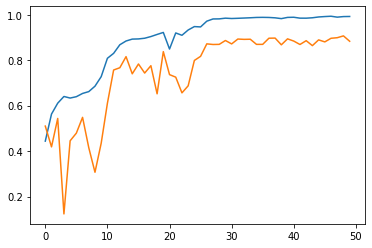

0.9069378657007523

In [37]:
plt.plot([k[-2] for k in hist])
plt.plot([k[-1] for k in hist])
plt.show()
plt.plot([k[0] for k in hist])
plt.plot([k[1] for k in hist])
plt.show()
best_acc

In [41]:
model = torch.load('exploss_more/sVGG_opt_residualexploss_intermediate_originalimgsize_noaugmentation_model.pt')

running_valloss = 0.0
running_valacc = 0.0
exp_features = []
exp_labels = []
for i,data in enumerate(test_loader):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs,_, features = model(inputs, labels)
    
    with torch.no_grad():
        exp_features.append(features.detach().cpu())
        exp_labels.append(labels.detach().cpu())

    loss = criterion(outputs, labels)
    acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

    running_valloss += (loss.item() * inputs.size(0))
    running_valacc += acc.item()

print('- Avg. val_loss: %.4f | Avg. val_acc: %.4f' % (running_valloss / len(test_loader.dataset), running_valacc / len(test_loader.dataset)))


- Avg. val_loss: 0.3823 | Avg. val_acc: 0.9025


In [42]:
exp_features = torch.cat(exp_features, axis=0).flatten(1)
exp_labels = torch.cat(exp_labels)

exp_features.size()

torch.Size([3589, 512])

(<Figure size 1080x720 with 1 Axes>, array([[ 17.851828 ,  12.038693 ],
        [ 44.610813 , -15.770934 ],
        [ 62.41181  , -37.09451  ],
        ...,
        [  5.053162 ,  21.012987 ],
        [ -5.457514 , -60.419464 ],
        [-72.630714 ,   2.2000177]], dtype=float32))

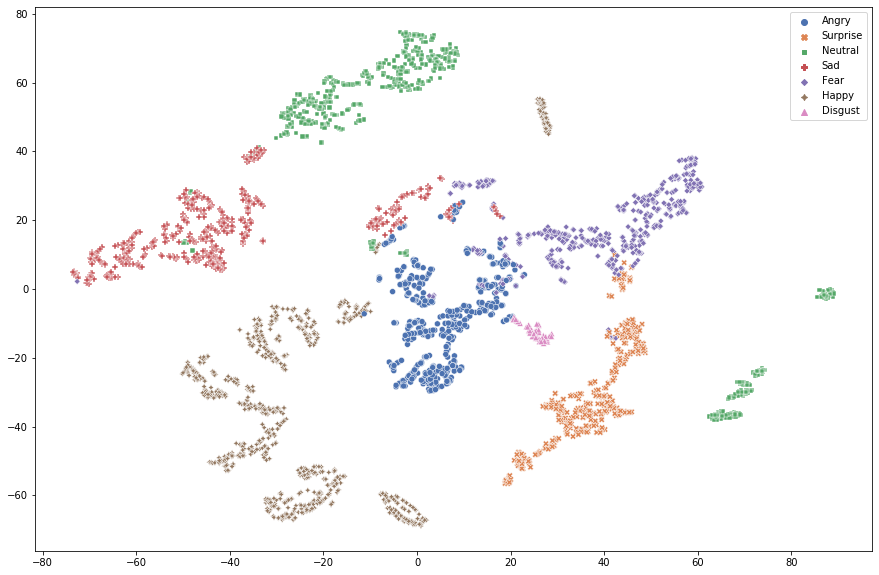

In [43]:
visualize_embedding(exp_features.numpy(), exp_labels.numpy(), label_dict=label_dict, save_path='exploss_more/sVGG_opt_residualexploss_intermediate_originalimgsize_noaugmentation_tsne.png')


### Compare the training progress

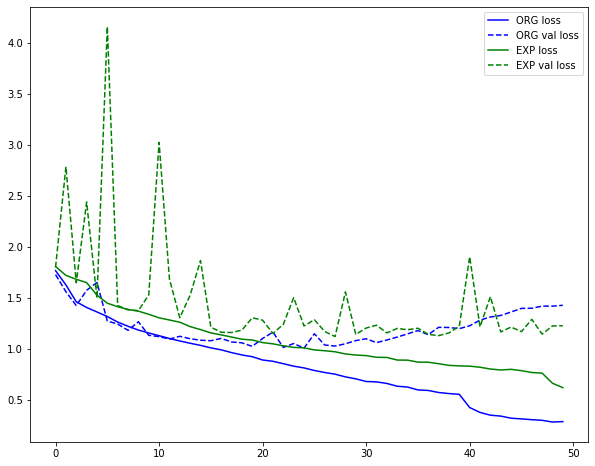

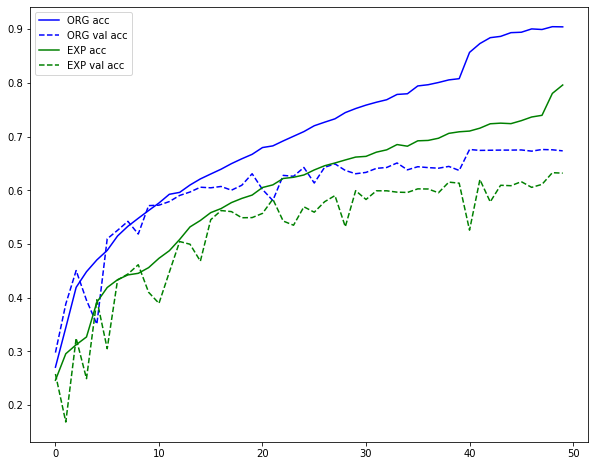

In [16]:
original = pickle.load(open('exploss/sVGG_hist.hdf5' ,'rb'))
exp = pickle.load(open('exploss/sVGG_exploss_hist.hdf5', 'rb'))

# loss
plt.figure(figsize=(10,8))
plt.plot([k[0] for k in original], 'b-', label='ORG loss')
plt.plot([k[1] for k in original], 'b--', label='ORG val loss')

plt.plot([k[0] for k in exp], 'g-', label='EXP loss')
plt.plot([k[1] for k in exp], 'g--', label='EXP val loss')

plt.legend()
plt.show()

# accuracy
plt.figure(figsize=(10,8))
plt.plot([k[-2] for k in original], 'b-', label='ORG acc')
plt.plot([k[-1] for k in original], 'b--', label='ORG val acc')

plt.plot([k[-2] for k in exp], 'g-', label='EXP acc')
plt.plot([k[-1] for k in exp], 'g--', label='EXP val acc')

plt.legend()
plt.show()



## Representation

In [50]:
model = torch.load('exploss/sVGG_model.pt')

running_valloss = 0.0
running_valacc = 0.0
org_features = []
org_labels = []
for i,data in enumerate(test_loader):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs, features = model(inputs)
    
    with torch.no_grad():
        org_features.append(features.detach().cpu().squeeze())
        org_labels.append(labels.detach().cpu())

    loss = criterion(outputs, labels)
    acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

    running_valloss += (loss.item() * inputs.size(0))
    running_valacc += acc.item()

print('- Avg. val_loss: %.4f | Avg. val_acc: %.4f' % (running_valloss / len(test_loader.dataset), running_valacc / len(test_loader.dataset)))


- Avg. val_loss: 1.1224 | Avg. val_acc: 0.6874


In [51]:
model = torch.load('exploss/sVGG_exploss_model.pt')

running_valloss = 0.0
running_valacc = 0.0
exp_features = []
exp_labels = []
for i,data in enumerate(test_loader):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs,_, features = model(inputs, labels)
    
    with torch.no_grad():
        exp_features.append(features.detach().cpu())
        exp_labels.append(labels.detach().cpu())

    loss = criterion(outputs, labels)
    acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

    running_valloss += (loss.item() * inputs.size(0))
    running_valacc += acc.item()

print('- Avg. val_loss: %.4f | Avg. val_acc: %.4f' % (running_valloss / len(test_loader.dataset), running_valacc / len(test_loader.dataset)))


- Avg. val_loss: 1.1320 | Avg. val_acc: 0.6381


In [52]:
org_features = torch.cat(org_features, axis=0)
org_labels = torch.cat(org_labels)

exp_features = torch.cat(exp_features, axis=0)
exp_labels = torch.cat(exp_labels)

org_features.size(), exp_features.size()

(torch.Size([3589, 512]), torch.Size([3589, 512]))

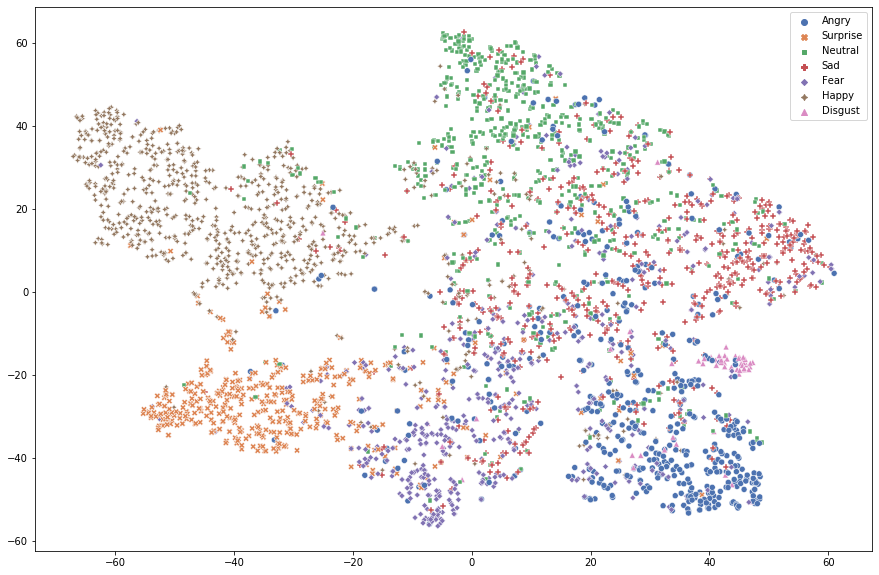

In [62]:
org_fig, org_tsne = visualize_embedding(org_features.numpy(), org_labels.numpy(), label_dict, save_path=None)

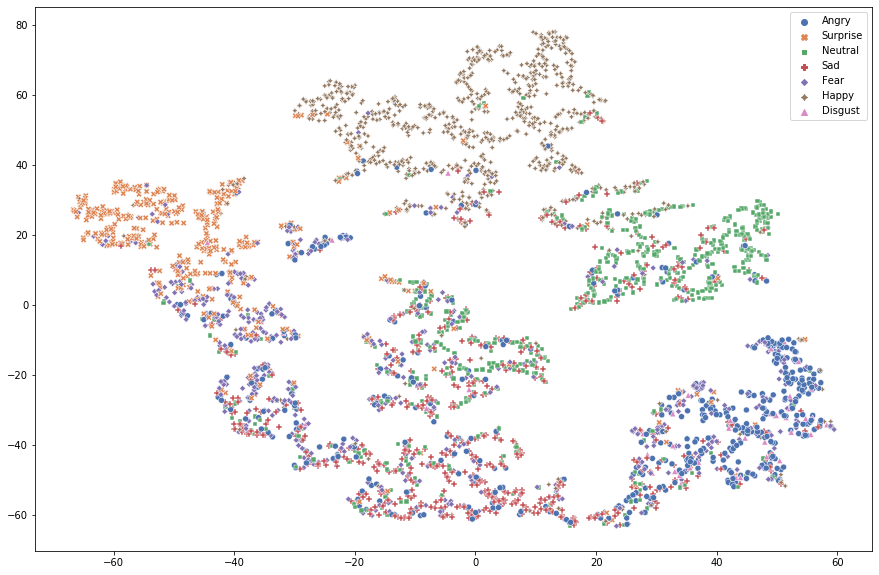

In [63]:
exp_fig, exp_tsne = visualize_embedding(exp_features.numpy(), exp_labels.numpy(), label_dict, save_path=None)

## Exploss with bridge features

In [7]:
class ExpLoss(nn.Module):
    def __init__(self, depth, residual=True, nclasses=7):
        super(ExpLoss, self).__init__()
        
        self.depth = depth
        self.residual = residual
        
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()
        
        self.fc1 = nn.Linear(depth, depth)
        self.fc2 = nn.Linear(depth, depth)
        
#         self.main_fc = nn.Linear(depth, depth)
        
        self.sim_act = nn.Sigmoid()
        self.att_act = nn.Sigmoid()
        
        self.out_fc = nn.Sequential(nn.Linear(depth, depth),
                                    nn.BatchNorm1d(depth),
                                    nn.ReLU())
        
        # bridge features
        self.bridge_features = nn.Parameter(torch.rand(nclasses, depth))
        self.bridge_labels = torch.arange(nclasses)
        
    def forward(self, x, labels):
        batch_size = x.size(0)
        
        x = self.avgpool(x)
        x = self.flatten(x)
        
        if self.residual:
            x_res = x
        
        # add bridge features
        x = torch.cat([x, self.bridge_features.to(x.device)], dim=0)
        labels = torch.cat([labels, self.bridge_labels.to(labels.device)], dim=0)
        
        
        x1 = self.fc1(x)
        x2 = self.fc2(x)
        
        # cal sims (batchsize, depth)
        sims = torch.mm(x1, x2.permute(1,0))
        sims = sims / batch_size
        mask = self.filter_mask(labels)
        att = sims * (1 - mask.to(sims.device)) # only consider sample of same labels
        
        # TEMP SOLUTION: remove bridge features of row to ensure the original batch size
        att = att[:batch_size, :]
        
        x = torch.mm(att, x)
        x = self.out_fc(x)
    
        if self.residual:
            x = x + x_res
        
        return x, 0

    def filter_mask(self, labels):
        """
        zero
        """
        classes = torch.unique(labels)
        mask = torch.ones((len(labels), len(labels)))
        
        indices = [(labels == k).nonzero().flatten() for k in classes]
        lindices = [torch.combinations(k, r=2, with_replacement=True) for k in indices]
        rindices = [torch.combinations(k.flip(0), r=2, with_replacement=True) for k in indices]
        indices = [torch.cat([lindices[i], rindices[i]]) for i in range(len(lindices))]

        for k in indices:
            mask[k[:,0], k[:,1]] = 0.
            
        return mask

In [8]:
class sVGG_exp(nn.Module):
    def __init__(self, features, in_features_classifier, n_classes):
        super(sVGG_exp, self).__init__()
        self.features = features
        self.features[0] = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.exploss = ExpLoss(512, True, n_classes)
#         self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.classifier = nn.Sequential(nn.Flatten(),
                                        nn.Linear(in_features_classifier, in_features_classifier),
                                        nn.ReLU(inplace=True),
                                        nn.Dropout(0.5, inplace=False),
                                        nn.Linear(in_features_classifier, in_features_classifier // 2),
                                        nn.ReLU(inplace=True),
                                        nn.Dropout(0.5, inplace=False),
                                        nn.Linear(in_features_classifier // 2, n_classes))
        
    def forward(self, x, labels, return_att=True):
        x = self.features(x)
        att, sim_loss = self.exploss(x, labels)

#         att = self.avgpool(x)
        x = self.classifier(att)
        
        if return_att:
            return x, sim_loss, att
        return x, sim_loss
        

In [9]:
sample_model = vgg16_bn(pretrained=False)
model = sVGG_exp(features=sample_model.features[:34], in_features_classifier=512, n_classes=7)

In [10]:
lr = 0.001
epochs = 10
device = torch.device('cuda')

model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=5, verbose=True)

best_acc = 0.0
hist = []

In [11]:
MAX_LOGSTD=10
model_path = 'exploss_more/sVGG_opt_residualexploss_bridgefeatures_originalimgsize_noaugmentation_model.pt'
alpha = 1

# optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
for epoch in range(epochs):  # loop over the dataset multiple times

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0
    processed = 0.0

    # TRAIN
    model.train()
    pbar = tqdm(train_loader, position=0)
    for i, data in enumerate(pbar):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs, sim_loss, features = model(inputs, labels)
        loss = criterion(outputs, labels) + sim_loss
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()
        
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += (loss.item() * inputs.size(0))
        running_acc += acc.item()
        processed += len(inputs)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={i} Accuracy={acc.item() / inputs.size(0)}')

    print('- Avg.loss: %.4f | Avg.acc: %.4f' % (running_loss / len(train_loader.dataset), running_acc / len(train_loader.dataset)))
    avgloss = running_loss / len(train_loader.dataset)
    avgacc = running_acc / len(train_loader.dataset)

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs, sim_loss, features = model(inputs, labels)
        
        loss = criterion(outputs, labels) + sim_loss
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        running_valloss += (loss.item() * inputs.size(0))
        running_valacc += acc.item()

    print('- Avg. val_loss: %.4f | Avg. val_acc: %.4f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

    avgvalloss = running_valloss / len(val_loader.dataset)
    avgvalacc = running_valacc / len(val_loader.dataset)
    
    scheduler.step(avgvalacc)

    hist.append([avgloss, avgvalloss, avgacc, avgvalacc])
    
    if best_acc < avgvalacc:
        best_acc = avgvalacc
        torch.save(model, model_path)
        print('* Update optimal model')

print('Finished Training')


  0%|          | 0/449 [00:00<?, ?it/s]

Epoch:  1


Loss=3.058786387555301e-05 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:18<00:00, 24.46it/s]    

- Avg.loss: 0.3318 | Avg.acc: 0.8767



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.0000 | Avg. val_acc: 1.0000
* Update optimal model
Epoch:  2


Loss=0.00023588068142998964 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:18<00:00, 24.38it/s]   

- Avg.loss: 0.0048 | Avg.acc: 0.9987



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.0000 | Avg. val_acc: 1.0000
Epoch:  3


Loss=0.00010058889165520668 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:18<00:00, 24.28it/s]


- Avg.loss: 0.0002 | Avg.acc: 1.0000


  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.0000 | Avg. val_acc: 1.0000
Epoch:  4


Loss=0.0020084038842469454 Batch_id=208 Accuracy=1.0:  47%|████▋     | 209/449 [00:08<00:10, 23.58it/s]    


KeyboardInterrupt: 

In [22]:
model = torch.load('exploss_more/sVGG_opt_residualexploss_bridgefeatures_originalimgsize_noaugmentation_model.pt')

running_valloss = 0.0
running_valacc = 0.0
exp_features = []
exp_labels = []
for i,data in enumerate(test_loader):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs,_, features = model(inputs, labels)
    
    with torch.no_grad():
        exp_features.append(features.detach().cpu())
        exp_labels.append(labels.detach().cpu())

    loss = criterion(outputs, labels)
    acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

    running_valloss += (loss.item() * inputs.size(0))
    running_valacc += acc.item()

print('- Avg. val_loss: %.4f | Avg. val_acc: %.4f' % (running_valloss / len(test_loader.dataset), running_valacc / len(test_loader.dataset)))


- Avg. val_loss: 0.0000 | Avg. val_acc: 1.0000


In [23]:
exp_features = torch.cat(exp_features, axis=0)
exp_labels = torch.cat(exp_labels)

exp_features.size()

torch.Size([3589, 512])

(<Figure size 1080x720 with 1 Axes>,
 array([[-59.721592 , -12.669938 ],
        [ 14.052021 ,  57.53288  ],
        [ -5.838561 , -72.911934 ],
        ...,
        [-28.349749 , -20.184967 ],
        [ -5.6542597,  -1.4493908],
        [ -8.489179 ,  -1.0155376]], dtype=float32))

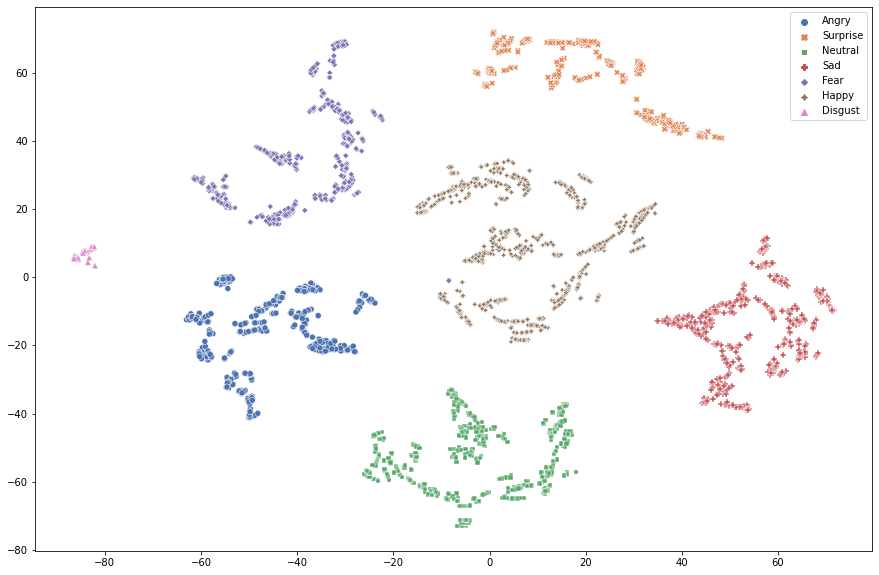

In [24]:
visualize_embedding(exp_features.numpy(), exp_labels.numpy(), label_dict=label_dict, save_path=None)


(<Figure size 1080x720 with 1 Axes>,
 array([[ 49.932213  ,   9.694878  ],
        [-41.065407  , -42.900406  ],
        [  8.567396  ,  58.593006  ],
        ...,
        [ -3.9830654 ,  58.669693  ],
        [-30.841452  , -42.971973  ],
        [-43.20294   ,  -0.65276325]], dtype=float32))

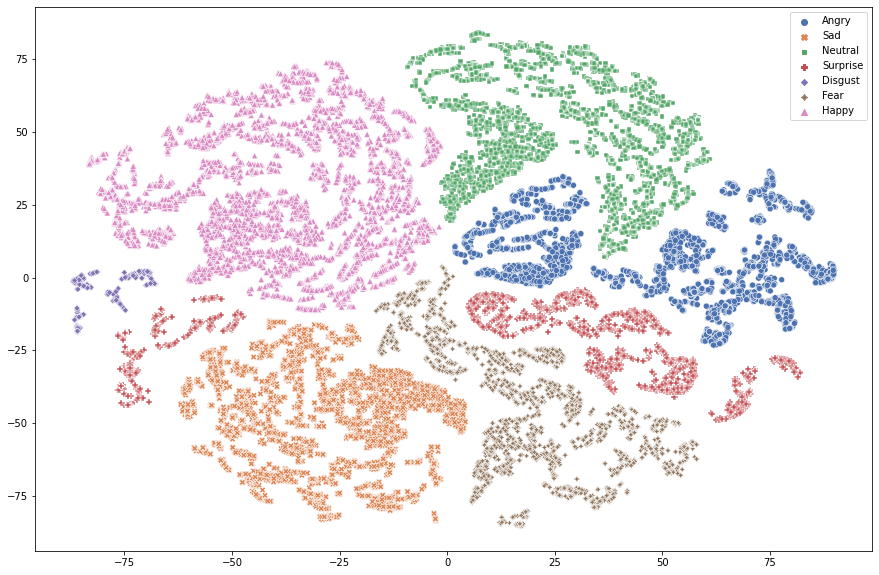

In [21]:
visualize_embedding(exp_features.numpy(), exp_labels.numpy(), label_dict=label_dict, save_path=None)
